# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/hybrid_graphs_output/graph_hybrid.pkl'
    NODE_MAPPING_PATH: str = '/storage32Tb/jay/mixtralModel/ADL Project/hybrid_graphs_output/node_mapping_hybrid.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    TOP_K_IMAGES_FAISS: int = 20

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    if "sorted_index_to_article_id" in node_map:
        node_map = node_map["sorted_index_to_article_id"]

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="bfs",
    hops=1,
    max_candidates=200,
    topk_per_node=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])

    if not seed_idxs:
        return []

    if mode == "bfs" or graph_weights is None:
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue
            for nbr in graph_adj.get(node, []):
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_topk":
        score = defaultdict(float)
        for s in seed_idxs:
            nbrs = graph_weights.get(s, {})
            for nbr, w in nbrs.items():
                if nbr in seed_idxs:
                    continue
                score[nbr] += float(w)

        ranked = sorted(score.items(), key=lambda x: x[1], reverse=True)
        selected = [idx for idx, _ in ranked][:max_candidates]

        result = []
        for idx in seed_idxs:
            if idx not in result:
                result.append(idx_to_aid[idx])
        for idx in selected:
            aid = idx_to_aid.get(idx)
            if aid is None:
                continue
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_hops":
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue

            nbr_w = graph_weights.get(node, None)
            if nbr_w:
                nbr_candidates = sorted(nbr_w.items(), key=lambda x: x[1], reverse=True)
                nbr_candidates = [n for n, _ in nbr_candidates[:topk_per_node]]
            else:
                nbr_candidates = list(graph_adj.get(node, []))

            for nbr in nbr_candidates:
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    return expand_candidates_via_graph(seed_article_ids, graph_adj, aid_to_idx, idx_to_aid,
                                       graph_weights=None, mode="bfs", hops=hops, max_candidates=max_candidates)



# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def rerank_articles_graph_only(article_ids, graph_adj_w, aid_to_idx, idx_to_aid):
    scores = {}
    for aid in article_ids:
        if aid not in aid_to_idx:
            continue
        idx = aid_to_idx[aid]
        for nbr, w in graph_adj_w[idx].items():
            aid_nbr = idx_to_aid[nbr]
            scores[aid_nbr] = scores.get(aid_nbr, 0) + w
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [aid for aid, _ in ranked][:config.TOP_K_ARTICLES_RERANK]


## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE, mmap_mode='r')
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE, faiss.IO_FLAG_MMAP)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(
    config.GRAPH_PATH,
    config.NODE_MAPPING_PATH
)

# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles_graph_only(expanded, graph_adj_weighted, aid_to_idx, idx_to_aid))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for c in candidates:
    exp = expand_candidates_via_graph(
        c,
        graph_adj,
        aid_to_idx,
        idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode=config.GRAPH_EXPANSION_MODE,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )
    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:02<00:49,  2.36s/it]

  9%|▉         | 2/22 [00:03<00:34,  1.72s/it]

 14%|█▎        | 3/22 [00:16<02:09,  6.83s/it]

 18%|█▊        | 4/22 [00:17<01:24,  4.70s/it]

 23%|██▎       | 5/22 [00:19<00:59,  3.50s/it]

 27%|██▋       | 6/22 [00:21<00:48,  3.03s/it]

 32%|███▏      | 7/22 [00:24<00:45,  3.00s/it]

 36%|███▋      | 8/22 [00:25<00:33,  2.43s/it]

 41%|████      | 9/22 [00:27<00:29,  2.29s/it]

 45%|████▌     | 10/22 [00:28<00:21,  1.80s/it]

 50%|█████     | 11/22 [00:29<00:16,  1.47s/it]

 55%|█████▍    | 12/22 [00:29<00:12,  1.29s/it]

 59%|█████▉    | 13/22 [00:31<00:11,  1.27s/it]

 64%|██████▎   | 14/22 [00:36<00:19,  2.44s/it]

 68%|██████▊   | 15/22 [00:38<00:17,  2.49s/it]

 73%|███████▎  | 16/22 [00:40<00:12,  2.15s/it]

 77%|███████▋  | 17/22 [00:43<00:12,  2.40s/it]

 82%|████████▏ | 18/22 [00:43<00:07,  1.84s/it]

 86%|████████▋ | 19/22 [00:44<00:04,  1.60s/it]

 91%|█████████ | 20/22 [00:46<00:03,  1.54s/it]

 95%|█████████▌| 21/22 [00:47<00:01,  1.40s/it]

100%|██████████| 22/22 [00:48<00:00,  1.34s/it]

100%|██████████| 22/22 [00:48<00:00,  2.20s/it]


Article Retrieval Metrics:
mAP: 0.0028
MRR: 0.0028
Recall@1: 0.0000
Recall@5: 0.0000
Recall@10: 0.0000
Recall@20: 0.0455
Recall@50: 0.0455

Image Retrieval Metrics:
mAP: 0.0455
MRR: 0.0455
Recall@1: 0.0455
Recall@5: 0.0455
Recall@10: 0.0455
Recall@20: 0.0455
Recall@50: 0.0455


# VISUALIZATION

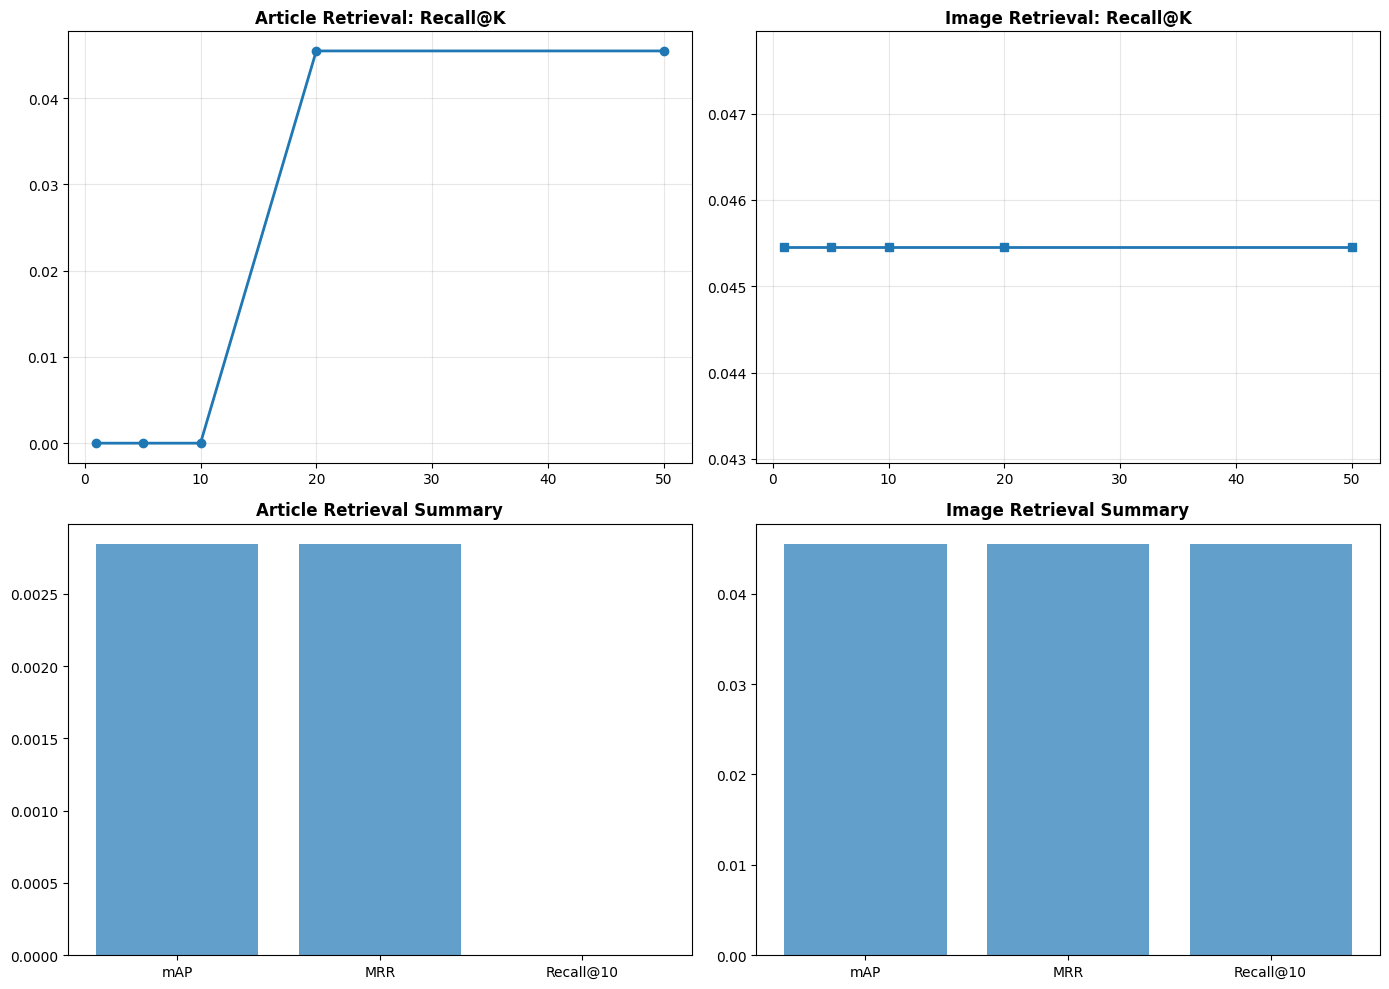

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles_graph_only(expanded, graph_adj_weighted, aid_to_idx, idx_to_aid))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:01<00:49,  1.08s/it]

  4%|▍         | 2/47 [00:02<00:48,  1.07s/it]

  6%|▋         | 3/47 [00:03<00:51,  1.18s/it]

  9%|▊         | 4/47 [00:04<00:52,  1.22s/it]

 11%|█         | 5/47 [00:05<00:45,  1.07s/it]

 13%|█▎        | 6/47 [00:06<00:46,  1.14s/it]

 15%|█▍        | 7/47 [00:07<00:42,  1.06s/it]

 17%|█▋        | 8/47 [00:08<00:39,  1.01s/it]

 19%|█▉        | 9/47 [00:10<00:43,  1.13s/it]

 21%|██▏       | 10/47 [00:11<00:42,  1.15s/it]

 23%|██▎       | 11/47 [00:12<00:39,  1.09s/it]

 26%|██▌       | 12/47 [00:13<00:44,  1.27s/it]

 28%|██▊       | 13/47 [00:14<00:41,  1.21s/it]

 30%|██▉       | 14/47 [00:15<00:37,  1.12s/it]

 32%|███▏      | 15/47 [00:16<00:32,  1.03s/it]

 34%|███▍      | 16/47 [00:17<00:29,  1.05it/s]

 36%|███▌      | 17/47 [00:18<00:26,  1.13it/s]

 38%|███▊      | 18/47 [00:19<00:28,  1.04it/s]

 40%|████      | 19/47 [00:20<00:28,  1.00s/it]

 43%|████▎     | 20/47 [00:21<00:25,  1.05it/s]

 45%|████▍     | 21/47 [00:22<00:25,  1.04it/s]

 47%|████▋     | 22/47 [00:23<00:27,  1.10s/it]

 49%|████▉     | 23/47 [00:24<00:26,  1.09s/it]

 51%|█████     | 24/47 [00:26<00:29,  1.30s/it]

 53%|█████▎    | 25/47 [00:28<00:31,  1.43s/it]

 55%|█████▌    | 26/47 [00:29<00:31,  1.50s/it]

 57%|█████▋    | 27/47 [00:31<00:27,  1.39s/it]

 60%|█████▉    | 28/47 [00:32<00:27,  1.45s/it]

 62%|██████▏   | 29/47 [00:33<00:24,  1.38s/it]

 64%|██████▍   | 30/47 [00:35<00:22,  1.35s/it]

 66%|██████▌   | 31/47 [00:36<00:20,  1.30s/it]

 68%|██████▊   | 32/47 [00:37<00:19,  1.28s/it]

 70%|███████   | 33/47 [00:38<00:18,  1.30s/it]

 72%|███████▏  | 34/47 [00:39<00:15,  1.23s/it]

 74%|███████▍  | 35/47 [00:41<00:14,  1.23s/it]

 77%|███████▋  | 36/47 [00:42<00:13,  1.27s/it]

 79%|███████▊  | 37/47 [00:43<00:12,  1.26s/it]

 81%|████████  | 38/47 [00:45<00:11,  1.29s/it]

 83%|████████▎ | 39/47 [00:46<00:10,  1.36s/it]

 85%|████████▌ | 40/47 [00:48<00:10,  1.48s/it]

 87%|████████▋ | 41/47 [00:49<00:08,  1.42s/it]

 89%|████████▉ | 42/47 [00:51<00:07,  1.57s/it]

 91%|█████████▏| 43/47 [00:52<00:06,  1.51s/it]

 94%|█████████▎| 44/47 [00:54<00:04,  1.56s/it]

 96%|█████████▌| 45/47 [00:56<00:03,  1.51s/it]

 98%|█████████▊| 46/47 [00:57<00:01,  1.36s/it]

100%|██████████| 47/47 [00:58<00:00,  1.30s/it]

100%|██████████| 47/47 [00:58<00:00,  1.24s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:01<00:48,  1.05s/it]

  4%|▍         | 2/47 [00:02<00:50,  1.12s/it]

  6%|▋         | 3/47 [00:03<00:43,  1.00it/s]

  9%|▊         | 4/47 [00:03<00:40,  1.05it/s]

 11%|█         | 5/47 [00:04<00:38,  1.09it/s]

 13%|█▎        | 6/47 [00:05<00:38,  1.08it/s]

 15%|█▍        | 7/47 [00:06<00:37,  1.06it/s]

 17%|█▋        | 8/47 [00:07<00:35,  1.09it/s]

 19%|█▉        | 9/47 [00:08<00:38,  1.02s/it]

 21%|██▏       | 10/47 [00:10<00:49,  1.35s/it]

 23%|██▎       | 11/47 [00:11<00:44,  1.23s/it]

 26%|██▌       | 12/47 [00:12<00:37,  1.09s/it]

 28%|██▊       | 13/47 [00:13<00:33,  1.03it/s]

 30%|██▉       | 14/47 [00:13<00:28,  1.17it/s]

 32%|███▏      | 15/47 [00:14<00:26,  1.19it/s]

 34%|███▍      | 16/47 [00:16<00:34,  1.13s/it]

 36%|███▌      | 17/47 [00:17<00:29,  1.01it/s]

 38%|███▊      | 18/47 [00:17<00:25,  1.13it/s]

 40%|████      | 19/47 [00:18<00:25,  1.08it/s]

 43%|████▎     | 20/47 [00:19<00:23,  1.13it/s]

 45%|████▍     | 21/47 [00:20<00:22,  1.16it/s]

 47%|████▋     | 22/47 [00:21<00:20,  1.20it/s]

 49%|████▉     | 23/47 [00:22<00:19,  1.22it/s]

 51%|█████     | 24/47 [00:22<00:17,  1.31it/s]

 53%|█████▎    | 25/47 [00:23<00:15,  1.45it/s]

 55%|█████▌    | 26/47 [00:23<00:13,  1.59it/s]

 57%|█████▋    | 27/47 [00:24<00:13,  1.52it/s]

 60%|█████▉    | 28/47 [00:25<00:12,  1.49it/s]

 62%|██████▏   | 29/47 [00:25<00:11,  1.50it/s]

 64%|██████▍   | 30/47 [00:26<00:11,  1.46it/s]

 66%|██████▌   | 31/47 [00:27<00:11,  1.43it/s]

 68%|██████▊   | 32/47 [00:27<00:10,  1.38it/s]

 70%|███████   | 33/47 [00:28<00:09,  1.41it/s]

 72%|███████▏  | 34/47 [00:29<00:09,  1.40it/s]

 74%|███████▍  | 35/47 [00:30<00:08,  1.43it/s]

 77%|███████▋  | 36/47 [00:30<00:07,  1.43it/s]

 79%|███████▊  | 37/47 [00:31<00:06,  1.46it/s]

 81%|████████  | 38/47 [00:32<00:06,  1.48it/s]

 83%|████████▎ | 39/47 [00:32<00:05,  1.48it/s]

 85%|████████▌ | 40/47 [00:33<00:04,  1.44it/s]

 87%|████████▋ | 41/47 [00:34<00:04,  1.41it/s]

 89%|████████▉ | 42/47 [00:34<00:03,  1.43it/s]

 91%|█████████▏| 43/47 [00:35<00:02,  1.45it/s]

 94%|█████████▎| 44/47 [00:36<00:02,  1.46it/s]

 96%|█████████▌| 45/47 [00:36<00:01,  1.48it/s]

 98%|█████████▊| 46/47 [00:37<00:00,  1.45it/s]

100%|██████████| 47/47 [00:38<00:00,  1.52it/s]

100%|██████████| 47/47 [00:38<00:00,  1.23it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:09<7:53:59,  9.48s/it]

  0%|          | 2/3000 [00:10<3:50:30,  4.61s/it]

  0%|          | 3/3000 [00:12<2:53:04,  3.46s/it]

  0%|          | 4/3000 [00:15<2:38:52,  3.18s/it]

  0%|          | 5/3000 [01:38<26:41:50, 32.09s/it]

  0%|          | 6/3000 [02:35<33:32:45, 40.34s/it]

  0%|          | 7/3000 [02:56<28:18:43, 34.05s/it]

  0%|          | 8/3000 [02:57<19:31:01, 23.48s/it]

  0%|          | 9/3000 [02:58<13:37:48, 16.41s/it]

  0%|          | 10/3000 [04:17<29:43:44, 35.79s/it]

  0%|          | 11/3000 [04:18<21:01:42, 25.33s/it]

  0%|          | 12/3000 [04:20<15:01:10, 18.10s/it]

  0%|          | 13/3000 [04:21<10:51:04, 13.08s/it]

  0%|          | 14/3000 [04:27<9:00:47, 10.87s/it] 

  0%|          | 15/3000 [04:29<6:47:15,  8.19s/it]

  1%|          | 16/3000 [04:31<5:15:56,  6.35s/it]

  1%|          | 17/3000 [04:33<4:02:42,  4.88s/it]

  1%|          | 18/3000 [04:34<3:07:19,  3.77s/it]

  1%|          | 19/3000 [04:35<2:28:03,  2.98s/it]

  1%|          | 20/3000 [04:36<2:00:32,  2.43s/it]

  1%|          | 21/3000 [04:41<2:43:36,  3.30s/it]

  1%|          | 22/3000 [04:44<2:36:45,  3.16s/it]

  1%|          | 23/3000 [04:45<2:03:59,  2.50s/it]

  1%|          | 24/3000 [04:46<1:42:45,  2.07s/it]

  1%|          | 25/3000 [04:47<1:26:38,  1.75s/it]

  1%|          | 26/3000 [04:48<1:08:28,  1.38s/it]

  1%|          | 27/3000 [04:49<1:03:53,  1.29s/it]

  1%|          | 28/3000 [04:50<1:00:45,  1.23s/it]

  1%|          | 29/3000 [04:51<58:26,  1.18s/it]  

  1%|          | 30/3000 [04:52<51:37,  1.04s/it]

  1%|          | 31/3000 [04:53<49:21,  1.00it/s]

  1%|          | 32/3000 [04:56<1:29:24,  1.81s/it]

  1%|          | 33/3000 [04:57<1:12:46,  1.47s/it]

  1%|          | 34/3000 [04:58<59:27,  1.20s/it]  

  1%|          | 35/3000 [04:59<1:07:24,  1.36s/it]

  1%|          | 36/3000 [05:03<1:32:48,  1.88s/it]

  1%|          | 37/3000 [05:09<2:34:02,  3.12s/it]

  1%|▏         | 38/3000 [05:09<1:56:41,  2.36s/it]

  1%|▏         | 39/3000 [05:12<2:02:31,  2.48s/it]

  1%|▏         | 40/3000 [05:13<1:39:12,  2.01s/it]

  1%|▏         | 41/3000 [05:15<1:38:03,  1.99s/it]

  1%|▏         | 42/3000 [05:16<1:22:42,  1.68s/it]

  1%|▏         | 43/3000 [05:18<1:25:42,  1.74s/it]

  1%|▏         | 44/3000 [05:19<1:19:20,  1.61s/it]

  2%|▏         | 45/3000 [05:20<1:09:22,  1.41s/it]

  2%|▏         | 46/3000 [05:22<1:19:21,  1.61s/it]

  2%|▏         | 47/3000 [05:23<1:13:34,  1.49s/it]

  2%|▏         | 48/3000 [05:24<1:01:21,  1.25s/it]

  2%|▏         | 49/3000 [05:25<57:59,  1.18s/it]  

  2%|▏         | 50/3000 [05:26<50:49,  1.03s/it]

  2%|▏         | 51/3000 [05:26<43:30,  1.13it/s]

  2%|▏         | 52/3000 [05:27<40:35,  1.21it/s]

  2%|▏         | 53/3000 [05:28<41:31,  1.18it/s]

  2%|▏         | 54/3000 [05:32<1:26:21,  1.76s/it]

  2%|▏         | 55/3000 [05:39<2:54:05,  3.55s/it]

  2%|▏         | 56/3000 [05:40<2:20:07,  2.86s/it]

  2%|▏         | 57/3000 [05:42<2:01:23,  2.47s/it]

  2%|▏         | 58/3000 [05:44<1:58:44,  2.42s/it]

  2%|▏         | 59/3000 [05:46<1:41:44,  2.08s/it]

  2%|▏         | 60/3000 [05:52<2:45:29,  3.38s/it]

  2%|▏         | 61/3000 [05:56<2:57:25,  3.62s/it]

  2%|▏         | 62/3000 [05:57<2:22:11,  2.90s/it]

  2%|▏         | 63/3000 [05:59<1:55:52,  2.37s/it]

  2%|▏         | 64/3000 [06:05<2:51:07,  3.50s/it]

  2%|▏         | 65/3000 [06:06<2:20:14,  2.87s/it]

  2%|▏         | 66/3000 [06:09<2:20:46,  2.88s/it]

  2%|▏         | 67/3000 [06:10<1:49:33,  2.24s/it]

  2%|▏         | 68/3000 [06:11<1:33:29,  1.91s/it]

  2%|▏         | 69/3000 [06:12<1:26:05,  1.76s/it]

  2%|▏         | 70/3000 [06:14<1:21:54,  1.68s/it]

  2%|▏         | 71/3000 [06:15<1:12:04,  1.48s/it]

  2%|▏         | 72/3000 [06:17<1:19:19,  1.63s/it]

  2%|▏         | 73/3000 [06:19<1:26:28,  1.77s/it]

  2%|▏         | 74/3000 [06:20<1:19:11,  1.62s/it]

  2%|▎         | 75/3000 [06:21<1:10:56,  1.46s/it]

  3%|▎         | 76/3000 [06:22<59:10,  1.21s/it]  

  3%|▎         | 77/3000 [06:23<58:11,  1.19s/it]

  3%|▎         | 78/3000 [06:24<55:53,  1.15s/it]

  3%|▎         | 79/3000 [06:25<46:45,  1.04it/s]

  3%|▎         | 80/3000 [06:25<41:47,  1.16it/s]

  3%|▎         | 81/3000 [06:28<1:07:41,  1.39s/it]

  3%|▎         | 82/3000 [06:32<1:47:59,  2.22s/it]

  3%|▎         | 83/3000 [06:34<1:41:27,  2.09s/it]

  3%|▎         | 84/3000 [06:34<1:20:19,  1.65s/it]

  3%|▎         | 85/3000 [06:36<1:21:08,  1.67s/it]

  3%|▎         | 86/3000 [06:38<1:28:49,  1.83s/it]

  3%|▎         | 87/3000 [06:40<1:26:54,  1.79s/it]

  3%|▎         | 88/3000 [06:41<1:14:53,  1.54s/it]

  3%|▎         | 89/3000 [06:48<2:35:47,  3.21s/it]

  3%|▎         | 90/3000 [06:51<2:31:50,  3.13s/it]

  3%|▎         | 91/3000 [06:52<2:04:38,  2.57s/it]

  3%|▎         | 92/3000 [06:54<1:57:19,  2.42s/it]

  3%|▎         | 93/3000 [07:00<2:37:53,  3.26s/it]

  3%|▎         | 94/3000 [07:01<2:03:56,  2.56s/it]

  3%|▎         | 95/3000 [07:01<1:40:49,  2.08s/it]

  3%|▎         | 96/3000 [07:03<1:25:56,  1.78s/it]

  3%|▎         | 97/3000 [07:03<1:11:06,  1.47s/it]

  3%|▎         | 98/3000 [07:05<1:10:00,  1.45s/it]

  3%|▎         | 99/3000 [07:06<1:10:12,  1.45s/it]

  3%|▎         | 100/3000 [07:08<1:13:46,  1.53s/it]

  3%|▎         | 101/3000 [07:09<1:14:25,  1.54s/it]

  3%|▎         | 102/3000 [07:12<1:24:42,  1.75s/it]

  3%|▎         | 103/3000 [07:13<1:18:03,  1.62s/it]

  3%|▎         | 104/3000 [07:15<1:20:59,  1.68s/it]

  4%|▎         | 105/3000 [07:16<1:10:11,  1.45s/it]

  4%|▎         | 106/3000 [07:17<1:02:50,  1.30s/it]

  4%|▎         | 107/3000 [07:19<1:11:03,  1.47s/it]

  4%|▎         | 108/3000 [07:20<1:08:16,  1.42s/it]

  4%|▎         | 109/3000 [07:23<1:26:47,  1.80s/it]

  4%|▎         | 110/3000 [07:24<1:15:38,  1.57s/it]

  4%|▎         | 111/3000 [07:25<1:12:28,  1.51s/it]

  4%|▎         | 112/3000 [07:28<1:36:35,  2.01s/it]

  4%|▍         | 113/3000 [07:29<1:24:37,  1.76s/it]

  4%|▍         | 114/3000 [07:31<1:28:49,  1.85s/it]

  4%|▍         | 115/3000 [07:32<1:16:22,  1.59s/it]

  4%|▍         | 116/3000 [07:34<1:11:54,  1.50s/it]

  4%|▍         | 117/3000 [07:35<1:04:59,  1.35s/it]

  4%|▍         | 118/3000 [07:36<1:07:22,  1.40s/it]

  4%|▍         | 119/3000 [07:39<1:22:42,  1.72s/it]

  4%|▍         | 120/3000 [11:15<52:53:43, 66.12s/it]

  4%|▍         | 121/3000 [11:19<37:53:00, 47.37s/it]

  4%|▍         | 122/3000 [11:20<26:48:56, 33.54s/it]

  4%|▍         | 123/3000 [11:21<19:05:11, 23.88s/it]

  4%|▍         | 124/3000 [11:23<13:44:11, 17.19s/it]

  4%|▍         | 125/3000 [11:27<10:36:24, 13.28s/it]

  4%|▍         | 126/3000 [11:30<8:11:27, 10.26s/it] 

  4%|▍         | 127/3000 [11:34<6:41:08,  8.38s/it]

  4%|▍         | 128/3000 [11:36<5:06:35,  6.41s/it]

  4%|▍         | 129/3000 [11:39<4:23:58,  5.52s/it]

  4%|▍         | 130/3000 [11:41<3:31:55,  4.43s/it]

  4%|▍         | 131/3000 [11:44<3:01:02,  3.79s/it]

  4%|▍         | 132/3000 [11:48<3:08:16,  3.94s/it]

  4%|▍         | 133/3000 [11:50<2:40:48,  3.37s/it]

  4%|▍         | 134/3000 [11:50<1:59:38,  2.50s/it]

  4%|▍         | 135/3000 [11:51<1:29:58,  1.88s/it]

  5%|▍         | 136/3000 [11:52<1:17:56,  1.63s/it]

  5%|▍         | 137/3000 [11:53<1:07:50,  1.42s/it]

  5%|▍         | 138/3000 [11:54<1:02:16,  1.31s/it]

  5%|▍         | 139/3000 [11:56<1:08:22,  1.43s/it]

  5%|▍         | 140/3000 [11:56<1:00:27,  1.27s/it]

  5%|▍         | 141/3000 [11:58<1:01:01,  1.28s/it]

  5%|▍         | 142/3000 [12:00<1:19:45,  1.67s/it]

  5%|▍         | 143/3000 [12:03<1:37:23,  2.05s/it]

  5%|▍         | 144/3000 [12:05<1:37:53,  2.06s/it]

  5%|▍         | 145/3000 [12:06<1:22:59,  1.74s/it]

  5%|▍         | 146/3000 [12:07<1:13:10,  1.54s/it]

  5%|▍         | 147/3000 [12:09<1:10:30,  1.48s/it]

  5%|▍         | 148/3000 [12:10<1:08:56,  1.45s/it]

  5%|▍         | 149/3000 [12:11<59:19,  1.25s/it]  

  5%|▌         | 150/3000 [12:13<1:06:46,  1.41s/it]

  5%|▌         | 151/3000 [12:15<1:20:54,  1.70s/it]

  5%|▌         | 152/3000 [12:16<1:15:58,  1.60s/it]

  5%|▌         | 153/3000 [12:20<1:44:46,  2.21s/it]

  5%|▌         | 154/3000 [12:24<2:14:57,  2.85s/it]

  5%|▌         | 155/3000 [12:29<2:37:11,  3.32s/it]

  5%|▌         | 156/3000 [12:30<2:06:46,  2.67s/it]

  5%|▌         | 157/3000 [12:34<2:23:10,  3.02s/it]

  5%|▌         | 158/3000 [12:38<2:31:53,  3.21s/it]

  5%|▌         | 159/3000 [12:39<2:05:38,  2.65s/it]

  5%|▌         | 160/3000 [12:43<2:25:30,  3.07s/it]

  5%|▌         | 161/3000 [12:44<1:56:09,  2.45s/it]

  5%|▌         | 162/3000 [12:45<1:36:24,  2.04s/it]

  5%|▌         | 163/3000 [12:48<1:44:12,  2.20s/it]

  5%|▌         | 164/3000 [12:49<1:28:42,  1.88s/it]

  6%|▌         | 165/3000 [12:50<1:19:56,  1.69s/it]

  6%|▌         | 166/3000 [12:51<1:14:09,  1.57s/it]

  6%|▌         | 167/3000 [12:52<1:06:36,  1.41s/it]

  6%|▌         | 168/3000 [12:55<1:21:06,  1.72s/it]

  6%|▌         | 169/3000 [12:57<1:23:24,  1.77s/it]

  6%|▌         | 170/3000 [12:58<1:17:00,  1.63s/it]

  6%|▌         | 171/3000 [12:59<1:06:47,  1.42s/it]

  6%|▌         | 172/3000 [13:00<58:01,  1.23s/it]  

  6%|▌         | 173/3000 [13:03<1:22:05,  1.74s/it]

  6%|▌         | 174/3000 [13:04<1:15:41,  1.61s/it]

  6%|▌         | 175/3000 [13:05<1:08:09,  1.45s/it]

  6%|▌         | 176/3000 [13:40<9:04:16, 11.56s/it]

  6%|▌         | 177/3000 [13:42<6:54:06,  8.80s/it]

  6%|▌         | 178/3000 [14:27<15:16:13, 19.48s/it]

  6%|▌         | 179/3000 [15:11<21:06:22, 26.93s/it]

  6%|▌         | 180/3000 [15:48<23:19:57, 29.79s/it]

  6%|▌         | 181/3000 [15:49<16:40:42, 21.30s/it]

  6%|▌         | 182/3000 [15:54<12:50:20, 16.40s/it]

  6%|▌         | 183/3000 [15:58<9:55:47, 12.69s/it] 

  6%|▌         | 184/3000 [16:00<7:21:19,  9.40s/it]

  6%|▌         | 185/3000 [16:01<5:21:11,  6.85s/it]

  6%|▌         | 186/3000 [16:02<3:55:42,  5.03s/it]

  6%|▌         | 187/3000 [17:08<18:22:39, 23.52s/it]

  6%|▋         | 188/3000 [17:11<13:38:03, 17.46s/it]

  6%|▋         | 189/3000 [17:24<12:25:52, 15.92s/it]

  6%|▋         | 190/3000 [17:29<9:49:46, 12.59s/it] 

  6%|▋         | 191/3000 [17:32<7:35:59,  9.74s/it]

  6%|▋         | 192/3000 [18:11<14:31:52, 18.63s/it]

  6%|▋         | 193/3000 [18:12<10:24:13, 13.34s/it]

  6%|▋         | 194/3000 [18:13<7:33:47,  9.70s/it] 

  6%|▋         | 195/3000 [18:15<5:40:43,  7.29s/it]

  7%|▋         | 196/3000 [18:17<4:31:34,  5.81s/it]

  7%|▋         | 197/3000 [18:18<3:23:56,  4.37s/it]

  7%|▋         | 198/3000 [18:22<3:17:27,  4.23s/it]

  7%|▋         | 199/3000 [18:23<2:30:24,  3.22s/it]

  7%|▋         | 200/3000 [18:24<1:54:33,  2.45s/it]

  7%|▋         | 201/3000 [18:25<1:36:08,  2.06s/it]

  7%|▋         | 202/3000 [18:33<3:06:15,  3.99s/it]

  7%|▋         | 203/3000 [18:35<2:35:41,  3.34s/it]

  7%|▋         | 204/3000 [18:37<2:16:57,  2.94s/it]

  7%|▋         | 205/3000 [18:38<1:52:36,  2.42s/it]

  7%|▋         | 206/3000 [18:40<1:34:53,  2.04s/it]

  7%|▋         | 207/3000 [18:47<2:47:52,  3.61s/it]

  7%|▋         | 208/3000 [18:49<2:22:27,  3.06s/it]

  7%|▋         | 209/3000 [18:54<2:53:52,  3.74s/it]

  7%|▋         | 210/3000 [18:56<2:33:14,  3.30s/it]

  7%|▋         | 211/3000 [19:03<3:28:03,  4.48s/it]

  7%|▋         | 212/3000 [19:09<3:47:24,  4.89s/it]

  7%|▋         | 213/3000 [19:11<3:01:29,  3.91s/it]

  7%|▋         | 214/3000 [19:15<3:03:35,  3.95s/it]

  7%|▋         | 215/3000 [19:16<2:25:28,  3.13s/it]

  7%|▋         | 216/3000 [19:25<3:47:27,  4.90s/it]

  7%|▋         | 217/3000 [19:26<2:56:12,  3.80s/it]

  7%|▋         | 218/3000 [19:36<4:13:40,  5.47s/it]

  7%|▋         | 219/3000 [19:44<4:56:48,  6.40s/it]

  7%|▋         | 220/3000 [19:45<3:40:29,  4.76s/it]

  7%|▋         | 221/3000 [19:46<2:46:51,  3.60s/it]

  7%|▋         | 222/3000 [19:48<2:15:19,  2.92s/it]

  7%|▋         | 223/3000 [19:48<1:45:43,  2.28s/it]

  7%|▋         | 224/3000 [19:51<1:47:42,  2.33s/it]

  8%|▊         | 225/3000 [19:52<1:33:34,  2.02s/it]

  8%|▊         | 226/3000 [19:58<2:30:08,  3.25s/it]

  8%|▊         | 227/3000 [20:32<9:38:45, 12.52s/it]

  8%|▊         | 228/3000 [21:18<17:11:56, 22.34s/it]

  8%|▊         | 229/3000 [21:19<12:21:07, 16.05s/it]

  8%|▊         | 230/3000 [21:20<8:48:29, 11.45s/it] 

  8%|▊         | 231/3000 [21:21<6:25:54,  8.36s/it]

  8%|▊         | 232/3000 [21:21<4:38:16,  6.03s/it]

  8%|▊         | 233/3000 [21:22<3:27:08,  4.49s/it]

  8%|▊         | 234/3000 [21:24<2:49:52,  3.69s/it]

  8%|▊         | 235/3000 [21:25<2:15:32,  2.94s/it]

  8%|▊         | 236/3000 [21:28<2:07:33,  2.77s/it]

  8%|▊         | 237/3000 [21:30<2:05:22,  2.72s/it]

  8%|▊         | 238/3000 [21:33<2:02:44,  2.67s/it]

  8%|▊         | 239/3000 [21:36<2:10:10,  2.83s/it]

  8%|▊         | 240/3000 [21:37<1:44:00,  2.26s/it]

  8%|▊         | 241/3000 [21:41<2:01:01,  2.63s/it]

  8%|▊         | 242/3000 [21:41<1:34:22,  2.05s/it]

  8%|▊         | 243/3000 [21:42<1:21:24,  1.77s/it]

  8%|▊         | 244/3000 [21:47<1:58:38,  2.58s/it]

  8%|▊         | 245/3000 [21:53<2:53:07,  3.77s/it]

  8%|▊         | 246/3000 [21:54<2:12:52,  2.89s/it]

  8%|▊         | 247/3000 [21:56<2:03:42,  2.70s/it]

  8%|▊         | 248/3000 [21:58<1:48:35,  2.37s/it]

  8%|▊         | 249/3000 [22:05<2:52:29,  3.76s/it]

  8%|▊         | 250/3000 [22:06<2:11:26,  2.87s/it]

  8%|▊         | 251/3000 [22:16<3:53:06,  5.09s/it]

  8%|▊         | 252/3000 [22:17<2:59:24,  3.92s/it]

  8%|▊         | 253/3000 [22:56<11:00:38, 14.43s/it]

  8%|▊         | 254/3000 [24:04<23:11:36, 30.41s/it]

  8%|▊         | 255/3000 [24:05<16:24:12, 21.51s/it]

  9%|▊         | 256/3000 [24:06<11:47:03, 15.46s/it]

  9%|▊         | 257/3000 [24:07<8:22:09, 10.98s/it] 

  9%|▊         | 258/3000 [24:09<6:28:50,  8.51s/it]

  9%|▊         | 259/3000 [24:30<9:20:24, 12.27s/it]

  9%|▊         | 260/3000 [24:32<6:57:10,  9.14s/it]

  9%|▊         | 261/3000 [24:35<5:30:57,  7.25s/it]

  9%|▊         | 262/3000 [24:36<4:09:07,  5.46s/it]

  9%|▉         | 263/3000 [24:40<3:49:42,  5.04s/it]

  9%|▉         | 264/3000 [25:23<12:22:14, 16.28s/it]

  9%|▉         | 265/3000 [25:25<9:06:40, 11.99s/it] 

  9%|▉         | 266/3000 [25:35<8:44:12, 11.50s/it]

  9%|▉         | 267/3000 [25:37<6:29:00,  8.54s/it]

  9%|▉         | 268/3000 [26:04<10:47:33, 14.22s/it]

  9%|▉         | 269/3000 [26:06<8:01:52, 10.59s/it] 

  9%|▉         | 270/3000 [26:10<6:30:59,  8.59s/it]

  9%|▉         | 271/3000 [26:12<4:49:40,  6.37s/it]

  9%|▉         | 272/3000 [26:16<4:16:30,  5.64s/it]

  9%|▉         | 273/3000 [26:17<3:15:53,  4.31s/it]

  9%|▉         | 274/3000 [26:19<2:42:43,  3.58s/it]

  9%|▉         | 275/3000 [26:20<2:16:04,  3.00s/it]

  9%|▉         | 276/3000 [26:22<1:55:53,  2.55s/it]

  9%|▉         | 277/3000 [26:23<1:36:50,  2.13s/it]

  9%|▉         | 278/3000 [26:25<1:31:22,  2.01s/it]

  9%|▉         | 279/3000 [26:53<7:29:32,  9.91s/it]

  9%|▉         | 280/3000 [26:58<6:16:17,  8.30s/it]

  9%|▉         | 281/3000 [27:11<7:25:33,  9.83s/it]

  9%|▉         | 282/3000 [27:12<5:28:11,  7.24s/it]

  9%|▉         | 283/3000 [28:13<17:33:18, 23.26s/it]

  9%|▉         | 284/3000 [28:14<12:35:19, 16.69s/it]

 10%|▉         | 285/3000 [29:01<19:23:34, 25.71s/it]

 10%|▉         | 286/3000 [29:07<14:53:52, 19.76s/it]

 10%|▉         | 287/3000 [29:09<10:54:36, 14.48s/it]

 10%|▉         | 288/3000 [29:37<14:01:20, 18.61s/it]

 10%|▉         | 289/3000 [29:39<10:11:09, 13.53s/it]

 10%|▉         | 290/3000 [29:40<7:25:10,  9.86s/it] 

 10%|▉         | 291/3000 [29:42<5:30:28,  7.32s/it]

 10%|▉         | 292/3000 [29:42<4:04:12,  5.41s/it]

 10%|▉         | 293/3000 [30:20<11:21:42, 15.11s/it]

 10%|▉         | 294/3000 [30:21<8:10:33, 10.88s/it] 

 10%|▉         | 295/3000 [30:22<5:56:38,  7.91s/it]

 10%|▉         | 296/3000 [30:23<4:16:40,  5.70s/it]

 10%|▉         | 297/3000 [30:24<3:13:22,  4.29s/it]

 10%|▉         | 298/3000 [31:10<12:38:12, 16.84s/it]

 10%|▉         | 299/3000 [31:11<9:09:11, 12.20s/it] 

 10%|█         | 300/3000 [32:07<18:54:57, 25.22s/it]

 10%|█         | 301/3000 [32:08<13:26:04, 17.92s/it]

 10%|█         | 302/3000 [32:09<9:34:38, 12.78s/it] 

 10%|█         | 303/3000 [32:29<11:16:58, 15.06s/it]

 10%|█         | 304/3000 [32:31<8:15:40, 11.03s/it] 

 10%|█         | 305/3000 [32:32<6:01:00,  8.04s/it]

 10%|█         | 306/3000 [32:32<4:24:23,  5.89s/it]

 10%|█         | 307/3000 [32:39<4:39:38,  6.23s/it]

 10%|█         | 308/3000 [32:46<4:47:15,  6.40s/it]

 10%|█         | 309/3000 [32:48<3:41:37,  4.94s/it]

 10%|█         | 310/3000 [32:50<2:58:04,  3.97s/it]

 10%|█         | 311/3000 [32:55<3:13:23,  4.31s/it]

 10%|█         | 312/3000 [32:59<3:15:31,  4.36s/it]

 10%|█         | 313/3000 [33:03<3:12:52,  4.31s/it]

 10%|█         | 314/3000 [33:05<2:44:24,  3.67s/it]

 10%|█         | 315/3000 [33:12<3:25:48,  4.60s/it]

 11%|█         | 316/3000 [33:15<2:54:15,  3.90s/it]

 11%|█         | 317/3000 [33:18<2:47:16,  3.74s/it]

 11%|█         | 318/3000 [33:20<2:27:50,  3.31s/it]

 11%|█         | 319/3000 [33:23<2:15:32,  3.03s/it]

 11%|█         | 320/3000 [33:24<1:53:57,  2.55s/it]

 11%|█         | 321/3000 [33:25<1:29:44,  2.01s/it]

 11%|█         | 322/3000 [33:26<1:16:09,  1.71s/it]

 11%|█         | 323/3000 [33:28<1:29:41,  2.01s/it]

 11%|█         | 324/3000 [33:29<1:14:34,  1.67s/it]

 11%|█         | 325/3000 [33:30<1:00:01,  1.35s/it]

 11%|█         | 326/3000 [33:31<54:07,  1.21s/it]  

 11%|█         | 327/3000 [33:32<52:18,  1.17s/it]

 11%|█         | 328/3000 [33:33<47:39,  1.07s/it]

 11%|█         | 329/3000 [33:35<1:00:24,  1.36s/it]

 11%|█         | 330/3000 [33:36<56:03,  1.26s/it]  

 11%|█         | 331/3000 [33:37<50:03,  1.13s/it]

 11%|█         | 332/3000 [33:38<51:40,  1.16s/it]

 11%|█         | 333/3000 [33:39<53:40,  1.21s/it]

 11%|█         | 334/3000 [33:43<1:22:49,  1.86s/it]

 11%|█         | 335/3000 [33:46<1:44:23,  2.35s/it]

 11%|█         | 336/3000 [33:50<2:02:07,  2.75s/it]

 11%|█         | 337/3000 [33:52<2:00:55,  2.72s/it]

 11%|█▏        | 338/3000 [33:54<1:39:12,  2.24s/it]

 11%|█▏        | 339/3000 [33:54<1:22:23,  1.86s/it]

 11%|█▏        | 340/3000 [33:55<1:10:17,  1.59s/it]

 11%|█▏        | 341/3000 [33:56<58:33,  1.32s/it]  

 11%|█▏        | 342/3000 [34:03<2:07:25,  2.88s/it]

 11%|█▏        | 343/3000 [34:04<1:40:37,  2.27s/it]

 11%|█▏        | 344/3000 [34:04<1:22:52,  1.87s/it]

 12%|█▏        | 345/3000 [34:05<1:05:57,  1.49s/it]

 12%|█▏        | 346/3000 [34:05<51:43,  1.17s/it]  

 12%|█▏        | 347/3000 [34:06<48:02,  1.09s/it]

 12%|█▏        | 348/3000 [34:07<42:53,  1.03it/s]

 12%|█▏        | 349/3000 [34:10<1:09:49,  1.58s/it]

 12%|█▏        | 350/3000 [34:12<1:12:08,  1.63s/it]

 12%|█▏        | 351/3000 [34:14<1:17:59,  1.77s/it]

 12%|█▏        | 352/3000 [34:15<1:08:20,  1.55s/it]

 12%|█▏        | 353/3000 [34:21<2:05:08,  2.84s/it]

 12%|█▏        | 354/3000 [34:22<1:47:12,  2.43s/it]

 12%|█▏        | 355/3000 [34:23<1:27:56,  1.99s/it]

 12%|█▏        | 356/3000 [34:24<1:07:53,  1.54s/it]

 12%|█▏        | 357/3000 [34:24<56:05,  1.27s/it]  

 12%|█▏        | 358/3000 [34:28<1:24:10,  1.91s/it]

 12%|█▏        | 359/3000 [34:33<2:06:12,  2.87s/it]

 12%|█▏        | 360/3000 [34:34<1:37:40,  2.22s/it]

 12%|█▏        | 361/3000 [34:36<1:35:32,  2.17s/it]

 12%|█▏        | 362/3000 [34:36<1:17:27,  1.76s/it]

 12%|█▏        | 363/3000 [34:37<1:07:34,  1.54s/it]

 12%|█▏        | 364/3000 [34:39<1:05:44,  1.50s/it]

 12%|█▏        | 365/3000 [34:40<57:44,  1.31s/it]  

 12%|█▏        | 366/3000 [34:40<47:35,  1.08s/it]

 12%|█▏        | 367/3000 [34:42<51:28,  1.17s/it]

 12%|█▏        | 368/3000 [34:43<52:15,  1.19s/it]

 12%|█▏        | 369/3000 [34:44<53:56,  1.23s/it]

 12%|█▏        | 370/3000 [34:45<52:15,  1.19s/it]

 12%|█▏        | 371/3000 [34:47<58:25,  1.33s/it]

 12%|█▏        | 372/3000 [34:49<1:08:01,  1.55s/it]

 12%|█▏        | 373/3000 [35:14<6:13:36,  8.53s/it]

 12%|█▏        | 374/3000 [35:15<4:36:10,  6.31s/it]

 12%|█▎        | 375/3000 [35:16<3:23:44,  4.66s/it]

 13%|█▎        | 376/3000 [35:17<2:37:11,  3.59s/it]

 13%|█▎        | 377/3000 [35:21<2:49:46,  3.88s/it]

 13%|█▎        | 378/3000 [35:22<2:07:07,  2.91s/it]

 13%|█▎        | 379/3000 [35:23<1:34:36,  2.17s/it]

 13%|█▎        | 380/3000 [35:23<1:10:55,  1.62s/it]

 13%|█▎        | 381/3000 [35:23<54:33,  1.25s/it]  

 13%|█▎        | 382/3000 [35:24<44:36,  1.02s/it]

 13%|█▎        | 383/3000 [35:27<1:09:27,  1.59s/it]

 13%|█▎        | 384/3000 [35:28<1:09:08,  1.59s/it]

 13%|█▎        | 385/3000 [35:30<1:06:36,  1.53s/it]

 13%|█▎        | 386/3000 [35:32<1:19:00,  1.81s/it]

 13%|█▎        | 387/3000 [35:33<1:03:51,  1.47s/it]

 13%|█▎        | 388/3000 [35:36<1:25:21,  1.96s/it]

 13%|█▎        | 389/3000 [35:37<1:09:10,  1.59s/it]

 13%|█▎        | 390/3000 [35:39<1:24:25,  1.94s/it]

 13%|█▎        | 391/3000 [35:42<1:29:13,  2.05s/it]

 13%|█▎        | 392/3000 [36:28<11:01:04, 15.21s/it]

 13%|█▎        | 393/3000 [36:59<14:33:09, 20.10s/it]

 13%|█▎        | 394/3000 [37:00<10:25:45, 14.41s/it]

 13%|█▎        | 395/3000 [37:02<7:35:49, 10.50s/it] 

 13%|█▎        | 396/3000 [37:03<5:35:54,  7.74s/it]

 13%|█▎        | 397/3000 [37:05<4:16:39,  5.92s/it]

 13%|█▎        | 398/3000 [37:06<3:11:28,  4.42s/it]

 13%|█▎        | 399/3000 [37:08<2:40:52,  3.71s/it]

 13%|█▎        | 400/3000 [37:09<2:12:51,  3.07s/it]

 13%|█▎        | 401/3000 [37:10<1:45:30,  2.44s/it]

 13%|█▎        | 402/3000 [37:12<1:34:09,  2.17s/it]

 13%|█▎        | 403/3000 [37:12<1:16:34,  1.77s/it]

 13%|█▎        | 404/3000 [37:31<4:59:35,  6.92s/it]

 14%|█▎        | 405/3000 [37:35<4:10:56,  5.80s/it]

 14%|█▎        | 406/3000 [37:38<3:35:27,  4.98s/it]

 14%|█▎        | 407/3000 [37:40<2:55:06,  4.05s/it]

 14%|█▎        | 408/3000 [37:41<2:18:44,  3.21s/it]

 14%|█▎        | 409/3000 [37:42<1:50:03,  2.55s/it]

 14%|█▎        | 410/3000 [37:43<1:38:28,  2.28s/it]

 14%|█▎        | 411/3000 [37:46<1:37:11,  2.25s/it]

 14%|█▎        | 412/3000 [38:09<6:14:53,  8.69s/it]

 14%|█▍        | 413/3000 [38:10<4:31:15,  6.29s/it]

 14%|█▍        | 414/3000 [38:11<3:20:35,  4.65s/it]

 14%|█▍        | 415/3000 [38:12<2:34:13,  3.58s/it]

 14%|█▍        | 416/3000 [38:13<2:04:57,  2.90s/it]

 14%|█▍        | 417/3000 [38:15<1:55:24,  2.68s/it]

 14%|█▍        | 418/3000 [38:25<3:23:11,  4.72s/it]

 14%|█▍        | 419/3000 [38:26<2:34:38,  3.60s/it]

 14%|█▍        | 420/3000 [38:27<2:01:30,  2.83s/it]

 14%|█▍        | 421/3000 [38:28<1:40:52,  2.35s/it]

 14%|█▍        | 422/3000 [38:32<2:03:36,  2.88s/it]

 14%|█▍        | 423/3000 [38:33<1:42:01,  2.38s/it]

 14%|█▍        | 424/3000 [38:34<1:19:11,  1.84s/it]

 14%|█▍        | 425/3000 [38:37<1:29:44,  2.09s/it]

 14%|█▍        | 426/3000 [38:38<1:19:14,  1.85s/it]

 14%|█▍        | 427/3000 [38:39<1:08:17,  1.59s/it]

 14%|█▍        | 428/3000 [38:40<57:35,  1.34s/it]  

 14%|█▍        | 429/3000 [38:41<52:53,  1.23s/it]

 14%|█▍        | 430/3000 [38:42<50:41,  1.18s/it]

 14%|█▍        | 431/3000 [38:43<54:41,  1.28s/it]

 14%|█▍        | 432/3000 [38:44<48:24,  1.13s/it]

 14%|█▍        | 433/3000 [38:45<43:21,  1.01s/it]

 14%|█▍        | 434/3000 [38:46<40:10,  1.06it/s]

 14%|█▍        | 435/3000 [38:49<1:07:31,  1.58s/it]

 15%|█▍        | 436/3000 [38:50<1:08:37,  1.61s/it]

 15%|█▍        | 437/3000 [38:51<1:01:34,  1.44s/it]

 15%|█▍        | 438/3000 [38:55<1:29:21,  2.09s/it]

 15%|█▍        | 439/3000 [38:56<1:17:27,  1.81s/it]

 15%|█▍        | 440/3000 [38:59<1:33:17,  2.19s/it]

 15%|█▍        | 441/3000 [39:07<2:44:52,  3.87s/it]

 15%|█▍        | 442/3000 [39:08<2:06:10,  2.96s/it]

 15%|█▍        | 443/3000 [39:09<1:40:11,  2.35s/it]

 15%|█▍        | 444/3000 [39:52<10:17:14, 14.49s/it]

 15%|█▍        | 445/3000 [39:57<8:15:53, 11.65s/it] 

 15%|█▍        | 446/3000 [39:58<6:03:42,  8.54s/it]

 15%|█▍        | 447/3000 [39:59<4:31:12,  6.37s/it]

 15%|█▍        | 448/3000 [40:00<3:23:42,  4.79s/it]

 15%|█▍        | 449/3000 [40:10<4:23:42,  6.20s/it]

 15%|█▌        | 450/3000 [40:11<3:17:53,  4.66s/it]

 15%|█▌        | 451/3000 [40:14<3:00:35,  4.25s/it]

 15%|█▌        | 452/3000 [40:18<2:49:08,  3.98s/it]

 15%|█▌        | 453/3000 [40:19<2:14:29,  3.17s/it]

 15%|█▌        | 454/3000 [40:20<1:48:03,  2.55s/it]

 15%|█▌        | 455/3000 [40:21<1:24:41,  2.00s/it]

 15%|█▌        | 456/3000 [40:21<1:08:35,  1.62s/it]

 15%|█▌        | 457/3000 [40:23<1:06:57,  1.58s/it]

 15%|█▌        | 458/3000 [40:24<57:50,  1.37s/it]  

 15%|█▌        | 459/3000 [40:34<2:55:26,  4.14s/it]

 15%|█▌        | 460/3000 [40:35<2:14:46,  3.18s/it]

 15%|█▌        | 461/3000 [40:36<1:46:55,  2.53s/it]

 15%|█▌        | 462/3000 [40:37<1:27:07,  2.06s/it]

 15%|█▌        | 463/3000 [40:38<1:16:11,  1.80s/it]

 15%|█▌        | 464/3000 [40:41<1:29:53,  2.13s/it]

 16%|█▌        | 465/3000 [40:52<3:21:51,  4.78s/it]

 16%|█▌        | 466/3000 [40:53<2:31:58,  3.60s/it]

 16%|█▌        | 467/3000 [41:23<8:02:16, 11.42s/it]

 16%|█▌        | 468/3000 [41:24<5:54:56,  8.41s/it]

 16%|█▌        | 469/3000 [41:25<4:20:05,  6.17s/it]

 16%|█▌        | 470/3000 [41:26<3:12:26,  4.56s/it]

 16%|█▌        | 471/3000 [41:29<2:46:56,  3.96s/it]

 16%|█▌        | 472/3000 [41:29<2:05:27,  2.98s/it]

 16%|█▌        | 473/3000 [41:30<1:41:33,  2.41s/it]

 16%|█▌        | 474/3000 [41:32<1:38:34,  2.34s/it]

 16%|█▌        | 475/3000 [41:34<1:33:16,  2.22s/it]

 16%|█▌        | 476/3000 [41:36<1:25:05,  2.02s/it]

 16%|█▌        | 477/3000 [42:08<7:39:55, 10.94s/it]

 16%|█▌        | 478/3000 [42:10<5:44:44,  8.20s/it]

 16%|█▌        | 479/3000 [42:11<4:15:52,  6.09s/it]

 16%|█▌        | 480/3000 [42:14<3:39:56,  5.24s/it]

 16%|█▌        | 481/3000 [42:16<2:56:11,  4.20s/it]

 16%|█▌        | 482/3000 [42:17<2:17:45,  3.28s/it]

 16%|█▌        | 483/3000 [42:18<1:45:56,  2.53s/it]

 16%|█▌        | 484/3000 [42:19<1:27:45,  2.09s/it]

 16%|█▌        | 485/3000 [42:19<1:10:00,  1.67s/it]

 16%|█▌        | 486/3000 [42:26<2:17:13,  3.28s/it]

 16%|█▌        | 487/3000 [42:28<1:55:39,  2.76s/it]

 16%|█▋        | 488/3000 [42:29<1:33:29,  2.23s/it]

 16%|█▋        | 489/3000 [42:40<3:22:56,  4.85s/it]

 16%|█▋        | 490/3000 [42:50<4:28:32,  6.42s/it]

 16%|█▋        | 491/3000 [42:53<3:50:42,  5.52s/it]

 16%|█▋        | 492/3000 [42:55<2:58:14,  4.26s/it]

 16%|█▋        | 493/3000 [42:56<2:25:21,  3.48s/it]

 16%|█▋        | 494/3000 [42:57<1:51:46,  2.68s/it]

 16%|█▋        | 495/3000 [43:05<2:56:09,  4.22s/it]

 17%|█▋        | 496/3000 [43:06<2:15:54,  3.26s/it]

 17%|█▋        | 497/3000 [43:10<2:26:01,  3.50s/it]

 17%|█▋        | 498/3000 [43:11<1:47:57,  2.59s/it]

 17%|█▋        | 499/3000 [43:12<1:34:21,  2.26s/it]

 17%|█▋        | 500/3000 [43:21<2:57:11,  4.25s/it]

 17%|█▋        | 501/3000 [43:25<2:53:23,  4.16s/it]

 17%|█▋        | 502/3000 [43:26<2:11:47,  3.17s/it]

 17%|█▋        | 503/3000 [43:30<2:30:31,  3.62s/it]

 17%|█▋        | 504/3000 [43:32<2:07:23,  3.06s/it]

 17%|█▋        | 505/3000 [43:40<3:02:16,  4.38s/it]

 17%|█▋        | 506/3000 [43:46<3:28:48,  5.02s/it]

 17%|█▋        | 507/3000 [43:49<3:01:24,  4.37s/it]

 17%|█▋        | 508/3000 [43:50<2:18:16,  3.33s/it]

 17%|█▋        | 509/3000 [43:51<1:43:52,  2.50s/it]

 17%|█▋        | 510/3000 [43:52<1:30:29,  2.18s/it]

 17%|█▋        | 511/3000 [43:54<1:23:12,  2.01s/it]

 17%|█▋        | 512/3000 [43:55<1:17:42,  1.87s/it]

 17%|█▋        | 513/3000 [44:00<1:50:23,  2.66s/it]

 17%|█▋        | 514/3000 [44:07<2:43:27,  3.95s/it]

 17%|█▋        | 515/3000 [44:09<2:22:51,  3.45s/it]

 17%|█▋        | 516/3000 [44:11<2:02:47,  2.97s/it]

 17%|█▋        | 517/3000 [44:12<1:39:24,  2.40s/it]

 17%|█▋        | 518/3000 [44:17<2:16:58,  3.31s/it]

 17%|█▋        | 519/3000 [44:43<6:55:40, 10.05s/it]

 17%|█▋        | 520/3000 [45:08<10:04:59, 14.64s/it]

 17%|█▋        | 521/3000 [45:19<9:20:02, 13.55s/it] 

 17%|█▋        | 522/3000 [45:32<9:13:52, 13.41s/it]

 17%|█▋        | 523/3000 [45:33<6:40:05,  9.69s/it]

 17%|█▋        | 524/3000 [45:34<4:50:04,  7.03s/it]

 18%|█▊        | 525/3000 [45:35<3:37:57,  5.28s/it]

 18%|█▊        | 526/3000 [45:37<2:49:52,  4.12s/it]

 18%|█▊        | 527/3000 [45:38<2:10:20,  3.16s/it]

 18%|█▊        | 528/3000 [45:39<1:42:50,  2.50s/it]

 18%|█▊        | 529/3000 [45:40<1:23:38,  2.03s/it]

 18%|█▊        | 530/3000 [45:44<1:51:40,  2.71s/it]

 18%|█▊        | 531/3000 [45:45<1:27:36,  2.13s/it]

 18%|█▊        | 532/3000 [45:46<1:11:16,  1.73s/it]

 18%|█▊        | 533/3000 [46:06<4:56:01,  7.20s/it]

 18%|█▊        | 534/3000 [46:06<3:35:48,  5.25s/it]

 18%|█▊        | 535/3000 [46:07<2:46:34,  4.05s/it]

 18%|█▊        | 536/3000 [46:09<2:09:42,  3.16s/it]

 18%|█▊        | 537/3000 [46:14<2:41:51,  3.94s/it]

 18%|█▊        | 538/3000 [46:16<2:17:58,  3.36s/it]

 18%|█▊        | 539/3000 [46:17<1:45:02,  2.56s/it]

 18%|█▊        | 540/3000 [46:19<1:42:03,  2.49s/it]

 18%|█▊        | 541/3000 [46:21<1:28:59,  2.17s/it]

 18%|█▊        | 542/3000 [47:28<14:43:43, 21.57s/it]

 18%|█▊        | 543/3000 [47:34<11:36:31, 17.01s/it]

 18%|█▊        | 544/3000 [47:35<8:15:51, 12.11s/it] 

 18%|█▊        | 545/3000 [47:36<5:59:52,  8.80s/it]

 18%|█▊        | 546/3000 [47:37<4:28:52,  6.57s/it]

 18%|█▊        | 547/3000 [47:38<3:18:17,  4.85s/it]

 18%|█▊        | 548/3000 [47:39<2:36:07,  3.82s/it]

 18%|█▊        | 549/3000 [47:44<2:44:30,  4.03s/it]

 18%|█▊        | 550/3000 [47:45<2:09:30,  3.17s/it]

 18%|█▊        | 551/3000 [47:46<1:40:07,  2.45s/it]

 18%|█▊        | 552/3000 [47:47<1:24:52,  2.08s/it]

 18%|█▊        | 553/3000 [47:48<1:15:32,  1.85s/it]

 18%|█▊        | 554/3000 [47:49<1:06:16,  1.63s/it]

 18%|█▊        | 555/3000 [47:53<1:29:31,  2.20s/it]

 19%|█▊        | 556/3000 [47:56<1:36:21,  2.37s/it]

 19%|█▊        | 557/3000 [47:57<1:18:48,  1.94s/it]

 19%|█▊        | 558/3000 [47:58<1:07:54,  1.67s/it]

 19%|█▊        | 559/3000 [48:07<2:45:39,  4.07s/it]

 19%|█▊        | 560/3000 [48:09<2:10:53,  3.22s/it]

 19%|█▊        | 561/3000 [48:18<3:24:51,  5.04s/it]

 19%|█▊        | 562/3000 [48:19<2:37:03,  3.87s/it]

 19%|█▉        | 563/3000 [48:23<2:41:45,  3.98s/it]

 19%|█▉        | 564/3000 [48:24<2:07:05,  3.13s/it]

 19%|█▉        | 565/3000 [48:30<2:42:11,  4.00s/it]

 19%|█▉        | 566/3000 [48:36<2:57:08,  4.37s/it]

 19%|█▉        | 567/3000 [48:37<2:14:19,  3.31s/it]

 19%|█▉        | 568/3000 [48:48<3:53:13,  5.75s/it]

 19%|█▉        | 569/3000 [48:48<2:48:27,  4.16s/it]

 19%|█▉        | 570/3000 [48:50<2:14:28,  3.32s/it]

 19%|█▉        | 571/3000 [48:54<2:23:34,  3.55s/it]

 19%|█▉        | 572/3000 [48:56<2:09:01,  3.19s/it]

 19%|█▉        | 573/3000 [48:57<1:42:09,  2.53s/it]

 19%|█▉        | 574/3000 [48:58<1:25:58,  2.13s/it]

 19%|█▉        | 575/3000 [49:00<1:20:52,  2.00s/it]

 19%|█▉        | 576/3000 [49:02<1:21:40,  2.02s/it]

 19%|█▉        | 577/3000 [49:07<1:54:05,  2.83s/it]

 19%|█▉        | 578/3000 [49:10<1:55:12,  2.85s/it]

 19%|█▉        | 579/3000 [49:10<1:25:45,  2.13s/it]

 19%|█▉        | 580/3000 [49:11<1:09:31,  1.72s/it]

 19%|█▉        | 581/3000 [49:22<3:03:12,  4.54s/it]

 19%|█▉        | 582/3000 [49:24<2:27:35,  3.66s/it]

 19%|█▉        | 583/3000 [49:25<2:00:11,  2.98s/it]

 19%|█▉        | 584/3000 [49:26<1:38:58,  2.46s/it]

 20%|█▉        | 585/3000 [49:32<2:11:36,  3.27s/it]

 20%|█▉        | 586/3000 [49:33<1:47:41,  2.68s/it]

 20%|█▉        | 587/3000 [49:35<1:43:59,  2.59s/it]

 20%|█▉        | 588/3000 [49:37<1:29:31,  2.23s/it]

 20%|█▉        | 589/3000 [49:38<1:18:55,  1.96s/it]

 20%|█▉        | 590/3000 [49:43<1:52:01,  2.79s/it]

 20%|█▉        | 591/3000 [49:44<1:31:01,  2.27s/it]

 20%|█▉        | 592/3000 [49:46<1:36:47,  2.41s/it]

 20%|█▉        | 593/3000 [49:50<1:44:42,  2.61s/it]

 20%|█▉        | 594/3000 [49:50<1:24:41,  2.11s/it]

 20%|█▉        | 595/3000 [49:52<1:20:46,  2.02s/it]

 20%|█▉        | 596/3000 [49:54<1:22:59,  2.07s/it]

 20%|█▉        | 597/3000 [49:56<1:12:03,  1.80s/it]

 20%|█▉        | 598/3000 [50:44<10:27:09, 15.67s/it]

 20%|█▉        | 599/3000 [50:46<7:46:53, 11.67s/it] 

 20%|██        | 600/3000 [50:53<6:56:09, 10.40s/it]

 20%|██        | 601/3000 [50:55<5:08:36,  7.72s/it]

 20%|██        | 602/3000 [50:56<3:54:25,  5.87s/it]

 20%|██        | 603/3000 [50:58<3:06:00,  4.66s/it]

 20%|██        | 604/3000 [51:00<2:30:40,  3.77s/it]

 20%|██        | 605/3000 [51:01<1:54:18,  2.86s/it]

 20%|██        | 606/3000 [51:03<1:49:02,  2.73s/it]

 20%|██        | 607/3000 [51:05<1:33:04,  2.33s/it]

 20%|██        | 608/3000 [51:09<1:52:33,  2.82s/it]

 20%|██        | 609/3000 [51:11<1:54:15,  2.87s/it]

 20%|██        | 610/3000 [51:14<1:45:03,  2.64s/it]

 20%|██        | 611/3000 [51:16<1:36:29,  2.42s/it]

 20%|██        | 612/3000 [51:29<3:43:02,  5.60s/it]

 20%|██        | 613/3000 [51:30<2:52:51,  4.34s/it]

 20%|██        | 614/3000 [51:31<2:09:15,  3.25s/it]

 20%|██        | 615/3000 [51:31<1:40:24,  2.53s/it]

 21%|██        | 616/3000 [51:33<1:29:03,  2.24s/it]

 21%|██        | 617/3000 [51:34<1:15:59,  1.91s/it]

 21%|██        | 618/3000 [51:38<1:39:31,  2.51s/it]

 21%|██        | 619/3000 [51:39<1:18:33,  1.98s/it]

 21%|██        | 620/3000 [51:41<1:25:58,  2.17s/it]

 21%|██        | 621/3000 [51:54<3:23:37,  5.14s/it]

 21%|██        | 622/3000 [51:58<3:21:31,  5.08s/it]

 21%|██        | 623/3000 [52:01<2:53:54,  4.39s/it]

 21%|██        | 624/3000 [52:03<2:19:37,  3.53s/it]

 21%|██        | 625/3000 [52:05<2:03:06,  3.11s/it]

 21%|██        | 626/3000 [52:07<1:48:48,  2.75s/it]

 21%|██        | 627/3000 [52:10<1:55:51,  2.93s/it]

 21%|██        | 628/3000 [52:14<2:02:32,  3.10s/it]

 21%|██        | 629/3000 [52:42<7:05:51, 10.78s/it]

 21%|██        | 630/3000 [52:43<5:06:54,  7.77s/it]

 21%|██        | 631/3000 [52:47<4:15:13,  6.46s/it]

 21%|██        | 632/3000 [52:47<3:07:30,  4.75s/it]

 21%|██        | 633/3000 [52:59<4:31:23,  6.88s/it]

 21%|██        | 634/3000 [53:02<3:48:46,  5.80s/it]

 21%|██        | 635/3000 [53:04<2:59:19,  4.55s/it]

 21%|██        | 636/3000 [53:06<2:32:18,  3.87s/it]

 21%|██        | 637/3000 [53:59<12:12:02, 18.59s/it]

 21%|██▏       | 638/3000 [54:00<8:43:07, 13.29s/it] 

 21%|██▏       | 639/3000 [54:06<7:18:46, 11.15s/it]

 21%|██▏       | 640/3000 [54:08<5:28:19,  8.35s/it]

 21%|██▏       | 641/3000 [54:12<4:29:40,  6.86s/it]

 21%|██▏       | 642/3000 [54:14<3:38:23,  5.56s/it]

 21%|██▏       | 643/3000 [54:17<3:12:35,  4.90s/it]

 21%|██▏       | 644/3000 [54:20<2:50:23,  4.34s/it]

 22%|██▏       | 645/3000 [54:22<2:13:57,  3.41s/it]

 22%|██▏       | 646/3000 [54:23<1:44:26,  2.66s/it]

 22%|██▏       | 647/3000 [54:23<1:22:36,  2.11s/it]

 22%|██▏       | 648/3000 [54:28<1:52:14,  2.86s/it]

 22%|██▏       | 649/3000 [54:29<1:34:45,  2.42s/it]

 22%|██▏       | 650/3000 [54:32<1:31:56,  2.35s/it]

 22%|██▏       | 651/3000 [54:35<1:47:05,  2.74s/it]

 22%|██▏       | 652/3000 [54:37<1:31:39,  2.34s/it]

 22%|██▏       | 653/3000 [54:45<2:37:36,  4.03s/it]

 22%|██▏       | 654/3000 [54:46<2:09:03,  3.30s/it]

 22%|██▏       | 655/3000 [54:54<2:57:46,  4.55s/it]

 22%|██▏       | 656/3000 [54:55<2:25:21,  3.72s/it]

 22%|██▏       | 657/3000 [55:20<6:30:56, 10.01s/it]

 22%|██▏       | 658/3000 [55:23<5:07:29,  7.88s/it]

 22%|██▏       | 659/3000 [55:25<3:59:21,  6.13s/it]

 22%|██▏       | 660/3000 [55:54<8:24:58, 12.95s/it]

 22%|██▏       | 661/3000 [55:57<6:29:20,  9.99s/it]

 22%|██▏       | 662/3000 [55:59<5:00:25,  7.71s/it]

 22%|██▏       | 663/3000 [56:03<4:09:10,  6.40s/it]

 22%|██▏       | 664/3000 [56:06<3:30:44,  5.41s/it]

 22%|██▏       | 665/3000 [56:08<2:52:56,  4.44s/it]

 22%|██▏       | 666/3000 [56:10<2:22:20,  3.66s/it]

 22%|██▏       | 667/3000 [56:13<2:19:38,  3.59s/it]

 22%|██▏       | 668/3000 [58:04<23:06:34, 35.68s/it]

 22%|██▏       | 669/3000 [58:15<18:22:01, 28.37s/it]

 22%|██▏       | 670/3000 [58:17<13:07:31, 20.28s/it]

 22%|██▏       | 671/3000 [58:19<9:37:08, 14.87s/it] 

 22%|██▏       | 672/3000 [58:22<7:19:46, 11.33s/it]

 22%|██▏       | 673/3000 [58:31<6:50:54, 10.60s/it]

 22%|██▏       | 674/3000 [58:39<6:20:35,  9.82s/it]

 22%|██▎       | 675/3000 [58:41<4:48:52,  7.45s/it]

 23%|██▎       | 676/3000 [58:44<3:57:27,  6.13s/it]

 23%|██▎       | 677/3000 [58:53<4:35:12,  7.11s/it]

 23%|██▎       | 678/3000 [58:55<3:30:22,  5.44s/it]

 23%|██▎       | 679/3000 [58:57<2:51:17,  4.43s/it]

 23%|██▎       | 680/3000 [58:59<2:29:09,  3.86s/it]

 23%|██▎       | 681/3000 [59:02<2:18:23,  3.58s/it]

 23%|██▎       | 682/3000 [59:06<2:18:07,  3.58s/it]

 23%|██▎       | 683/3000 [59:09<2:12:29,  3.43s/it]

 23%|██▎       | 684/3000 [59:12<2:08:33,  3.33s/it]

 23%|██▎       | 685/3000 [59:15<2:05:03,  3.24s/it]

 23%|██▎       | 686/3000 [59:18<1:58:22,  3.07s/it]

 23%|██▎       | 687/3000 [59:21<1:56:37,  3.03s/it]

 23%|██▎       | 688/3000 [59:38<4:42:46,  7.34s/it]

 23%|██▎       | 689/3000 [59:40<3:44:07,  5.82s/it]

 23%|██▎       | 690/3000 [59:42<2:52:18,  4.48s/it]

 23%|██▎       | 691/3000 [59:43<2:13:59,  3.48s/it]

 23%|██▎       | 692/3000 [59:44<1:46:48,  2.78s/it]

 23%|██▎       | 693/3000 [59:45<1:32:40,  2.41s/it]

 23%|██▎       | 694/3000 [59:47<1:20:04,  2.08s/it]

 23%|██▎       | 695/3000 [59:48<1:05:14,  1.70s/it]

 23%|██▎       | 696/3000 [59:48<54:45,  1.43s/it]  

 23%|██▎       | 697/3000 [59:50<53:58,  1.41s/it]

 23%|██▎       | 698/3000 [59:58<2:18:07,  3.60s/it]

 23%|██▎       | 699/3000 [1:00:00<1:48:33,  2.83s/it]

 23%|██▎       | 700/3000 [1:00:01<1:28:48,  2.32s/it]

 23%|██▎       | 701/3000 [1:00:02<1:14:40,  1.95s/it]

 23%|██▎       | 702/3000 [1:00:04<1:14:23,  1.94s/it]

 23%|██▎       | 703/3000 [1:00:06<1:14:48,  1.95s/it]

 23%|██▎       | 704/3000 [1:00:08<1:14:10,  1.94s/it]

 24%|██▎       | 705/3000 [1:00:09<1:04:20,  1.68s/it]

 24%|██▎       | 706/3000 [1:00:11<1:07:31,  1.77s/it]

 24%|██▎       | 707/3000 [1:00:14<1:28:13,  2.31s/it]

 24%|██▎       | 708/3000 [1:00:15<1:16:34,  2.00s/it]

 24%|██▎       | 709/3000 [1:00:35<4:41:03,  7.36s/it]

 24%|██▎       | 710/3000 [1:00:36<3:28:07,  5.45s/it]

 24%|██▎       | 711/3000 [1:00:37<2:34:51,  4.06s/it]

 24%|██▎       | 712/3000 [1:00:38<1:59:17,  3.13s/it]

 24%|██▍       | 713/3000 [1:00:45<2:42:16,  4.26s/it]

 24%|██▍       | 714/3000 [1:00:46<2:06:15,  3.31s/it]

 24%|██▍       | 715/3000 [1:00:48<1:48:07,  2.84s/it]

 24%|██▍       | 716/3000 [1:00:50<1:37:45,  2.57s/it]

 24%|██▍       | 717/3000 [1:00:56<2:18:31,  3.64s/it]

 24%|██▍       | 718/3000 [1:00:58<2:02:06,  3.21s/it]

 24%|██▍       | 719/3000 [1:01:03<2:24:54,  3.81s/it]

 24%|██▍       | 720/3000 [1:01:05<2:04:16,  3.27s/it]

 24%|██▍       | 721/3000 [1:01:07<1:43:02,  2.71s/it]

 24%|██▍       | 722/3000 [1:01:08<1:29:02,  2.35s/it]

 24%|██▍       | 723/3000 [1:01:10<1:20:33,  2.12s/it]

 24%|██▍       | 724/3000 [1:01:25<3:54:13,  6.17s/it]

 24%|██▍       | 725/3000 [1:01:27<3:03:18,  4.83s/it]

 24%|██▍       | 726/3000 [1:01:32<3:02:41,  4.82s/it]

 24%|██▍       | 727/3000 [1:01:34<2:36:40,  4.14s/it]

 24%|██▍       | 728/3000 [1:01:36<2:04:39,  3.29s/it]

 24%|██▍       | 729/3000 [1:01:37<1:39:38,  2.63s/it]

 24%|██▍       | 730/3000 [1:03:10<18:51:00, 29.89s/it]

 24%|██▍       | 731/3000 [1:03:14<13:52:18, 22.01s/it]

 24%|██▍       | 732/3000 [1:03:19<10:33:57, 16.77s/it]

 24%|██▍       | 733/3000 [1:03:20<7:41:39, 12.22s/it] 

 24%|██▍       | 734/3000 [1:03:22<5:42:45,  9.08s/it]

 24%|██▍       | 735/3000 [1:03:26<4:45:38,  7.57s/it]

 25%|██▍       | 736/3000 [1:03:30<4:10:30,  6.64s/it]

 25%|██▍       | 737/3000 [1:03:32<3:18:14,  5.26s/it]

 25%|██▍       | 738/3000 [1:03:34<2:35:13,  4.12s/it]

 25%|██▍       | 739/3000 [1:03:35<1:59:14,  3.16s/it]

 25%|██▍       | 740/3000 [1:03:36<1:36:56,  2.57s/it]

 25%|██▍       | 741/3000 [1:03:37<1:18:18,  2.08s/it]

 25%|██▍       | 742/3000 [1:03:38<1:09:52,  1.86s/it]

 25%|██▍       | 743/3000 [1:03:39<59:20,  1.58s/it]  

 25%|██▍       | 744/3000 [1:03:40<51:44,  1.38s/it]

 25%|██▍       | 745/3000 [1:03:44<1:18:14,  2.08s/it]

 25%|██▍       | 746/3000 [1:03:50<2:00:56,  3.22s/it]

 25%|██▍       | 747/3000 [1:04:01<3:28:00,  5.54s/it]

 25%|██▍       | 748/3000 [1:04:03<2:53:03,  4.61s/it]

 25%|██▍       | 749/3000 [1:04:05<2:25:51,  3.89s/it]

 25%|██▌       | 750/3000 [1:04:07<2:00:35,  3.22s/it]

 25%|██▌       | 751/3000 [1:04:17<3:12:37,  5.14s/it]

 25%|██▌       | 752/3000 [1:04:22<3:09:39,  5.06s/it]

 25%|██▌       | 753/3000 [1:04:26<3:05:44,  4.96s/it]

 25%|██▌       | 754/3000 [1:04:28<2:29:23,  3.99s/it]

 25%|██▌       | 755/3000 [1:04:29<1:53:25,  3.03s/it]

 25%|██▌       | 756/3000 [1:04:30<1:33:51,  2.51s/it]

 25%|██▌       | 757/3000 [1:04:32<1:23:22,  2.23s/it]

 25%|██▌       | 758/3000 [1:04:33<1:17:43,  2.08s/it]

 25%|██▌       | 759/3000 [1:04:35<1:07:21,  1.80s/it]

 25%|██▌       | 760/3000 [1:04:36<1:07:08,  1.80s/it]

 25%|██▌       | 761/3000 [1:04:38<1:04:08,  1.72s/it]

 25%|██▌       | 762/3000 [1:04:40<1:05:02,  1.74s/it]

 25%|██▌       | 763/3000 [1:04:40<53:04,  1.42s/it]  

 25%|██▌       | 764/3000 [1:04:44<1:13:10,  1.96s/it]

 26%|██▌       | 765/3000 [1:04:48<1:40:29,  2.70s/it]

 26%|██▌       | 766/3000 [1:04:54<2:22:07,  3.82s/it]

 26%|██▌       | 767/3000 [1:04:55<1:48:45,  2.92s/it]

 26%|██▌       | 768/3000 [1:04:57<1:32:38,  2.49s/it]

 26%|██▌       | 769/3000 [1:04:58<1:17:46,  2.09s/it]

 26%|██▌       | 770/3000 [1:04:59<1:06:06,  1.78s/it]

 26%|██▌       | 771/3000 [1:05:12<3:10:49,  5.14s/it]

 26%|██▌       | 772/3000 [1:05:22<4:07:53,  6.68s/it]

 26%|██▌       | 773/3000 [1:05:35<5:18:02,  8.57s/it]

 26%|██▌       | 774/3000 [1:05:38<4:10:07,  6.74s/it]

 26%|██▌       | 775/3000 [1:05:44<4:11:03,  6.77s/it]

 26%|██▌       | 776/3000 [1:05:45<3:06:04,  5.02s/it]

 26%|██▌       | 777/3000 [1:05:46<2:20:44,  3.80s/it]

 26%|██▌       | 778/3000 [1:05:47<1:47:05,  2.89s/it]

 26%|██▌       | 779/3000 [1:05:54<2:29:54,  4.05s/it]

 26%|██▌       | 780/3000 [1:05:56<2:10:04,  3.52s/it]

 26%|██▌       | 781/3000 [1:08:00<24:27:45, 39.69s/it]

 26%|██▌       | 782/3000 [1:09:55<38:15:44, 62.10s/it]

 26%|██▌       | 783/3000 [1:09:56<26:58:32, 43.80s/it]

 26%|██▌       | 784/3000 [1:09:59<19:23:44, 31.51s/it]

 26%|██▌       | 785/3000 [1:12:30<41:27:51, 67.39s/it]

 26%|██▌       | 786/3000 [1:12:31<29:14:32, 47.55s/it]

 26%|██▌       | 787/3000 [1:12:32<20:38:45, 33.59s/it]

 26%|██▋       | 788/3000 [1:12:37<15:18:35, 24.92s/it]

 26%|██▋       | 789/3000 [1:12:43<11:48:09, 19.22s/it]

 26%|██▋       | 790/3000 [1:12:47<9:08:32, 14.89s/it] 

 26%|██▋       | 791/3000 [1:12:49<6:43:14, 10.95s/it]

 26%|██▋       | 792/3000 [1:12:50<4:50:42,  7.90s/it]

 26%|██▋       | 793/3000 [1:12:51<3:36:21,  5.88s/it]

 26%|██▋       | 794/3000 [1:12:54<3:03:12,  4.98s/it]

 26%|██▋       | 795/3000 [1:12:55<2:21:14,  3.84s/it]

 27%|██▋       | 796/3000 [1:12:56<1:51:21,  3.03s/it]

 27%|██▋       | 797/3000 [1:12:58<1:41:24,  2.76s/it]

 27%|██▋       | 798/3000 [1:12:59<1:22:57,  2.26s/it]

 27%|██▋       | 799/3000 [1:13:02<1:21:27,  2.22s/it]

 27%|██▋       | 800/3000 [1:14:48<20:25:07, 33.41s/it]

 27%|██▋       | 801/3000 [1:15:54<26:22:31, 43.18s/it]

 27%|██▋       | 802/3000 [1:15:56<18:46:44, 30.76s/it]

 27%|██▋       | 803/3000 [1:15:57<13:24:16, 21.96s/it]

 27%|██▋       | 804/3000 [1:15:57<9:28:18, 15.53s/it] 

 27%|██▋       | 805/3000 [1:15:58<6:46:15, 11.10s/it]

 27%|██▋       | 806/3000 [1:15:59<4:53:50,  8.04s/it]

 27%|██▋       | 807/3000 [1:16:00<3:36:52,  5.93s/it]

 27%|██▋       | 808/3000 [1:16:01<2:44:53,  4.51s/it]

 27%|██▋       | 809/3000 [1:16:05<2:37:20,  4.31s/it]

 27%|██▋       | 810/3000 [1:17:53<21:25:52, 35.23s/it]

 27%|██▋       | 811/3000 [1:17:55<15:25:59, 25.38s/it]

 27%|██▋       | 812/3000 [1:17:56<10:59:07, 18.07s/it]

 27%|██▋       | 813/3000 [1:17:58<8:04:06, 13.28s/it] 

 27%|██▋       | 814/3000 [1:18:00<6:01:36,  9.93s/it]

 27%|██▋       | 815/3000 [1:18:01<4:25:50,  7.30s/it]

 27%|██▋       | 816/3000 [1:18:02<3:17:38,  5.43s/it]

 27%|██▋       | 817/3000 [1:18:54<11:39:46, 19.23s/it]

 27%|██▋       | 818/3000 [1:18:55<8:20:49, 13.77s/it] 

 27%|██▋       | 819/3000 [1:21:29<33:48:39, 55.81s/it]

 27%|██▋       | 820/3000 [1:21:30<23:48:22, 39.31s/it]

 27%|██▋       | 821/3000 [1:21:39<18:26:25, 30.47s/it]

 27%|██▋       | 822/3000 [1:21:41<13:09:34, 21.75s/it]

 27%|██▋       | 823/3000 [1:24:59<45:05:20, 74.56s/it]

 27%|██▋       | 824/3000 [1:25:01<31:58:07, 52.89s/it]

 28%|██▊       | 825/3000 [1:25:02<22:35:50, 37.40s/it]

 28%|██▊       | 826/3000 [1:25:04<16:03:12, 26.58s/it]

 28%|██▊       | 827/3000 [1:25:07<11:56:29, 19.78s/it]

 28%|██▊       | 828/3000 [1:26:16<20:44:08, 34.37s/it]

 28%|██▊       | 829/3000 [1:26:17<14:40:17, 24.33s/it]

 28%|██▊       | 830/3000 [1:26:20<10:47:22, 17.90s/it]

 28%|██▊       | 831/3000 [1:26:22<7:54:01, 13.11s/it] 

 28%|██▊       | 832/3000 [1:26:24<5:57:30,  9.89s/it]

 28%|██▊       | 833/3000 [1:26:25<4:24:06,  7.31s/it]

 28%|██▊       | 834/3000 [1:26:27<3:20:16,  5.55s/it]

 28%|██▊       | 835/3000 [1:27:39<15:21:44, 25.54s/it]

 28%|██▊       | 836/3000 [1:27:40<10:56:53, 18.21s/it]

 28%|██▊       | 837/3000 [1:27:48<9:03:04, 15.06s/it] 

 28%|██▊       | 838/3000 [1:27:49<6:30:22, 10.83s/it]

 28%|██▊       | 839/3000 [1:27:50<4:48:34,  8.01s/it]

 28%|██▊       | 840/3000 [1:27:52<3:43:14,  6.20s/it]

 28%|██▊       | 841/3000 [1:27:53<2:49:26,  4.71s/it]

 28%|██▊       | 842/3000 [1:28:05<4:03:05,  6.76s/it]

 28%|██▊       | 843/3000 [1:29:08<14:11:24, 23.68s/it]

 28%|██▊       | 844/3000 [1:29:14<10:55:11, 18.23s/it]

 28%|██▊       | 845/3000 [1:29:22<9:07:29, 15.24s/it] 

 28%|██▊       | 846/3000 [1:29:28<7:28:50, 12.50s/it]

 28%|██▊       | 847/3000 [1:29:31<5:42:02,  9.53s/it]

 28%|██▊       | 848/3000 [1:29:32<4:16:59,  7.17s/it]

 28%|██▊       | 849/3000 [1:29:33<3:12:38,  5.37s/it]

 28%|██▊       | 850/3000 [1:29:39<3:15:21,  5.45s/it]

 28%|██▊       | 851/3000 [1:29:45<3:25:29,  5.74s/it]

 28%|██▊       | 852/3000 [1:29:50<3:17:07,  5.51s/it]

 28%|██▊       | 853/3000 [1:29:54<2:53:01,  4.84s/it]

 28%|██▊       | 854/3000 [1:29:56<2:30:22,  4.20s/it]

 28%|██▊       | 855/3000 [1:30:01<2:29:31,  4.18s/it]

 29%|██▊       | 856/3000 [1:30:02<2:01:07,  3.39s/it]

 29%|██▊       | 857/3000 [1:30:04<1:41:56,  2.85s/it]

 29%|██▊       | 858/3000 [1:30:15<3:09:10,  5.30s/it]

 29%|██▊       | 859/3000 [1:34:07<43:36:37, 73.33s/it]

 29%|██▊       | 860/3000 [1:34:08<30:46:21, 51.77s/it]

 29%|██▊       | 861/3000 [1:34:11<21:56:53, 36.94s/it]

 29%|██▊       | 862/3000 [1:34:13<15:44:29, 26.51s/it]

 29%|██▉       | 863/3000 [1:34:16<11:34:06, 19.49s/it]

 29%|██▉       | 864/3000 [1:34:33<11:05:50, 18.70s/it]

 29%|██▉       | 865/3000 [1:34:36<8:20:58, 14.08s/it] 

 29%|██▉       | 866/3000 [1:35:05<10:57:48, 18.50s/it]

 29%|██▉       | 867/3000 [1:35:10<8:31:30, 14.39s/it] 

 29%|██▉       | 868/3000 [1:35:14<6:42:03, 11.31s/it]

 29%|██▉       | 869/3000 [1:35:17<5:16:35,  8.91s/it]

 29%|██▉       | 870/3000 [1:35:19<4:06:11,  6.93s/it]

 29%|██▉       | 871/3000 [1:35:56<9:19:04, 15.76s/it]

 29%|██▉       | 872/3000 [1:35:58<7:00:27, 11.85s/it]

 29%|██▉       | 873/3000 [1:36:00<5:09:02,  8.72s/it]

 29%|██▉       | 874/3000 [1:36:03<4:12:19,  7.12s/it]

 29%|██▉       | 875/3000 [1:36:04<3:03:22,  5.18s/it]

 29%|██▉       | 876/3000 [1:36:05<2:16:23,  3.85s/it]

 29%|██▉       | 877/3000 [1:36:06<1:49:12,  3.09s/it]

 29%|██▉       | 878/3000 [1:36:08<1:33:04,  2.63s/it]

 29%|██▉       | 879/3000 [1:36:10<1:30:09,  2.55s/it]

 29%|██▉       | 880/3000 [1:36:12<1:20:55,  2.29s/it]

 29%|██▉       | 881/3000 [1:37:03<10:06:20, 17.17s/it]

 29%|██▉       | 882/3000 [1:37:04<7:08:27, 12.14s/it] 

 29%|██▉       | 883/3000 [1:37:57<14:20:43, 24.39s/it]

 29%|██▉       | 884/3000 [1:37:58<10:11:32, 17.34s/it]

 30%|██▉       | 885/3000 [1:38:31<12:54:59, 21.99s/it]

 30%|██▉       | 886/3000 [1:38:32<9:13:50, 15.72s/it] 

 30%|██▉       | 887/3000 [1:38:33<6:46:11, 11.53s/it]

 30%|██▉       | 888/3000 [1:38:35<4:56:12,  8.42s/it]

 30%|██▉       | 889/3000 [1:38:36<3:37:23,  6.18s/it]

 30%|██▉       | 890/3000 [1:38:36<2:42:07,  4.61s/it]

 30%|██▉       | 891/3000 [1:39:19<9:16:53, 15.84s/it]

 30%|██▉       | 892/3000 [1:39:19<6:37:39, 11.32s/it]

 30%|██▉       | 893/3000 [1:39:39<8:06:41, 13.86s/it]

 30%|██▉       | 894/3000 [1:39:49<7:22:12, 12.60s/it]

 30%|██▉       | 895/3000 [1:39:50<5:19:13,  9.10s/it]

 30%|██▉       | 896/3000 [1:40:14<7:58:44, 13.65s/it]

 30%|██▉       | 897/3000 [1:41:34<19:31:38, 33.43s/it]

 30%|██▉       | 898/3000 [1:43:45<36:40:14, 62.80s/it]

 30%|██▉       | 899/3000 [1:43:53<27:09:10, 46.53s/it]

 30%|███       | 900/3000 [1:43:56<19:29:50, 33.42s/it]

 30%|███       | 901/3000 [1:44:28<19:15:24, 33.03s/it]

 30%|███       | 902/3000 [1:44:29<13:39:10, 23.43s/it]

 30%|███       | 903/3000 [1:44:32<10:02:05, 17.23s/it]

 30%|███       | 904/3000 [1:44:33<7:06:29, 12.21s/it] 

 30%|███       | 905/3000 [1:44:34<5:16:28,  9.06s/it]

 30%|███       | 906/3000 [1:44:41<4:55:26,  8.47s/it]

 30%|███       | 907/3000 [1:44:43<3:43:52,  6.42s/it]

 30%|███       | 908/3000 [1:44:55<4:38:03,  7.98s/it]

 30%|███       | 909/3000 [1:44:58<3:53:50,  6.71s/it]

 30%|███       | 910/3000 [1:44:59<2:54:25,  5.01s/it]

 30%|███       | 911/3000 [1:45:02<2:31:40,  4.36s/it]

 30%|███       | 912/3000 [1:45:17<4:16:55,  7.38s/it]

 30%|███       | 913/3000 [1:45:18<3:10:03,  5.46s/it]

 30%|███       | 914/3000 [1:45:18<2:19:06,  4.00s/it]

 30%|███       | 915/3000 [1:45:19<1:47:39,  3.10s/it]

 31%|███       | 916/3000 [1:45:22<1:42:45,  2.96s/it]

 31%|███       | 917/3000 [1:45:23<1:21:23,  2.34s/it]

 31%|███       | 918/3000 [1:45:29<2:03:14,  3.55s/it]

 31%|███       | 919/3000 [1:45:31<1:40:26,  2.90s/it]

 31%|███       | 920/3000 [1:45:31<1:19:04,  2.28s/it]

 31%|███       | 921/3000 [1:45:33<1:12:52,  2.10s/it]

 31%|███       | 922/3000 [1:45:36<1:25:25,  2.47s/it]

 31%|███       | 923/3000 [1:46:05<5:52:05, 10.17s/it]

 31%|███       | 924/3000 [1:46:14<5:43:12,  9.92s/it]

 31%|███       | 925/3000 [1:46:15<4:06:21,  7.12s/it]

 31%|███       | 926/3000 [1:46:15<3:00:17,  5.22s/it]

 31%|███       | 927/3000 [1:46:16<2:13:57,  3.88s/it]

 31%|███       | 928/3000 [1:46:17<1:40:24,  2.91s/it]

 31%|███       | 929/3000 [1:46:18<1:24:51,  2.46s/it]

 31%|███       | 930/3000 [1:46:19<1:06:41,  1.93s/it]

 31%|███       | 931/3000 [1:46:20<1:01:15,  1.78s/it]

 31%|███       | 932/3000 [1:46:21<55:33,  1.61s/it]  

 31%|███       | 933/3000 [1:46:22<46:38,  1.35s/it]

 31%|███       | 934/3000 [1:46:23<40:02,  1.16s/it]

 31%|███       | 935/3000 [1:46:33<2:12:08,  3.84s/it]

 31%|███       | 936/3000 [1:46:54<5:05:47,  8.89s/it]

 31%|███       | 937/3000 [1:46:55<3:46:43,  6.59s/it]

 31%|███▏      | 938/3000 [1:46:56<2:49:56,  4.95s/it]

 31%|███▏      | 939/3000 [1:46:57<2:08:20,  3.74s/it]

 31%|███▏      | 940/3000 [1:46:58<1:38:17,  2.86s/it]

 31%|███▏      | 941/3000 [1:47:00<1:33:39,  2.73s/it]

 31%|███▏      | 942/3000 [1:47:01<1:14:26,  2.17s/it]

 31%|███▏      | 943/3000 [1:47:04<1:20:06,  2.34s/it]

 31%|███▏      | 944/3000 [1:47:05<1:05:29,  1.91s/it]

 32%|███▏      | 945/3000 [1:47:06<55:18,  1.61s/it]  

 32%|███▏      | 946/3000 [1:47:06<45:02,  1.32s/it]

 32%|███▏      | 947/3000 [1:47:07<34:31,  1.01s/it]

 32%|███▏      | 948/3000 [1:47:07<33:33,  1.02it/s]

 32%|███▏      | 949/3000 [1:47:09<38:20,  1.12s/it]

 32%|███▏      | 950/3000 [1:47:14<1:20:20,  2.35s/it]

 32%|███▏      | 951/3000 [1:47:16<1:10:58,  2.08s/it]

 32%|███▏      | 952/3000 [1:47:17<1:04:03,  1.88s/it]

 32%|███▏      | 953/3000 [1:47:17<50:22,  1.48s/it]  

 32%|███▏      | 954/3000 [1:47:22<1:19:48,  2.34s/it]

 32%|███▏      | 955/3000 [1:47:23<1:06:59,  1.97s/it]

 32%|███▏      | 956/3000 [1:48:14<9:26:52, 16.64s/it]

 32%|███▏      | 957/3000 [1:48:15<6:47:35, 11.97s/it]

 32%|███▏      | 958/3000 [1:48:16<4:53:49,  8.63s/it]

 32%|███▏      | 959/3000 [1:49:22<14:42:08, 25.93s/it]

 32%|███▏      | 960/3000 [1:49:23<10:28:39, 18.49s/it]

 32%|███▏      | 961/3000 [1:49:24<7:24:42, 13.09s/it] 

 32%|███▏      | 962/3000 [1:49:25<5:21:59,  9.48s/it]

 32%|███▏      | 963/3000 [1:49:26<3:59:52,  7.07s/it]

 32%|███▏      | 964/3000 [1:49:27<2:54:31,  5.14s/it]

 32%|███▏      | 965/3000 [1:49:28<2:16:59,  4.04s/it]

 32%|███▏      | 966/3000 [1:49:30<1:48:54,  3.21s/it]

 32%|███▏      | 967/3000 [1:49:31<1:28:09,  2.60s/it]

 32%|███▏      | 968/3000 [1:49:32<1:11:01,  2.10s/it]

 32%|███▏      | 969/3000 [1:49:32<55:24,  1.64s/it]  

 32%|███▏      | 970/3000 [1:49:33<51:28,  1.52s/it]

 32%|███▏      | 971/3000 [1:49:39<1:29:00,  2.63s/it]

 32%|███▏      | 972/3000 [1:49:47<2:31:09,  4.47s/it]

 32%|███▏      | 973/3000 [1:49:49<2:01:13,  3.59s/it]

 32%|███▏      | 974/3000 [1:49:52<1:51:31,  3.30s/it]

 32%|███▎      | 975/3000 [1:49:53<1:27:15,  2.59s/it]

 33%|███▎      | 976/3000 [1:49:54<1:14:20,  2.20s/it]

 33%|███▎      | 977/3000 [1:49:55<1:04:10,  1.90s/it]

 33%|███▎      | 978/3000 [1:49:57<1:01:04,  1.81s/it]

 33%|███▎      | 979/3000 [1:49:57<50:51,  1.51s/it]  

 33%|███▎      | 980/3000 [1:49:59<52:52,  1.57s/it]

 33%|███▎      | 981/3000 [1:50:00<47:36,  1.41s/it]

 33%|███▎      | 982/3000 [1:50:01<38:35,  1.15s/it]

 33%|███▎      | 983/3000 [1:50:01<30:52,  1.09it/s]

 33%|███▎      | 984/3000 [1:50:05<56:28,  1.68s/it]

 33%|███▎      | 985/3000 [1:50:06<51:20,  1.53s/it]

 33%|███▎      | 986/3000 [1:50:07<47:17,  1.41s/it]

 33%|███▎      | 987/3000 [1:50:08<44:16,  1.32s/it]

 33%|███▎      | 988/3000 [1:50:09<43:12,  1.29s/it]

 33%|███▎      | 989/3000 [1:50:10<39:16,  1.17s/it]

 33%|███▎      | 990/3000 [1:50:12<43:30,  1.30s/it]

 33%|███▎      | 991/3000 [1:50:32<3:59:23,  7.15s/it]

 33%|███▎      | 992/3000 [1:50:35<3:10:56,  5.71s/it]

 33%|███▎      | 993/3000 [1:50:37<2:33:08,  4.58s/it]

 33%|███▎      | 994/3000 [1:50:40<2:19:23,  4.17s/it]

 33%|███▎      | 995/3000 [1:50:41<1:44:30,  3.13s/it]

 33%|███▎      | 996/3000 [1:50:42<1:26:22,  2.59s/it]

 33%|███▎      | 997/3000 [1:50:45<1:26:22,  2.59s/it]

 33%|███▎      | 998/3000 [1:50:51<2:07:23,  3.82s/it]

 33%|███▎      | 999/3000 [1:50:53<1:44:18,  3.13s/it]

 33%|███▎      | 1000/3000 [1:50:54<1:24:00,  2.52s/it]

 33%|███▎      | 1001/3000 [1:50:55<1:12:47,  2.18s/it]

 33%|███▎      | 1002/3000 [1:50:56<1:02:12,  1.87s/it]

 33%|███▎      | 1003/3000 [1:51:01<1:31:37,  2.75s/it]

 33%|███▎      | 1004/3000 [1:51:04<1:33:57,  2.82s/it]

 34%|███▎      | 1005/3000 [1:51:06<1:21:09,  2.44s/it]

 34%|███▎      | 1006/3000 [1:51:07<1:09:59,  2.11s/it]

 34%|███▎      | 1007/3000 [1:51:09<1:03:42,  1.92s/it]

 34%|███▎      | 1008/3000 [1:51:11<1:05:57,  1.99s/it]

 34%|███▎      | 1009/3000 [1:51:23<2:50:26,  5.14s/it]

 34%|███▎      | 1010/3000 [1:51:27<2:35:05,  4.68s/it]

 34%|███▎      | 1011/3000 [1:51:28<1:56:19,  3.51s/it]

 34%|███▎      | 1012/3000 [1:51:29<1:31:43,  2.77s/it]

 34%|███▍      | 1013/3000 [1:51:30<1:17:49,  2.35s/it]

 34%|███▍      | 1014/3000 [1:51:32<1:18:20,  2.37s/it]

 34%|███▍      | 1015/3000 [1:51:34<1:10:06,  2.12s/it]

 34%|███▍      | 1016/3000 [1:51:35<56:45,  1.72s/it]  

 34%|███▍      | 1017/3000 [1:51:39<1:21:41,  2.47s/it]

 34%|███▍      | 1018/3000 [1:51:41<1:17:52,  2.36s/it]

 34%|███▍      | 1019/3000 [1:51:42<1:02:50,  1.90s/it]

 34%|███▍      | 1020/3000 [1:51:43<54:41,  1.66s/it]  

 34%|███▍      | 1021/3000 [1:52:31<8:28:25, 15.41s/it]

 34%|███▍      | 1022/3000 [1:52:32<6:12:21, 11.29s/it]

 34%|███▍      | 1023/3000 [1:52:33<4:27:51,  8.13s/it]

 34%|███▍      | 1024/3000 [1:52:36<3:40:52,  6.71s/it]

 34%|███▍      | 1025/3000 [1:52:37<2:43:07,  4.96s/it]

 34%|███▍      | 1026/3000 [1:52:38<2:01:34,  3.70s/it]

 34%|███▍      | 1027/3000 [1:52:40<1:41:25,  3.08s/it]

 34%|███▍      | 1028/3000 [1:52:41<1:24:11,  2.56s/it]

 34%|███▍      | 1029/3000 [1:52:49<2:18:27,  4.21s/it]

 34%|███▍      | 1030/3000 [1:52:50<1:48:19,  3.30s/it]

 34%|███▍      | 1031/3000 [1:52:51<1:25:04,  2.59s/it]

 34%|███▍      | 1032/3000 [1:52:53<1:20:34,  2.46s/it]

 34%|███▍      | 1033/3000 [1:53:04<2:40:27,  4.89s/it]

 34%|███▍      | 1034/3000 [1:53:05<2:00:53,  3.69s/it]

 34%|███▍      | 1035/3000 [1:53:05<1:30:44,  2.77s/it]

 35%|███▍      | 1036/3000 [1:53:06<1:08:22,  2.09s/it]

 35%|███▍      | 1037/3000 [1:53:07<58:29,  1.79s/it]  

 35%|███▍      | 1038/3000 [1:53:08<47:03,  1.44s/it]

 35%|███▍      | 1039/3000 [1:53:14<1:34:12,  2.88s/it]

 35%|███▍      | 1040/3000 [1:53:15<1:12:52,  2.23s/it]

 35%|███▍      | 1041/3000 [1:53:21<1:54:15,  3.50s/it]

 35%|███▍      | 1042/3000 [1:53:28<2:24:38,  4.43s/it]

 35%|███▍      | 1043/3000 [1:53:34<2:39:09,  4.88s/it]

 35%|███▍      | 1044/3000 [1:53:38<2:39:11,  4.88s/it]

 35%|███▍      | 1045/3000 [1:53:39<2:00:29,  3.70s/it]

 35%|███▍      | 1046/3000 [1:53:44<2:13:18,  4.09s/it]

 35%|███▍      | 1047/3000 [1:53:50<2:30:29,  4.62s/it]

 35%|███▍      | 1048/3000 [1:53:51<1:57:37,  3.62s/it]

 35%|███▍      | 1049/3000 [1:53:53<1:33:48,  2.89s/it]

 35%|███▌      | 1050/3000 [1:53:59<2:06:43,  3.90s/it]

 35%|███▌      | 1051/3000 [1:54:11<3:30:32,  6.48s/it]

 35%|███▌      | 1052/3000 [1:54:13<2:40:06,  4.93s/it]

 35%|███▌      | 1053/3000 [1:54:14<2:01:21,  3.74s/it]

 35%|███▌      | 1054/3000 [1:54:15<1:32:27,  2.85s/it]

 35%|███▌      | 1055/3000 [1:54:15<1:11:49,  2.22s/it]

 35%|███▌      | 1056/3000 [1:54:21<1:50:22,  3.41s/it]

 35%|███▌      | 1057/3000 [1:54:28<2:16:53,  4.23s/it]

 35%|███▌      | 1058/3000 [1:54:29<1:49:18,  3.38s/it]

 35%|███▌      | 1059/3000 [1:54:35<2:13:43,  4.13s/it]

 35%|███▌      | 1060/3000 [1:54:36<1:45:28,  3.26s/it]

 35%|███▌      | 1061/3000 [1:54:39<1:43:34,  3.20s/it]

 35%|███▌      | 1062/3000 [1:54:45<2:08:44,  3.99s/it]

 35%|███▌      | 1063/3000 [1:54:46<1:43:04,  3.19s/it]

 35%|███▌      | 1064/3000 [1:54:53<2:20:16,  4.35s/it]

 36%|███▌      | 1065/3000 [1:55:26<6:53:59, 12.84s/it]

 36%|███▌      | 1066/3000 [1:55:27<5:02:34,  9.39s/it]

 36%|███▌      | 1067/3000 [1:55:29<3:43:12,  6.93s/it]

 36%|███▌      | 1068/3000 [1:55:30<2:46:52,  5.18s/it]

 36%|███▌      | 1069/3000 [1:55:41<3:47:23,  7.07s/it]

 36%|███▌      | 1070/3000 [1:55:47<3:32:59,  6.62s/it]

 36%|███▌      | 1071/3000 [1:55:51<3:15:19,  6.08s/it]

 36%|███▌      | 1072/3000 [1:56:05<4:29:11,  8.38s/it]

 36%|███▌      | 1073/3000 [1:56:07<3:24:11,  6.36s/it]

 36%|███▌      | 1074/3000 [1:57:17<13:35:27, 25.40s/it]

 36%|███▌      | 1075/3000 [1:57:18<9:43:01, 18.17s/it] 

 36%|███▌      | 1076/3000 [1:57:19<6:57:34, 13.02s/it]

 36%|███▌      | 1077/3000 [1:57:20<4:59:49,  9.35s/it]

 36%|███▌      | 1078/3000 [1:57:21<3:43:04,  6.96s/it]

 36%|███▌      | 1079/3000 [1:57:22<2:44:40,  5.14s/it]

 36%|███▌      | 1080/3000 [1:57:24<2:09:24,  4.04s/it]

 36%|███▌      | 1081/3000 [1:57:31<2:44:02,  5.13s/it]

 36%|███▌      | 1082/3000 [1:57:32<2:04:51,  3.91s/it]

 36%|███▌      | 1083/3000 [1:57:38<2:19:41,  4.37s/it]

 36%|███▌      | 1084/3000 [1:57:43<2:30:12,  4.70s/it]

 36%|███▌      | 1085/3000 [1:57:45<1:57:40,  3.69s/it]

 36%|███▌      | 1086/3000 [1:57:45<1:29:00,  2.79s/it]

 36%|███▌      | 1087/3000 [1:57:46<1:09:28,  2.18s/it]

 36%|███▋      | 1088/3000 [1:57:56<2:28:43,  4.67s/it]

 36%|███▋      | 1089/3000 [1:57:57<1:52:13,  3.52s/it]

 36%|███▋      | 1090/3000 [1:58:02<2:03:31,  3.88s/it]

 36%|███▋      | 1091/3000 [1:58:04<1:45:56,  3.33s/it]

 36%|███▋      | 1092/3000 [1:58:06<1:29:39,  2.82s/it]

 36%|███▋      | 1093/3000 [1:58:07<1:15:43,  2.38s/it]

 36%|███▋      | 1094/3000 [1:58:09<1:13:55,  2.33s/it]

 36%|███▋      | 1095/3000 [1:58:10<1:03:02,  1.99s/it]

 37%|███▋      | 1096/3000 [1:58:12<55:25,  1.75s/it]  

 37%|███▋      | 1097/3000 [1:58:13<55:25,  1.75s/it]

 37%|███▋      | 1098/3000 [1:58:14<47:56,  1.51s/it]

 37%|███▋      | 1099/3000 [1:58:16<49:22,  1.56s/it]

 37%|███▋      | 1100/3000 [1:58:17<48:31,  1.53s/it]

 37%|███▋      | 1101/3000 [1:58:28<2:14:05,  4.24s/it]

 37%|███▋      | 1102/3000 [1:58:30<1:48:27,  3.43s/it]

 37%|███▋      | 1103/3000 [1:58:32<1:34:28,  2.99s/it]

 37%|███▋      | 1104/3000 [1:58:33<1:18:01,  2.47s/it]

 37%|███▋      | 1105/3000 [1:58:34<1:03:16,  2.00s/it]

 37%|███▋      | 1106/3000 [1:58:35<59:26,  1.88s/it]  

 37%|███▋      | 1107/3000 [1:58:42<1:46:29,  3.38s/it]

 37%|███▋      | 1108/3000 [1:58:46<1:46:11,  3.37s/it]

 37%|███▋      | 1109/3000 [1:58:49<1:50:54,  3.52s/it]

 37%|███▋      | 1110/3000 [1:58:51<1:29:02,  2.83s/it]

 37%|███▋      | 1111/3000 [1:58:52<1:20:02,  2.54s/it]

 37%|███▋      | 1112/3000 [1:58:54<1:13:09,  2.32s/it]

 37%|███▋      | 1113/3000 [1:59:01<1:57:45,  3.74s/it]

 37%|███▋      | 1114/3000 [1:59:03<1:33:14,  2.97s/it]

 37%|███▋      | 1115/3000 [1:59:04<1:21:16,  2.59s/it]

 37%|███▋      | 1116/3000 [1:59:09<1:37:22,  3.10s/it]

 37%|███▋      | 1117/3000 [1:59:22<3:18:28,  6.32s/it]

 37%|███▋      | 1118/3000 [1:59:23<2:28:10,  4.72s/it]

 37%|███▋      | 1119/3000 [1:59:24<1:51:37,  3.56s/it]

 37%|███▋      | 1120/3000 [1:59:26<1:35:22,  3.04s/it]

 37%|███▋      | 1121/3000 [1:59:29<1:38:46,  3.15s/it]

 37%|███▋      | 1122/3000 [1:59:32<1:30:23,  2.89s/it]

 37%|███▋      | 1123/3000 [1:59:35<1:34:40,  3.03s/it]

 37%|███▋      | 1124/3000 [1:59:57<4:32:53,  8.73s/it]

 38%|███▊      | 1125/3000 [2:00:07<4:44:04,  9.09s/it]

 38%|███▊      | 1126/3000 [2:00:10<3:47:13,  7.28s/it]

 38%|███▊      | 1127/3000 [2:00:23<4:36:15,  8.85s/it]

 38%|███▊      | 1128/3000 [2:00:25<3:38:23,  7.00s/it]

 38%|███▊      | 1129/3000 [2:00:28<2:54:11,  5.59s/it]

 38%|███▊      | 1130/3000 [2:00:37<3:34:22,  6.88s/it]

 38%|███▊      | 1131/3000 [2:00:54<5:07:14,  9.86s/it]

 38%|███▊      | 1132/3000 [2:00:55<3:44:56,  7.23s/it]

 38%|███▊      | 1133/3000 [2:00:58<3:00:37,  5.80s/it]

 38%|███▊      | 1134/3000 [2:01:13<4:30:53,  8.71s/it]

 38%|███▊      | 1135/3000 [2:01:31<5:56:54, 11.48s/it]

 38%|███▊      | 1136/3000 [2:03:09<19:23:53, 37.46s/it]

 38%|███▊      | 1137/3000 [2:03:15<14:26:58, 27.92s/it]

 38%|███▊      | 1138/3000 [2:03:16<10:15:31, 19.83s/it]

 38%|███▊      | 1139/3000 [2:04:07<15:07:53, 29.27s/it]

 38%|███▊      | 1140/3000 [2:04:09<10:46:29, 20.85s/it]

 38%|███▊      | 1141/3000 [2:04:10<7:43:20, 14.95s/it] 

 38%|███▊      | 1142/3000 [2:04:11<5:38:08, 10.92s/it]

 38%|███▊      | 1143/3000 [2:04:12<4:07:05,  7.98s/it]

 38%|███▊      | 1144/3000 [2:04:14<3:04:17,  5.96s/it]

 38%|███▊      | 1145/3000 [2:04:15<2:18:17,  4.47s/it]

 38%|███▊      | 1146/3000 [2:04:17<2:02:59,  3.98s/it]

 38%|███▊      | 1147/3000 [2:04:20<1:51:20,  3.61s/it]

 38%|███▊      | 1148/3000 [2:04:21<1:26:22,  2.80s/it]

 38%|███▊      | 1149/3000 [2:04:23<1:17:52,  2.52s/it]

 38%|███▊      | 1150/3000 [2:04:24<1:04:47,  2.10s/it]

 38%|███▊      | 1151/3000 [2:04:30<1:38:26,  3.19s/it]

 38%|███▊      | 1152/3000 [2:04:33<1:37:03,  3.15s/it]

 38%|███▊      | 1153/3000 [2:04:34<1:15:01,  2.44s/it]

 38%|███▊      | 1154/3000 [2:04:37<1:19:30,  2.58s/it]

 38%|███▊      | 1155/3000 [2:04:38<1:04:55,  2.11s/it]

 39%|███▊      | 1156/3000 [2:04:39<55:55,  1.82s/it]  

 39%|███▊      | 1157/3000 [2:04:40<49:08,  1.60s/it]

 39%|███▊      | 1158/3000 [2:04:41<46:57,  1.53s/it]

 39%|███▊      | 1159/3000 [2:04:52<2:08:54,  4.20s/it]

 39%|███▊      | 1160/3000 [2:04:55<2:00:36,  3.93s/it]

 39%|███▊      | 1161/3000 [2:04:58<1:51:14,  3.63s/it]

 39%|███▊      | 1162/3000 [2:05:00<1:38:29,  3.22s/it]

 39%|███▉      | 1163/3000 [2:05:01<1:15:58,  2.48s/it]

 39%|███▉      | 1164/3000 [2:05:02<1:02:19,  2.04s/it]

 39%|███▉      | 1165/3000 [2:05:03<55:26,  1.81s/it]  

 39%|███▉      | 1166/3000 [2:05:20<3:17:22,  6.46s/it]

 39%|███▉      | 1167/3000 [2:05:21<2:25:00,  4.75s/it]

 39%|███▉      | 1168/3000 [2:06:06<8:32:26, 16.78s/it]

 39%|███▉      | 1169/3000 [2:06:12<6:56:08, 13.64s/it]

 39%|███▉      | 1170/3000 [2:06:13<4:59:31,  9.82s/it]

 39%|███▉      | 1171/3000 [2:06:15<3:41:27,  7.26s/it]

 39%|███▉      | 1172/3000 [2:06:16<2:43:54,  5.38s/it]

 39%|███▉      | 1173/3000 [2:06:16<2:01:01,  3.97s/it]

 39%|███▉      | 1174/3000 [2:06:18<1:42:51,  3.38s/it]

 39%|███▉      | 1175/3000 [2:06:21<1:40:54,  3.32s/it]

 39%|███▉      | 1176/3000 [2:06:22<1:19:38,  2.62s/it]

 39%|███▉      | 1177/3000 [2:06:23<1:05:04,  2.14s/it]

 39%|███▉      | 1178/3000 [2:06:25<56:03,  1.85s/it]  

 39%|███▉      | 1179/3000 [2:06:25<47:48,  1.58s/it]

 39%|███▉      | 1180/3000 [2:07:51<13:33:57, 26.83s/it]

 39%|███▉      | 1181/3000 [2:07:53<9:47:17, 19.37s/it] 

 39%|███▉      | 1182/3000 [2:07:54<7:00:10, 13.87s/it]

 39%|███▉      | 1183/3000 [2:08:00<5:43:40, 11.35s/it]

 39%|███▉      | 1184/3000 [2:08:03<4:29:33,  8.91s/it]

 40%|███▉      | 1185/3000 [2:08:04<3:15:00,  6.45s/it]

 40%|███▉      | 1186/3000 [2:08:06<2:35:51,  5.16s/it]

 40%|███▉      | 1187/3000 [2:08:07<1:57:13,  3.88s/it]

 40%|███▉      | 1188/3000 [2:08:10<1:48:04,  3.58s/it]

 40%|███▉      | 1189/3000 [2:08:11<1:29:34,  2.97s/it]

 40%|███▉      | 1190/3000 [2:08:13<1:20:23,  2.67s/it]

 40%|███▉      | 1191/3000 [2:08:14<1:04:36,  2.14s/it]

 40%|███▉      | 1192/3000 [2:08:18<1:19:07,  2.63s/it]

 40%|███▉      | 1193/3000 [2:08:20<1:11:23,  2.37s/it]

 40%|███▉      | 1194/3000 [2:08:21<59:15,  1.97s/it]  

 40%|███▉      | 1195/3000 [2:08:21<48:16,  1.60s/it]

 40%|███▉      | 1196/3000 [2:08:22<42:44,  1.42s/it]

 40%|███▉      | 1197/3000 [2:08:23<39:28,  1.31s/it]

 40%|███▉      | 1198/3000 [2:08:25<43:51,  1.46s/it]

 40%|███▉      | 1199/3000 [2:08:27<44:20,  1.48s/it]

 40%|████      | 1200/3000 [2:08:31<1:09:56,  2.33s/it]

 40%|████      | 1201/3000 [2:08:37<1:42:27,  3.42s/it]

 40%|████      | 1202/3000 [2:08:38<1:25:00,  2.84s/it]

 40%|████      | 1203/3000 [2:08:40<1:12:01,  2.40s/it]

 40%|████      | 1204/3000 [2:08:42<1:08:20,  2.28s/it]

 40%|████      | 1205/3000 [2:08:48<1:46:28,  3.56s/it]

 40%|████      | 1206/3000 [2:08:50<1:27:48,  2.94s/it]

 40%|████      | 1207/3000 [2:08:51<1:12:37,  2.43s/it]

 40%|████      | 1208/3000 [2:08:53<1:06:09,  2.21s/it]

 40%|████      | 1209/3000 [2:08:57<1:21:45,  2.74s/it]

 40%|████      | 1210/3000 [2:09:03<1:49:51,  3.68s/it]

 40%|████      | 1211/3000 [2:09:05<1:39:24,  3.33s/it]

 40%|████      | 1212/3000 [2:09:08<1:31:32,  3.07s/it]

 40%|████      | 1213/3000 [2:09:09<1:13:06,  2.45s/it]

 40%|████      | 1214/3000 [2:09:09<57:53,  1.94s/it]  

 40%|████      | 1215/3000 [2:09:10<50:11,  1.69s/it]

 41%|████      | 1216/3000 [2:09:15<1:16:48,  2.58s/it]

 41%|████      | 1217/3000 [2:09:26<2:30:12,  5.05s/it]

 41%|████      | 1218/3000 [2:09:36<3:16:09,  6.60s/it]

 41%|████      | 1219/3000 [2:09:43<3:18:41,  6.69s/it]

 41%|████      | 1220/3000 [2:09:45<2:33:01,  5.16s/it]

 41%|████      | 1221/3000 [2:09:47<2:07:22,  4.30s/it]

 41%|████      | 1222/3000 [2:09:53<2:22:04,  4.79s/it]

 41%|████      | 1223/3000 [2:09:54<1:51:36,  3.77s/it]

 41%|████      | 1224/3000 [2:09:55<1:26:27,  2.92s/it]

 41%|████      | 1225/3000 [2:09:56<1:10:02,  2.37s/it]

 41%|████      | 1226/3000 [2:09:59<1:11:43,  2.43s/it]

 41%|████      | 1227/3000 [2:10:05<1:41:46,  3.44s/it]

 41%|████      | 1228/3000 [2:10:07<1:32:48,  3.14s/it]

 41%|████      | 1229/3000 [2:10:09<1:21:02,  2.75s/it]

 41%|████      | 1230/3000 [2:10:11<1:14:36,  2.53s/it]

 41%|████      | 1231/3000 [2:10:13<1:09:44,  2.37s/it]

 41%|████      | 1232/3000 [2:10:15<1:06:36,  2.26s/it]

 41%|████      | 1233/3000 [2:10:17<1:00:45,  2.06s/it]

 41%|████      | 1234/3000 [2:10:19<59:30,  2.02s/it]  

 41%|████      | 1235/3000 [2:10:19<50:10,  1.71s/it]

 41%|████      | 1236/3000 [2:10:58<6:11:37, 12.64s/it]

 41%|████      | 1237/3000 [2:10:59<4:34:04,  9.33s/it]

 41%|████▏     | 1238/3000 [2:11:01<3:24:20,  6.96s/it]

 41%|████▏     | 1239/3000 [2:11:02<2:39:04,  5.42s/it]

 41%|████▏     | 1240/3000 [2:11:05<2:10:58,  4.47s/it]

 41%|████▏     | 1241/3000 [2:11:05<1:38:16,  3.35s/it]

 41%|████▏     | 1242/3000 [2:11:08<1:29:53,  3.07s/it]

 41%|████▏     | 1243/3000 [2:11:09<1:09:40,  2.38s/it]

 41%|████▏     | 1244/3000 [2:11:10<1:04:03,  2.19s/it]

 42%|████▏     | 1245/3000 [2:11:13<1:06:41,  2.28s/it]

 42%|████▏     | 1246/3000 [2:11:14<53:11,  1.82s/it]  

 42%|████▏     | 1247/3000 [2:11:15<49:33,  1.70s/it]

 42%|████▏     | 1248/3000 [2:11:16<42:22,  1.45s/it]

 42%|████▏     | 1249/3000 [2:11:25<1:51:47,  3.83s/it]

 42%|████▏     | 1250/3000 [2:11:47<4:28:04,  9.19s/it]

 42%|████▏     | 1251/3000 [2:11:48<3:17:31,  6.78s/it]

 42%|████▏     | 1252/3000 [2:11:50<2:30:18,  5.16s/it]

 42%|████▏     | 1253/3000 [2:11:52<2:03:49,  4.25s/it]

 42%|████▏     | 1254/3000 [2:11:53<1:40:30,  3.45s/it]

 42%|████▏     | 1255/3000 [2:12:07<3:07:00,  6.43s/it]

 42%|████▏     | 1256/3000 [2:12:09<2:27:28,  5.07s/it]

 42%|████▏     | 1257/3000 [2:12:14<2:30:15,  5.17s/it]

 42%|████▏     | 1258/3000 [2:12:19<2:31:45,  5.23s/it]

 42%|████▏     | 1259/3000 [2:12:35<4:06:49,  8.51s/it]

 42%|████▏     | 1260/3000 [2:12:38<3:11:01,  6.59s/it]

 42%|████▏     | 1261/3000 [2:12:39<2:25:37,  5.02s/it]

 42%|████▏     | 1262/3000 [2:12:40<1:53:45,  3.93s/it]

 42%|████▏     | 1263/3000 [2:12:58<3:52:37,  8.04s/it]

 42%|████▏     | 1264/3000 [2:12:59<2:52:50,  5.97s/it]

 42%|████▏     | 1265/3000 [2:13:01<2:14:01,  4.63s/it]

 42%|████▏     | 1266/3000 [2:13:22<4:43:01,  9.79s/it]

 42%|████▏     | 1267/3000 [2:13:24<3:31:07,  7.31s/it]

 42%|████▏     | 1268/3000 [2:13:25<2:39:17,  5.52s/it]

 42%|████▏     | 1269/3000 [2:13:26<1:59:53,  4.16s/it]

 42%|████▏     | 1270/3000 [2:14:05<6:55:38, 14.42s/it]

 42%|████▏     | 1271/3000 [2:14:06<4:59:18, 10.39s/it]

 42%|████▏     | 1272/3000 [2:14:11<4:11:39,  8.74s/it]

 42%|████▏     | 1273/3000 [2:14:12<3:11:50,  6.66s/it]

 42%|████▏     | 1274/3000 [2:14:30<4:42:47,  9.83s/it]

 42%|████▎     | 1275/3000 [2:14:31<3:29:58,  7.30s/it]

 43%|████▎     | 1276/3000 [2:14:36<3:11:33,  6.67s/it]

 43%|████▎     | 1277/3000 [2:14:39<2:35:05,  5.40s/it]

 43%|████▎     | 1278/3000 [2:14:40<2:00:26,  4.20s/it]

 43%|████▎     | 1279/3000 [2:14:41<1:32:35,  3.23s/it]

 43%|████▎     | 1280/3000 [2:14:42<1:17:13,  2.69s/it]

 43%|████▎     | 1281/3000 [2:14:43<1:01:34,  2.15s/it]

 43%|████▎     | 1282/3000 [2:14:44<50:49,  1.78s/it]  

 43%|████▎     | 1283/3000 [2:14:46<48:08,  1.68s/it]

 43%|████▎     | 1284/3000 [2:14:47<47:46,  1.67s/it]

 43%|████▎     | 1285/3000 [2:14:48<39:48,  1.39s/it]

 43%|████▎     | 1286/3000 [2:14:50<42:26,  1.49s/it]

 43%|████▎     | 1287/3000 [2:15:01<2:09:30,  4.54s/it]

 43%|████▎     | 1288/3000 [2:15:02<1:35:21,  3.34s/it]

 43%|████▎     | 1289/3000 [2:15:04<1:26:02,  3.02s/it]

 43%|████▎     | 1290/3000 [2:15:05<1:10:57,  2.49s/it]

 43%|████▎     | 1291/3000 [2:15:07<1:03:39,  2.24s/it]

 43%|████▎     | 1292/3000 [2:15:08<54:42,  1.92s/it]  

 43%|████▎     | 1293/3000 [2:15:10<54:51,  1.93s/it]

 43%|████▎     | 1294/3000 [2:15:14<1:11:26,  2.51s/it]

 43%|████▎     | 1295/3000 [2:15:15<1:01:34,  2.17s/it]

 43%|████▎     | 1296/3000 [2:15:16<50:30,  1.78s/it]  

 43%|████▎     | 1297/3000 [2:15:17<43:39,  1.54s/it]

 43%|████▎     | 1298/3000 [2:15:19<47:50,  1.69s/it]

 43%|████▎     | 1299/3000 [2:15:20<40:31,  1.43s/it]

 43%|████▎     | 1300/3000 [2:15:22<40:24,  1.43s/it]

 43%|████▎     | 1301/3000 [2:15:23<36:40,  1.30s/it]

 43%|████▎     | 1302/3000 [2:15:24<36:18,  1.28s/it]

 43%|████▎     | 1303/3000 [2:15:25<36:07,  1.28s/it]

 43%|████▎     | 1304/3000 [2:15:26<31:26,  1.11s/it]

 44%|████▎     | 1305/3000 [2:15:31<1:07:57,  2.41s/it]

 44%|████▎     | 1306/3000 [2:15:32<57:55,  2.05s/it]  

 44%|████▎     | 1307/3000 [2:15:34<52:25,  1.86s/it]

 44%|████▎     | 1308/3000 [2:15:35<46:26,  1.65s/it]

 44%|████▎     | 1309/3000 [2:15:40<1:12:06,  2.56s/it]

 44%|████▎     | 1310/3000 [2:15:41<58:16,  2.07s/it]  

 44%|████▎     | 1311/3000 [2:15:44<1:10:07,  2.49s/it]

 44%|████▎     | 1312/3000 [2:15:45<59:00,  2.10s/it]  

 44%|████▍     | 1313/3000 [2:15:49<1:09:09,  2.46s/it]

 44%|████▍     | 1314/3000 [2:15:50<1:01:29,  2.19s/it]

 44%|████▍     | 1315/3000 [2:15:51<48:58,  1.74s/it]  

 44%|████▍     | 1316/3000 [2:15:52<41:34,  1.48s/it]

 44%|████▍     | 1317/3000 [2:16:22<4:41:32, 10.04s/it]

 44%|████▍     | 1318/3000 [2:16:23<3:30:35,  7.51s/it]

 44%|████▍     | 1319/3000 [2:16:25<2:37:47,  5.63s/it]

 44%|████▍     | 1320/3000 [2:16:28<2:17:59,  4.93s/it]

 44%|████▍     | 1321/3000 [2:16:29<1:46:18,  3.80s/it]

 44%|████▍     | 1322/3000 [2:16:31<1:27:17,  3.12s/it]

 44%|████▍     | 1323/3000 [2:16:31<1:07:24,  2.41s/it]

 44%|████▍     | 1324/3000 [2:16:33<1:01:27,  2.20s/it]

 44%|████▍     | 1325/3000 [2:16:34<54:03,  1.94s/it]  

 44%|████▍     | 1326/3000 [2:16:36<49:02,  1.76s/it]

 44%|████▍     | 1327/3000 [2:16:37<43:22,  1.56s/it]

 44%|████▍     | 1328/3000 [2:16:38<38:32,  1.38s/it]

 44%|████▍     | 1329/3000 [2:16:43<1:09:52,  2.51s/it]

 44%|████▍     | 1330/3000 [2:16:46<1:10:47,  2.54s/it]

 44%|████▍     | 1331/3000 [2:16:47<1:05:11,  2.34s/it]

 44%|████▍     | 1332/3000 [2:16:50<1:04:54,  2.33s/it]

 44%|████▍     | 1333/3000 [2:16:52<1:06:55,  2.41s/it]

 44%|████▍     | 1334/3000 [2:16:57<1:28:02,  3.17s/it]

 44%|████▍     | 1335/3000 [2:16:59<1:17:09,  2.78s/it]

 45%|████▍     | 1336/3000 [2:17:01<1:05:47,  2.37s/it]

 45%|████▍     | 1337/3000 [2:17:10<2:05:16,  4.52s/it]

 45%|████▍     | 1338/3000 [2:18:07<9:20:29, 20.23s/it]

 45%|████▍     | 1339/3000 [2:18:46<11:55:09, 25.83s/it]

 45%|████▍     | 1340/3000 [2:18:49<8:43:14, 18.91s/it] 

 45%|████▍     | 1341/3000 [2:18:49<6:12:37, 13.48s/it]

 45%|████▍     | 1342/3000 [2:18:50<4:28:33,  9.72s/it]

 45%|████▍     | 1343/3000 [2:18:52<3:20:07,  7.25s/it]

 45%|████▍     | 1344/3000 [2:19:11<4:55:53, 10.72s/it]

 45%|████▍     | 1345/3000 [2:19:13<3:43:18,  8.10s/it]

 45%|████▍     | 1346/3000 [2:19:15<2:54:41,  6.34s/it]

 45%|████▍     | 1347/3000 [2:19:16<2:09:18,  4.69s/it]

 45%|████▍     | 1348/3000 [2:19:16<1:35:57,  3.49s/it]

 45%|████▍     | 1349/3000 [2:19:18<1:18:45,  2.86s/it]

 45%|████▌     | 1350/3000 [2:19:19<1:05:51,  2.39s/it]

 45%|████▌     | 1351/3000 [2:19:20<54:30,  1.98s/it]  

 45%|████▌     | 1352/3000 [2:19:21<44:33,  1.62s/it]

 45%|████▌     | 1353/3000 [2:19:25<1:07:30,  2.46s/it]

 45%|████▌     | 1354/3000 [2:19:29<1:19:17,  2.89s/it]

 45%|████▌     | 1355/3000 [2:19:34<1:31:31,  3.34s/it]

 45%|████▌     | 1356/3000 [2:19:35<1:13:38,  2.69s/it]

 45%|████▌     | 1357/3000 [2:19:37<1:12:06,  2.63s/it]

 45%|████▌     | 1358/3000 [2:19:40<1:09:49,  2.55s/it]

 45%|████▌     | 1359/3000 [2:19:41<1:03:16,  2.31s/it]

 45%|████▌     | 1360/3000 [2:19:45<1:15:17,  2.75s/it]

 45%|████▌     | 1361/3000 [2:19:47<1:10:22,  2.58s/it]

 45%|████▌     | 1362/3000 [2:19:48<57:19,  2.10s/it]  

 45%|████▌     | 1363/3000 [2:19:50<53:39,  1.97s/it]

 45%|████▌     | 1364/3000 [2:20:03<2:19:47,  5.13s/it]

 46%|████▌     | 1365/3000 [2:20:04<1:46:05,  3.89s/it]

 46%|████▌     | 1366/3000 [2:20:04<1:21:02,  2.98s/it]

 46%|████▌     | 1367/3000 [2:20:41<5:54:42, 13.03s/it]

 46%|████▌     | 1368/3000 [2:20:43<4:25:48,  9.77s/it]

 46%|████▌     | 1369/3000 [2:20:46<3:32:01,  7.80s/it]

 46%|████▌     | 1370/3000 [2:20:54<3:32:18,  7.81s/it]

 46%|████▌     | 1371/3000 [2:20:58<3:00:10,  6.64s/it]

 46%|████▌     | 1372/3000 [2:20:58<2:10:03,  4.79s/it]

 46%|████▌     | 1373/3000 [2:20:59<1:38:30,  3.63s/it]

 46%|████▌     | 1374/3000 [2:21:00<1:15:54,  2.80s/it]

 46%|████▌     | 1375/3000 [2:21:01<1:02:33,  2.31s/it]

 46%|████▌     | 1376/3000 [2:21:02<50:25,  1.86s/it]  

 46%|████▌     | 1377/3000 [2:21:03<43:47,  1.62s/it]

 46%|████▌     | 1378/3000 [2:21:08<1:06:59,  2.48s/it]

 46%|████▌     | 1379/3000 [2:21:09<58:49,  2.18s/it]  

 46%|████▌     | 1380/3000 [2:21:11<52:22,  1.94s/it]

 46%|████▌     | 1381/3000 [2:21:11<43:24,  1.61s/it]

 46%|████▌     | 1382/3000 [2:21:13<41:05,  1.52s/it]

 46%|████▌     | 1383/3000 [2:21:14<36:15,  1.35s/it]

 46%|████▌     | 1384/3000 [2:21:14<30:51,  1.15s/it]

 46%|████▌     | 1385/3000 [2:21:19<57:08,  2.12s/it]

 46%|████▌     | 1386/3000 [2:21:20<46:30,  1.73s/it]

 46%|████▌     | 1387/3000 [2:21:20<38:35,  1.44s/it]

 46%|████▋     | 1388/3000 [2:21:29<1:37:58,  3.65s/it]

 46%|████▋     | 1389/3000 [2:21:31<1:24:51,  3.16s/it]

 46%|████▋     | 1390/3000 [2:21:33<1:10:42,  2.63s/it]

 46%|████▋     | 1391/3000 [2:21:34<57:43,  2.15s/it]  

 46%|████▋     | 1392/3000 [2:21:36<55:43,  2.08s/it]

 46%|████▋     | 1393/3000 [2:21:36<42:19,  1.58s/it]

 46%|████▋     | 1394/3000 [2:21:38<49:34,  1.85s/it]

 46%|████▋     | 1395/3000 [2:21:39<39:18,  1.47s/it]

 47%|████▋     | 1396/3000 [2:21:40<33:13,  1.24s/it]

 47%|████▋     | 1397/3000 [2:21:41<35:09,  1.32s/it]

 47%|████▋     | 1398/3000 [2:21:45<56:50,  2.13s/it]

 47%|████▋     | 1399/3000 [2:21:47<54:26,  2.04s/it]

 47%|████▋     | 1400/3000 [2:21:48<48:24,  1.82s/it]

 47%|████▋     | 1401/3000 [2:21:49<38:52,  1.46s/it]

 47%|████▋     | 1402/3000 [2:22:05<2:33:05,  5.75s/it]

 47%|████▋     | 1403/3000 [2:22:09<2:24:14,  5.42s/it]

 47%|████▋     | 1404/3000 [2:22:11<1:50:25,  4.15s/it]

 47%|████▋     | 1405/3000 [2:22:19<2:24:06,  5.42s/it]

 47%|████▋     | 1406/3000 [2:22:21<1:59:21,  4.49s/it]

 47%|████▋     | 1407/3000 [2:22:22<1:29:04,  3.36s/it]

 47%|████▋     | 1408/3000 [2:22:24<1:19:09,  2.98s/it]

 47%|████▋     | 1409/3000 [2:22:27<1:17:02,  2.91s/it]

 47%|████▋     | 1410/3000 [2:22:28<1:06:30,  2.51s/it]

 47%|████▋     | 1411/3000 [2:22:29<52:21,  1.98s/it]  

 47%|████▋     | 1412/3000 [2:22:30<45:19,  1.71s/it]

 47%|████▋     | 1413/3000 [2:22:31<38:18,  1.45s/it]

 47%|████▋     | 1414/3000 [2:22:32<31:20,  1.19s/it]

 47%|████▋     | 1415/3000 [2:22:33<30:22,  1.15s/it]

 47%|████▋     | 1416/3000 [2:22:41<1:24:21,  3.20s/it]

 47%|████▋     | 1417/3000 [2:22:42<1:10:17,  2.66s/it]

 47%|████▋     | 1418/3000 [2:22:43<56:52,  2.16s/it]  

 47%|████▋     | 1419/3000 [2:22:44<48:26,  1.84s/it]

 47%|████▋     | 1420/3000 [2:22:45<40:06,  1.52s/it]

 47%|████▋     | 1421/3000 [2:22:46<36:07,  1.37s/it]

 47%|████▋     | 1422/3000 [2:22:48<39:37,  1.51s/it]

 47%|████▋     | 1423/3000 [2:22:48<32:49,  1.25s/it]

 47%|████▋     | 1424/3000 [2:22:52<51:30,  1.96s/it]

 48%|████▊     | 1425/3000 [2:22:54<52:49,  2.01s/it]

 48%|████▊     | 1426/3000 [2:22:55<45:53,  1.75s/it]

 48%|████▊     | 1427/3000 [2:22:56<39:45,  1.52s/it]

 48%|████▊     | 1428/3000 [2:23:00<55:01,  2.10s/it]

 48%|████▊     | 1429/3000 [2:23:02<59:16,  2.26s/it]

 48%|████▊     | 1430/3000 [2:23:03<48:08,  1.84s/it]

 48%|████▊     | 1431/3000 [2:23:04<37:06,  1.42s/it]

 48%|████▊     | 1432/3000 [2:23:05<33:46,  1.29s/it]

 48%|████▊     | 1433/3000 [2:23:05<28:54,  1.11s/it]

 48%|████▊     | 1434/3000 [2:23:06<26:35,  1.02s/it]

 48%|████▊     | 1435/3000 [2:23:07<28:05,  1.08s/it]

 48%|████▊     | 1436/3000 [2:23:10<40:26,  1.55s/it]

 48%|████▊     | 1437/3000 [2:23:13<50:29,  1.94s/it]

 48%|████▊     | 1438/3000 [2:23:15<50:07,  1.93s/it]

 48%|████▊     | 1439/3000 [2:23:18<58:47,  2.26s/it]

 48%|████▊     | 1440/3000 [2:23:18<44:09,  1.70s/it]

 48%|████▊     | 1441/3000 [2:23:20<42:47,  1.65s/it]

 48%|████▊     | 1442/3000 [2:23:24<1:00:44,  2.34s/it]

 48%|████▊     | 1443/3000 [2:23:25<52:00,  2.00s/it]  

 48%|████▊     | 1444/3000 [2:23:37<2:07:05,  4.90s/it]

 48%|████▊     | 1445/3000 [2:23:37<1:32:19,  3.56s/it]

 48%|████▊     | 1446/3000 [2:23:38<1:09:36,  2.69s/it]

 48%|████▊     | 1447/3000 [2:23:39<55:37,  2.15s/it]  

 48%|████▊     | 1448/3000 [2:23:39<44:55,  1.74s/it]

 48%|████▊     | 1449/3000 [2:23:40<37:38,  1.46s/it]

 48%|████▊     | 1450/3000 [2:23:43<47:51,  1.85s/it]

 48%|████▊     | 1451/3000 [2:23:44<40:50,  1.58s/it]

 48%|████▊     | 1452/3000 [2:23:45<37:59,  1.47s/it]

 48%|████▊     | 1453/3000 [2:23:47<38:10,  1.48s/it]

 48%|████▊     | 1454/3000 [2:23:49<45:28,  1.76s/it]

 48%|████▊     | 1455/3000 [2:23:54<1:08:29,  2.66s/it]

 49%|████▊     | 1456/3000 [2:24:03<2:01:07,  4.71s/it]

 49%|████▊     | 1457/3000 [2:24:05<1:34:39,  3.68s/it]

 49%|████▊     | 1458/3000 [2:24:05<1:10:19,  2.74s/it]

 49%|████▊     | 1459/3000 [2:24:06<53:52,  2.10s/it]  

 49%|████▊     | 1460/3000 [2:24:07<46:59,  1.83s/it]

 49%|████▊     | 1461/3000 [2:24:08<38:03,  1.48s/it]

 49%|████▊     | 1462/3000 [2:24:13<1:11:32,  2.79s/it]

 49%|████▉     | 1463/3000 [2:24:15<58:28,  2.28s/it]  

 49%|████▉     | 1464/3000 [2:24:16<53:56,  2.11s/it]

 49%|████▉     | 1465/3000 [2:24:18<49:06,  1.92s/it]

 49%|████▉     | 1466/3000 [2:24:18<39:12,  1.53s/it]

 49%|████▉     | 1467/3000 [2:24:20<40:02,  1.57s/it]

 49%|████▉     | 1468/3000 [2:24:27<1:18:44,  3.08s/it]

 49%|████▉     | 1469/3000 [2:24:28<1:08:52,  2.70s/it]

 49%|████▉     | 1470/3000 [2:24:30<1:03:48,  2.50s/it]

 49%|████▉     | 1471/3000 [2:24:33<1:02:47,  2.46s/it]

 49%|████▉     | 1472/3000 [2:24:34<50:37,  1.99s/it]  

 49%|████▉     | 1473/3000 [2:24:35<45:14,  1.78s/it]

 49%|████▉     | 1474/3000 [2:24:52<2:40:01,  6.29s/it]

 49%|████▉     | 1475/3000 [2:25:01<3:04:56,  7.28s/it]

 49%|████▉     | 1476/3000 [2:25:07<2:55:51,  6.92s/it]

 49%|████▉     | 1477/3000 [2:25:14<2:52:10,  6.78s/it]

 49%|████▉     | 1478/3000 [2:25:15<2:06:35,  4.99s/it]

 49%|████▉     | 1479/3000 [2:26:18<9:27:30, 22.39s/it]

 49%|████▉     | 1480/3000 [2:26:25<7:33:57, 17.92s/it]

 49%|████▉     | 1481/3000 [2:26:26<5:26:51, 12.91s/it]

 49%|████▉     | 1482/3000 [2:26:28<4:03:47,  9.64s/it]

 49%|████▉     | 1483/3000 [2:26:30<2:59:13,  7.09s/it]

 49%|████▉     | 1484/3000 [2:26:33<2:32:42,  6.04s/it]

 50%|████▉     | 1485/3000 [2:26:34<1:55:44,  4.58s/it]

 50%|████▉     | 1486/3000 [2:26:40<2:04:06,  4.92s/it]

 50%|████▉     | 1487/3000 [2:26:43<1:50:34,  4.38s/it]

 50%|████▉     | 1488/3000 [2:26:45<1:27:43,  3.48s/it]

 50%|████▉     | 1489/3000 [2:26:45<1:06:31,  2.64s/it]

 50%|████▉     | 1490/3000 [2:26:49<1:13:56,  2.94s/it]

 50%|████▉     | 1491/3000 [2:26:51<1:07:59,  2.70s/it]

 50%|████▉     | 1492/3000 [2:26:59<1:46:42,  4.25s/it]

 50%|████▉     | 1493/3000 [2:27:00<1:21:27,  3.24s/it]

 50%|████▉     | 1494/3000 [2:27:02<1:17:13,  3.08s/it]

 50%|████▉     | 1495/3000 [2:27:14<2:20:59,  5.62s/it]

 50%|████▉     | 1496/3000 [2:27:15<1:46:07,  4.23s/it]

 50%|████▉     | 1497/3000 [2:27:16<1:20:17,  3.21s/it]

 50%|████▉     | 1498/3000 [2:27:17<1:02:56,  2.51s/it]

 50%|████▉     | 1499/3000 [2:27:18<53:32,  2.14s/it]  

 50%|█████     | 1500/3000 [2:27:19<46:54,  1.88s/it]

 50%|█████     | 1501/3000 [2:27:21<47:42,  1.91s/it]

 50%|█████     | 1502/3000 [2:27:24<52:40,  2.11s/it]

 50%|█████     | 1503/3000 [2:27:25<42:34,  1.71s/it]

 50%|█████     | 1504/3000 [2:27:26<38:51,  1.56s/it]

 50%|█████     | 1505/3000 [2:27:27<38:57,  1.56s/it]

 50%|█████     | 1506/3000 [2:27:31<51:21,  2.06s/it]

 50%|█████     | 1507/3000 [2:27:31<41:51,  1.68s/it]

 50%|█████     | 1508/3000 [2:27:33<40:11,  1.62s/it]

 50%|█████     | 1509/3000 [2:27:36<49:52,  2.01s/it]

 50%|█████     | 1510/3000 [2:27:40<1:05:29,  2.64s/it]

 50%|█████     | 1511/3000 [2:27:42<1:04:16,  2.59s/it]

 50%|█████     | 1512/3000 [2:27:44<57:22,  2.31s/it]  

 50%|█████     | 1513/3000 [2:27:45<47:04,  1.90s/it]

 50%|█████     | 1514/3000 [2:27:57<2:02:44,  4.96s/it]

 50%|█████     | 1515/3000 [2:27:58<1:30:57,  3.68s/it]

 51%|█████     | 1516/3000 [2:27:59<1:12:02,  2.91s/it]

 51%|█████     | 1517/3000 [2:28:00<57:22,  2.32s/it]  

 51%|█████     | 1518/3000 [2:28:02<53:00,  2.15s/it]

 51%|█████     | 1519/3000 [2:28:02<43:45,  1.77s/it]

 51%|█████     | 1520/3000 [2:28:03<37:51,  1.53s/it]

 51%|█████     | 1521/3000 [2:28:04<33:02,  1.34s/it]

 51%|█████     | 1522/3000 [2:28:06<36:02,  1.46s/it]

 51%|█████     | 1523/3000 [2:28:07<33:11,  1.35s/it]

 51%|█████     | 1524/3000 [2:28:08<28:31,  1.16s/it]

 51%|█████     | 1525/3000 [2:28:09<28:53,  1.18s/it]

 51%|█████     | 1526/3000 [2:28:11<32:10,  1.31s/it]

 51%|█████     | 1527/3000 [2:28:18<1:13:41,  3.00s/it]

 51%|█████     | 1528/3000 [2:28:22<1:21:59,  3.34s/it]

 51%|█████     | 1529/3000 [2:28:29<1:51:30,  4.55s/it]

 51%|█████     | 1530/3000 [2:28:30<1:25:04,  3.47s/it]

 51%|█████     | 1531/3000 [2:28:31<1:07:38,  2.76s/it]

 51%|█████     | 1532/3000 [2:28:48<2:47:32,  6.85s/it]

 51%|█████     | 1533/3000 [2:28:49<2:04:22,  5.09s/it]

 51%|█████     | 1534/3000 [2:28:50<1:36:44,  3.96s/it]

 51%|█████     | 1535/3000 [2:28:57<1:56:01,  4.75s/it]

 51%|█████     | 1536/3000 [2:28:58<1:28:21,  3.62s/it]

 51%|█████     | 1537/3000 [2:28:58<1:07:35,  2.77s/it]

 51%|█████▏    | 1538/3000 [2:28:59<52:53,  2.17s/it]  

 51%|█████▏    | 1539/3000 [2:29:07<1:37:37,  4.01s/it]

 51%|█████▏    | 1540/3000 [2:29:11<1:31:52,  3.78s/it]

 51%|█████▏    | 1541/3000 [2:29:12<1:14:56,  3.08s/it]

 51%|█████▏    | 1542/3000 [2:29:14<1:08:38,  2.82s/it]

 51%|█████▏    | 1543/3000 [2:29:15<55:53,  2.30s/it]  

 51%|█████▏    | 1544/3000 [2:29:16<47:19,  1.95s/it]

 52%|█████▏    | 1545/3000 [2:29:17<38:11,  1.57s/it]

 52%|█████▏    | 1546/3000 [2:29:18<35:18,  1.46s/it]

 52%|█████▏    | 1547/3000 [2:29:20<38:25,  1.59s/it]

 52%|█████▏    | 1548/3000 [2:29:24<54:02,  2.23s/it]

 52%|█████▏    | 1549/3000 [2:29:28<1:09:06,  2.86s/it]

 52%|█████▏    | 1550/3000 [2:29:29<54:51,  2.27s/it]  

 52%|█████▏    | 1551/3000 [2:29:33<1:06:47,  2.77s/it]

 52%|█████▏    | 1552/3000 [2:29:35<57:27,  2.38s/it]  

 52%|█████▏    | 1553/3000 [2:29:36<49:14,  2.04s/it]

 52%|█████▏    | 1554/3000 [2:29:39<56:32,  2.35s/it]

 52%|█████▏    | 1555/3000 [2:29:40<46:12,  1.92s/it]

 52%|█████▏    | 1556/3000 [2:29:44<1:03:12,  2.63s/it]

 52%|█████▏    | 1557/3000 [2:29:48<1:13:41,  3.06s/it]

 52%|█████▏    | 1558/3000 [2:29:55<1:42:53,  4.28s/it]

 52%|█████▏    | 1559/3000 [2:29:56<1:17:05,  3.21s/it]

 52%|█████▏    | 1560/3000 [2:29:57<1:03:09,  2.63s/it]

 52%|█████▏    | 1561/3000 [2:29:59<53:46,  2.24s/it]  

 52%|█████▏    | 1562/3000 [2:30:05<1:22:17,  3.43s/it]

 52%|█████▏    | 1563/3000 [2:30:09<1:25:50,  3.58s/it]

 52%|█████▏    | 1564/3000 [2:30:20<2:19:22,  5.82s/it]

 52%|█████▏    | 1565/3000 [2:30:21<1:43:51,  4.34s/it]

 52%|█████▏    | 1566/3000 [2:30:22<1:20:17,  3.36s/it]

 52%|█████▏    | 1567/3000 [2:30:23<1:02:46,  2.63s/it]

 52%|█████▏    | 1568/3000 [2:30:24<52:02,  2.18s/it]  

 52%|█████▏    | 1569/3000 [2:30:25<45:03,  1.89s/it]

 52%|█████▏    | 1570/3000 [2:30:26<40:53,  1.72s/it]

 52%|█████▏    | 1571/3000 [2:30:28<38:03,  1.60s/it]

 52%|█████▏    | 1572/3000 [2:30:39<1:45:34,  4.44s/it]

 52%|█████▏    | 1573/3000 [2:30:40<1:21:26,  3.42s/it]

 52%|█████▏    | 1574/3000 [2:30:41<1:04:56,  2.73s/it]

 52%|█████▎    | 1575/3000 [2:30:56<2:29:20,  6.29s/it]

 53%|█████▎    | 1576/3000 [2:30:57<1:54:46,  4.84s/it]

 53%|█████▎    | 1577/3000 [2:31:00<1:43:21,  4.36s/it]

 53%|█████▎    | 1578/3000 [2:31:10<2:18:52,  5.86s/it]

 53%|█████▎    | 1579/3000 [2:31:11<1:44:44,  4.42s/it]

 53%|█████▎    | 1580/3000 [2:31:28<3:18:37,  8.39s/it]

 53%|█████▎    | 1581/3000 [2:31:31<2:38:37,  6.71s/it]

 53%|█████▎    | 1582/3000 [2:31:33<2:06:03,  5.33s/it]

 53%|█████▎    | 1583/3000 [2:31:42<2:33:23,  6.50s/it]

 53%|█████▎    | 1584/3000 [2:31:43<1:54:48,  4.86s/it]

 53%|█████▎    | 1585/3000 [2:32:52<9:24:41, 23.94s/it]

 53%|█████▎    | 1586/3000 [2:33:40<12:13:11, 31.11s/it]

 53%|█████▎    | 1587/3000 [2:34:28<14:13:02, 36.22s/it]

 53%|█████▎    | 1588/3000 [2:34:29<10:02:25, 25.60s/it]

 53%|█████▎    | 1589/3000 [2:34:30<7:10:41, 18.31s/it] 

 53%|█████▎    | 1590/3000 [2:35:51<14:28:27, 36.96s/it]

 53%|█████▎    | 1591/3000 [2:36:03<11:34:06, 29.56s/it]

 53%|█████▎    | 1592/3000 [2:37:31<18:28:39, 47.24s/it]

 53%|█████▎    | 1593/3000 [2:38:45<21:31:12, 55.06s/it]

 53%|█████▎    | 1594/3000 [2:38:46<15:12:21, 38.93s/it]

 53%|█████▎    | 1595/3000 [2:39:00<12:17:22, 31.49s/it]

 53%|█████▎    | 1596/3000 [2:39:11<9:51:07, 25.26s/it] 

 53%|█████▎    | 1597/3000 [2:39:25<8:34:00, 21.98s/it]

 53%|█████▎    | 1598/3000 [2:39:26<6:05:29, 15.64s/it]

 53%|█████▎    | 1599/3000 [2:39:27<4:23:52, 11.30s/it]

 53%|█████▎    | 1600/3000 [2:39:28<3:13:13,  8.28s/it]

 53%|█████▎    | 1601/3000 [2:39:40<3:33:43,  9.17s/it]

 53%|█████▎    | 1602/3000 [2:39:42<2:43:40,  7.02s/it]

 53%|█████▎    | 1603/3000 [2:39:59<3:52:44, 10.00s/it]

 53%|█████▎    | 1604/3000 [2:40:00<2:51:21,  7.37s/it]

 54%|█████▎    | 1605/3000 [2:41:26<11:59:53, 30.96s/it]

 54%|█████▎    | 1606/3000 [2:42:15<14:06:19, 36.43s/it]

 54%|█████▎    | 1607/3000 [2:42:17<10:03:51, 26.01s/it]

 54%|█████▎    | 1608/3000 [2:42:21<7:31:29, 19.46s/it] 

 54%|█████▎    | 1609/3000 [2:42:22<5:20:45, 13.84s/it]

 54%|█████▎    | 1610/3000 [2:42:22<3:49:50,  9.92s/it]

 54%|█████▎    | 1611/3000 [2:42:24<2:54:01,  7.52s/it]

 54%|█████▎    | 1612/3000 [2:42:25<2:09:58,  5.62s/it]

 54%|█████▍    | 1613/3000 [2:42:27<1:44:52,  4.54s/it]

 54%|█████▍    | 1614/3000 [2:42:33<1:54:32,  4.96s/it]

 54%|█████▍    | 1615/3000 [2:42:34<1:23:26,  3.61s/it]

 54%|█████▍    | 1616/3000 [2:42:34<1:00:53,  2.64s/it]

 54%|█████▍    | 1617/3000 [2:42:37<1:00:03,  2.61s/it]

 54%|█████▍    | 1618/3000 [2:42:38<48:43,  2.12s/it]  

 54%|█████▍    | 1619/3000 [2:42:39<39:14,  1.70s/it]

 54%|█████▍    | 1620/3000 [2:42:39<33:05,  1.44s/it]

 54%|█████▍    | 1621/3000 [2:42:41<33:15,  1.45s/it]

 54%|█████▍    | 1622/3000 [2:42:41<27:16,  1.19s/it]

 54%|█████▍    | 1623/3000 [2:42:44<34:09,  1.49s/it]

 54%|█████▍    | 1624/3000 [2:42:44<29:17,  1.28s/it]

 54%|█████▍    | 1625/3000 [2:42:46<34:12,  1.49s/it]

 54%|█████▍    | 1626/3000 [2:42:49<39:47,  1.74s/it]

 54%|█████▍    | 1627/3000 [2:42:50<34:13,  1.50s/it]

 54%|█████▍    | 1628/3000 [2:43:01<1:45:12,  4.60s/it]

 54%|█████▍    | 1629/3000 [2:43:12<2:26:02,  6.39s/it]

 54%|█████▍    | 1630/3000 [2:43:14<1:55:09,  5.04s/it]

 54%|█████▍    | 1631/3000 [2:44:06<7:15:47, 19.10s/it]

 54%|█████▍    | 1632/3000 [2:44:12<5:46:45, 15.21s/it]

 54%|█████▍    | 1633/3000 [2:44:18<4:44:53, 12.50s/it]

 54%|█████▍    | 1634/3000 [2:44:22<3:48:25, 10.03s/it]

 55%|█████▍    | 1635/3000 [2:44:23<2:45:30,  7.28s/it]

 55%|█████▍    | 1636/3000 [2:45:30<9:32:05, 25.17s/it]

 55%|█████▍    | 1637/3000 [2:45:31<6:45:30, 17.85s/it]

 55%|█████▍    | 1638/3000 [2:45:32<4:49:31, 12.75s/it]

 55%|█████▍    | 1639/3000 [2:45:32<3:26:41,  9.11s/it]

 55%|█████▍    | 1640/3000 [2:45:37<2:53:50,  7.67s/it]

 55%|█████▍    | 1641/3000 [2:45:37<2:06:45,  5.60s/it]

 55%|█████▍    | 1642/3000 [2:45:38<1:34:47,  4.19s/it]

 55%|█████▍    | 1643/3000 [2:45:39<1:10:26,  3.11s/it]

 55%|█████▍    | 1644/3000 [2:45:40<56:16,  2.49s/it]  

 55%|█████▍    | 1645/3000 [2:45:41<46:34,  2.06s/it]

 55%|█████▍    | 1646/3000 [2:46:52<8:32:02, 22.69s/it]

 55%|█████▍    | 1647/3000 [2:47:17<8:46:52, 23.36s/it]

 55%|█████▍    | 1648/3000 [2:47:18<6:14:38, 16.63s/it]

 55%|█████▍    | 1649/3000 [2:47:31<5:54:07, 15.73s/it]

 55%|█████▌    | 1650/3000 [2:47:33<4:16:35, 11.40s/it]

 55%|█████▌    | 1651/3000 [2:48:36<10:05:06, 26.91s/it]

 55%|█████▌    | 1652/3000 [2:48:37<7:09:31, 19.12s/it] 

 55%|█████▌    | 1653/3000 [2:48:37<5:04:03, 13.54s/it]

 55%|█████▌    | 1654/3000 [2:50:45<17:49:45, 47.69s/it]

 55%|█████▌    | 1655/3000 [2:50:46<12:40:40, 33.93s/it]

 55%|█████▌    | 1656/3000 [2:53:01<23:56:45, 64.14s/it]

 55%|█████▌    | 1657/3000 [2:53:02<16:51:08, 45.17s/it]

 55%|█████▌    | 1658/3000 [2:53:03<11:52:57, 31.88s/it]

 55%|█████▌    | 1659/3000 [2:53:05<8:36:06, 23.09s/it] 

 55%|█████▌    | 1660/3000 [2:53:07<6:12:07, 16.66s/it]

 55%|█████▌    | 1661/3000 [2:53:08<4:26:41, 11.95s/it]

 55%|█████▌    | 1662/3000 [2:53:37<6:19:50, 17.03s/it]

 55%|█████▌    | 1663/3000 [2:54:57<13:18:06, 35.82s/it]

 55%|█████▌    | 1664/3000 [2:54:59<9:34:10, 25.79s/it] 

 56%|█████▌    | 1665/3000 [2:55:00<6:49:14, 18.39s/it]

 56%|█████▌    | 1666/3000 [2:55:02<4:57:55, 13.40s/it]

 56%|█████▌    | 1667/3000 [2:55:03<3:33:09,  9.59s/it]

 56%|█████▌    | 1668/3000 [2:55:08<3:08:26,  8.49s/it]

 56%|█████▌    | 1669/3000 [2:56:39<12:14:45, 33.12s/it]

 56%|█████▌    | 1670/3000 [2:56:41<8:44:48, 23.68s/it] 

 56%|█████▌    | 1671/3000 [2:57:56<14:26:22, 39.11s/it]

 56%|█████▌    | 1672/3000 [2:57:57<10:12:44, 27.68s/it]

 56%|█████▌    | 1673/3000 [2:57:59<7:21:17, 19.95s/it] 

 56%|█████▌    | 1674/3000 [2:58:00<5:16:31, 14.32s/it]

 56%|█████▌    | 1675/3000 [2:58:01<3:49:51, 10.41s/it]

 56%|█████▌    | 1676/3000 [2:58:02<2:46:23,  7.54s/it]

 56%|█████▌    | 1677/3000 [2:58:03<2:01:10,  5.50s/it]

 56%|█████▌    | 1678/3000 [2:58:06<1:48:20,  4.92s/it]

 56%|█████▌    | 1679/3000 [2:58:35<4:21:54, 11.90s/it]

 56%|█████▌    | 1680/3000 [2:58:39<3:31:33,  9.62s/it]

 56%|█████▌    | 1681/3000 [2:58:41<2:43:13,  7.42s/it]

 56%|█████▌    | 1682/3000 [2:58:44<2:11:07,  5.97s/it]

 56%|█████▌    | 1683/3000 [2:58:46<1:46:50,  4.87s/it]

 56%|█████▌    | 1684/3000 [2:58:58<2:32:11,  6.94s/it]

 56%|█████▌    | 1685/3000 [2:59:01<2:04:40,  5.69s/it]

 56%|█████▌    | 1686/3000 [2:59:03<1:40:05,  4.57s/it]

 56%|█████▌    | 1687/3000 [2:59:16<2:39:56,  7.31s/it]

 56%|█████▋    | 1688/3000 [2:59:29<3:14:45,  8.91s/it]

 56%|█████▋    | 1689/3000 [2:59:32<2:38:08,  7.24s/it]

 56%|█████▋    | 1690/3000 [2:59:35<2:07:28,  5.84s/it]

 56%|█████▋    | 1691/3000 [2:59:40<2:04:50,  5.72s/it]

 56%|█████▋    | 1692/3000 [2:59:42<1:40:04,  4.59s/it]

 56%|█████▋    | 1693/3000 [3:00:04<3:32:32,  9.76s/it]

 56%|█████▋    | 1694/3000 [3:03:02<21:49:03, 60.14s/it]

 56%|█████▋    | 1695/3000 [3:03:07<15:47:10, 43.55s/it]

 57%|█████▋    | 1696/3000 [3:03:09<11:21:43, 31.37s/it]

 57%|█████▋    | 1697/3000 [3:03:16<8:37:12, 23.82s/it] 

 57%|█████▋    | 1698/3000 [3:03:18<6:16:18, 17.34s/it]

 57%|█████▋    | 1699/3000 [3:03:19<4:32:43, 12.58s/it]

 57%|█████▋    | 1700/3000 [3:03:21<3:21:49,  9.31s/it]

 57%|█████▋    | 1701/3000 [3:03:23<2:36:17,  7.22s/it]

 57%|█████▋    | 1702/3000 [3:03:24<1:56:26,  5.38s/it]

 57%|█████▋    | 1703/3000 [3:04:21<7:26:17, 20.65s/it]

 57%|█████▋    | 1704/3000 [3:04:30<6:12:31, 17.25s/it]

 57%|█████▋    | 1705/3000 [3:04:37<5:05:02, 14.13s/it]

 57%|█████▋    | 1706/3000 [3:04:50<4:56:25, 13.74s/it]

 57%|█████▋    | 1707/3000 [3:05:02<4:46:32, 13.30s/it]

 57%|█████▋    | 1708/3000 [3:05:11<4:17:09, 11.94s/it]

 57%|█████▋    | 1709/3000 [3:05:13<3:14:54,  9.06s/it]

 57%|█████▋    | 1710/3000 [3:05:16<2:31:50,  7.06s/it]

 57%|█████▋    | 1711/3000 [3:05:16<1:52:19,  5.23s/it]

 57%|█████▋    | 1712/3000 [3:05:19<1:32:18,  4.30s/it]

 57%|█████▋    | 1713/3000 [3:05:20<1:11:16,  3.32s/it]

 57%|█████▋    | 1714/3000 [3:05:21<55:55,  2.61s/it]  

 57%|█████▋    | 1715/3000 [3:05:21<44:39,  2.08s/it]

 57%|█████▋    | 1716/3000 [3:05:23<38:20,  1.79s/it]

 57%|█████▋    | 1717/3000 [3:05:23<31:48,  1.49s/it]

 57%|█████▋    | 1718/3000 [3:05:29<59:59,  2.81s/it]

 57%|█████▋    | 1719/3000 [3:05:30<47:34,  2.23s/it]

 57%|█████▋    | 1720/3000 [3:05:31<36:13,  1.70s/it]

 57%|█████▋    | 1721/3000 [3:05:37<1:07:32,  3.17s/it]

 57%|█████▋    | 1722/3000 [3:05:38<55:26,  2.60s/it]  

 57%|█████▋    | 1723/3000 [3:05:40<49:46,  2.34s/it]

 57%|█████▋    | 1724/3000 [3:05:42<43:41,  2.05s/it]

 57%|█████▊    | 1725/3000 [3:05:45<51:42,  2.43s/it]

 58%|█████▊    | 1726/3000 [3:05:54<1:35:56,  4.52s/it]

 58%|█████▊    | 1727/3000 [3:05:55<1:11:29,  3.37s/it]

 58%|█████▊    | 1728/3000 [3:05:56<56:07,  2.65s/it]  

 58%|█████▊    | 1729/3000 [3:05:58<55:06,  2.60s/it]

 58%|█████▊    | 1730/3000 [3:05:59<44:52,  2.12s/it]

 58%|█████▊    | 1731/3000 [3:07:21<9:10:55, 26.05s/it]

 58%|█████▊    | 1732/3000 [3:07:23<6:36:50, 18.78s/it]

 58%|█████▊    | 1733/3000 [3:07:28<5:10:02, 14.68s/it]

 58%|█████▊    | 1734/3000 [3:07:29<3:42:47, 10.56s/it]

 58%|█████▊    | 1735/3000 [3:07:30<2:41:48,  7.67s/it]

 58%|█████▊    | 1736/3000 [3:07:31<1:59:11,  5.66s/it]

 58%|█████▊    | 1737/3000 [3:07:32<1:31:51,  4.36s/it]

 58%|█████▊    | 1738/3000 [3:07:34<1:14:57,  3.56s/it]

 58%|█████▊    | 1739/3000 [3:07:40<1:29:45,  4.27s/it]

 58%|█████▊    | 1740/3000 [3:07:42<1:14:17,  3.54s/it]

 58%|█████▊    | 1741/3000 [3:07:53<2:00:34,  5.75s/it]

 58%|█████▊    | 1742/3000 [3:07:54<1:30:04,  4.30s/it]

 58%|█████▊    | 1743/3000 [3:07:56<1:17:57,  3.72s/it]

 58%|█████▊    | 1744/3000 [3:07:57<59:52,  2.86s/it]  

 58%|█████▊    | 1745/3000 [3:07:58<47:58,  2.29s/it]

 58%|█████▊    | 1746/3000 [3:08:03<1:06:13,  3.17s/it]

 58%|█████▊    | 1747/3000 [3:08:39<4:33:58, 13.12s/it]

 58%|█████▊    | 1748/3000 [3:08:41<3:18:26,  9.51s/it]

 58%|█████▊    | 1749/3000 [3:08:44<2:41:37,  7.75s/it]

 58%|█████▊    | 1750/3000 [3:08:46<2:02:47,  5.89s/it]

 58%|█████▊    | 1751/3000 [3:08:46<1:30:24,  4.34s/it]

 58%|█████▊    | 1752/3000 [3:08:57<2:08:13,  6.16s/it]

 58%|█████▊    | 1753/3000 [3:09:12<3:02:39,  8.79s/it]

 58%|█████▊    | 1754/3000 [3:09:19<2:53:55,  8.38s/it]

 58%|█████▊    | 1755/3000 [3:09:20<2:08:10,  6.18s/it]

 59%|█████▊    | 1756/3000 [3:09:22<1:40:49,  4.86s/it]

 59%|█████▊    | 1757/3000 [3:09:23<1:19:25,  3.83s/it]

 59%|█████▊    | 1758/3000 [3:09:25<1:02:13,  3.01s/it]

 59%|█████▊    | 1759/3000 [3:09:25<49:23,  2.39s/it]  

 59%|█████▊    | 1760/3000 [3:09:26<40:38,  1.97s/it]

 59%|█████▊    | 1761/3000 [3:09:29<43:32,  2.11s/it]

 59%|█████▊    | 1762/3000 [3:09:39<1:31:13,  4.42s/it]

 59%|█████▉    | 1763/3000 [3:09:40<1:09:09,  3.35s/it]

 59%|█████▉    | 1764/3000 [3:09:40<53:50,  2.61s/it]  

 59%|█████▉    | 1765/3000 [3:09:42<45:10,  2.20s/it]

 59%|█████▉    | 1766/3000 [3:09:44<44:21,  2.16s/it]

 59%|█████▉    | 1767/3000 [3:09:57<1:50:33,  5.38s/it]

 59%|█████▉    | 1768/3000 [3:10:14<3:06:26,  9.08s/it]

 59%|█████▉    | 1769/3000 [3:10:16<2:17:27,  6.70s/it]

 59%|█████▉    | 1770/3000 [3:10:23<2:19:09,  6.79s/it]

 59%|█████▉    | 1771/3000 [3:10:25<1:50:00,  5.37s/it]

 59%|█████▉    | 1772/3000 [3:10:25<1:21:20,  3.97s/it]

 59%|█████▉    | 1773/3000 [3:10:26<1:02:00,  3.03s/it]

 59%|█████▉    | 1774/3000 [3:10:27<47:58,  2.35s/it]  

 59%|█████▉    | 1775/3000 [3:10:28<38:22,  1.88s/it]

 59%|█████▉    | 1776/3000 [3:10:30<39:03,  1.91s/it]

 59%|█████▉    | 1777/3000 [3:10:31<36:29,  1.79s/it]

 59%|█████▉    | 1778/3000 [3:10:32<33:24,  1.64s/it]

 59%|█████▉    | 1779/3000 [3:10:40<1:11:38,  3.52s/it]

 59%|█████▉    | 1780/3000 [3:10:42<1:01:04,  3.00s/it]

 59%|█████▉    | 1781/3000 [3:10:43<49:01,  2.41s/it]  

 59%|█████▉    | 1782/3000 [3:10:47<55:48,  2.75s/it]

 59%|█████▉    | 1783/3000 [3:10:48<49:01,  2.42s/it]

 59%|█████▉    | 1784/3000 [3:10:53<1:03:59,  3.16s/it]

 60%|█████▉    | 1785/3000 [3:10:54<50:59,  2.52s/it]  

 60%|█████▉    | 1786/3000 [3:10:56<43:00,  2.13s/it]

 60%|█████▉    | 1787/3000 [3:11:04<1:22:23,  4.08s/it]

 60%|█████▉    | 1788/3000 [3:11:06<1:11:31,  3.54s/it]

 60%|█████▉    | 1789/3000 [3:11:09<1:06:33,  3.30s/it]

 60%|█████▉    | 1790/3000 [3:11:12<1:03:31,  3.15s/it]

 60%|█████▉    | 1791/3000 [3:11:13<50:11,  2.49s/it]  

 60%|█████▉    | 1792/3000 [3:11:14<41:08,  2.04s/it]

 60%|█████▉    | 1793/3000 [3:11:16<38:27,  1.91s/it]

 60%|█████▉    | 1794/3000 [3:11:16<32:03,  1.60s/it]

 60%|█████▉    | 1795/3000 [3:11:20<42:46,  2.13s/it]

 60%|█████▉    | 1796/3000 [3:11:23<51:40,  2.58s/it]

 60%|█████▉    | 1797/3000 [3:11:24<39:31,  1.97s/it]

 60%|█████▉    | 1798/3000 [3:11:24<30:18,  1.51s/it]

 60%|█████▉    | 1799/3000 [3:11:26<29:16,  1.46s/it]

 60%|██████    | 1800/3000 [3:11:30<43:16,  2.16s/it]

 60%|██████    | 1801/3000 [3:11:34<57:50,  2.89s/it]

 60%|██████    | 1802/3000 [3:11:38<1:00:46,  3.04s/it]

 60%|██████    | 1803/3000 [3:11:40<55:43,  2.79s/it]  

 60%|██████    | 1804/3000 [3:11:43<55:50,  2.80s/it]

 60%|██████    | 1805/3000 [3:11:47<1:03:09,  3.17s/it]

 60%|██████    | 1806/3000 [3:11:53<1:25:32,  4.30s/it]

 60%|██████    | 1807/3000 [3:11:56<1:13:14,  3.68s/it]

 60%|██████    | 1808/3000 [3:11:57<56:10,  2.83s/it]  

 60%|██████    | 1809/3000 [3:12:31<4:01:36, 12.17s/it]

 60%|██████    | 1810/3000 [3:12:35<3:16:27,  9.91s/it]

 60%|██████    | 1811/3000 [3:13:50<9:40:56, 29.32s/it]

 60%|██████    | 1812/3000 [3:13:54<7:10:57, 21.77s/it]

 60%|██████    | 1813/3000 [3:13:58<5:25:30, 16.45s/it]

 60%|██████    | 1814/3000 [3:13:59<3:54:35, 11.87s/it]

 60%|██████    | 1815/3000 [3:14:00<2:48:05,  8.51s/it]

 61%|██████    | 1816/3000 [3:14:01<2:03:24,  6.25s/it]

 61%|██████    | 1817/3000 [3:14:03<1:38:18,  4.99s/it]

 61%|██████    | 1818/3000 [3:14:04<1:13:11,  3.72s/it]

 61%|██████    | 1819/3000 [3:14:17<2:12:17,  6.72s/it]

 61%|██████    | 1820/3000 [3:14:18<1:38:36,  5.01s/it]

 61%|██████    | 1821/3000 [3:14:24<1:44:09,  5.30s/it]

 61%|██████    | 1822/3000 [3:14:34<2:08:01,  6.52s/it]

 61%|██████    | 1823/3000 [3:14:35<1:35:38,  4.88s/it]

 61%|██████    | 1824/3000 [3:14:36<1:14:03,  3.78s/it]

 61%|██████    | 1825/3000 [3:15:00<3:12:21,  9.82s/it]

 61%|██████    | 1826/3000 [3:15:05<2:45:28,  8.46s/it]

 61%|██████    | 1827/3000 [3:15:07<2:04:57,  6.39s/it]

 61%|██████    | 1828/3000 [3:15:08<1:35:23,  4.88s/it]

 61%|██████    | 1829/3000 [3:15:11<1:21:08,  4.16s/it]

 61%|██████    | 1830/3000 [3:15:17<1:35:18,  4.89s/it]

 61%|██████    | 1831/3000 [3:15:20<1:24:58,  4.36s/it]

 61%|██████    | 1832/3000 [3:15:22<1:12:04,  3.70s/it]

 61%|██████    | 1833/3000 [3:15:46<3:06:11,  9.57s/it]

 61%|██████    | 1834/3000 [3:15:46<2:14:14,  6.91s/it]

 61%|██████    | 1835/3000 [3:15:47<1:38:00,  5.05s/it]

 61%|██████    | 1836/3000 [3:15:48<1:12:39,  3.75s/it]

 61%|██████    | 1837/3000 [3:15:56<1:37:56,  5.05s/it]

 61%|██████▏   | 1838/3000 [3:15:59<1:24:17,  4.35s/it]

 61%|██████▏   | 1839/3000 [3:16:08<1:55:05,  5.95s/it]

 61%|██████▏   | 1840/3000 [3:16:09<1:25:31,  4.42s/it]

 61%|██████▏   | 1841/3000 [3:16:17<1:47:01,  5.54s/it]

 61%|██████▏   | 1842/3000 [3:16:18<1:21:05,  4.20s/it]

 61%|██████▏   | 1843/3000 [3:16:21<1:13:39,  3.82s/it]

 61%|██████▏   | 1844/3000 [3:16:23<1:01:09,  3.17s/it]

 62%|██████▏   | 1845/3000 [3:16:24<48:19,  2.51s/it]  

 62%|██████▏   | 1846/3000 [3:16:26<43:25,  2.26s/it]

 62%|██████▏   | 1847/3000 [3:16:32<1:05:08,  3.39s/it]

 62%|██████▏   | 1848/3000 [3:16:37<1:16:20,  3.98s/it]

 62%|██████▏   | 1849/3000 [3:16:41<1:14:04,  3.86s/it]

 62%|██████▏   | 1850/3000 [3:16:44<1:10:09,  3.66s/it]

 62%|██████▏   | 1851/3000 [3:16:45<57:10,  2.99s/it]  

 62%|██████▏   | 1852/3000 [3:16:47<48:32,  2.54s/it]

 62%|██████▏   | 1853/3000 [3:16:49<45:10,  2.36s/it]

 62%|██████▏   | 1854/3000 [3:16:50<39:37,  2.07s/it]

 62%|██████▏   | 1855/3000 [3:16:51<33:59,  1.78s/it]

 62%|██████▏   | 1856/3000 [3:16:52<29:18,  1.54s/it]

 62%|██████▏   | 1857/3000 [3:16:53<25:32,  1.34s/it]

 62%|██████▏   | 1858/3000 [3:16:54<22:53,  1.20s/it]

 62%|██████▏   | 1859/3000 [3:16:55<23:23,  1.23s/it]

 62%|██████▏   | 1860/3000 [3:16:56<20:32,  1.08s/it]

 62%|██████▏   | 1861/3000 [3:16:59<32:24,  1.71s/it]

 62%|██████▏   | 1862/3000 [3:17:02<37:52,  2.00s/it]

 62%|██████▏   | 1863/3000 [3:17:07<55:27,  2.93s/it]

 62%|██████▏   | 1864/3000 [3:17:13<1:13:43,  3.89s/it]

 62%|██████▏   | 1865/3000 [3:17:16<1:11:05,  3.76s/it]

 62%|██████▏   | 1866/3000 [3:17:18<56:33,  2.99s/it]  

 62%|██████▏   | 1867/3000 [3:17:18<43:52,  2.32s/it]

 62%|██████▏   | 1868/3000 [3:17:30<1:33:48,  4.97s/it]

 62%|██████▏   | 1869/3000 [3:17:31<1:16:00,  4.03s/it]

 62%|██████▏   | 1870/3000 [3:17:33<1:01:11,  3.25s/it]

 62%|██████▏   | 1871/3000 [3:17:35<56:39,  3.01s/it]  

 62%|██████▏   | 1872/3000 [3:17:37<51:33,  2.74s/it]

 62%|██████▏   | 1873/3000 [3:17:56<2:18:33,  7.38s/it]

 62%|██████▏   | 1874/3000 [3:17:57<1:46:00,  5.65s/it]

 62%|██████▎   | 1875/3000 [3:17:59<1:21:58,  4.37s/it]

 63%|██████▎   | 1876/3000 [3:18:00<1:04:52,  3.46s/it]

 63%|██████▎   | 1877/3000 [3:18:01<48:45,  2.61s/it]  

 63%|██████▎   | 1878/3000 [3:18:02<43:11,  2.31s/it]

 63%|██████▎   | 1879/3000 [3:18:03<35:58,  1.93s/it]

 63%|██████▎   | 1880/3000 [3:18:07<47:44,  2.56s/it]

 63%|██████▎   | 1881/3000 [3:18:11<52:53,  2.84s/it]

 63%|██████▎   | 1882/3000 [3:18:23<1:46:08,  5.70s/it]

 63%|██████▎   | 1883/3000 [3:18:24<1:18:35,  4.22s/it]

 63%|██████▎   | 1884/3000 [3:18:25<1:00:36,  3.26s/it]

 63%|██████▎   | 1885/3000 [3:18:29<1:05:41,  3.53s/it]

 63%|██████▎   | 1886/3000 [3:18:30<52:00,  2.80s/it]  

 63%|██████▎   | 1887/3000 [3:18:31<42:28,  2.29s/it]

 63%|██████▎   | 1888/3000 [3:18:33<36:58,  2.00s/it]

 63%|██████▎   | 1889/3000 [3:18:34<31:56,  1.73s/it]

 63%|██████▎   | 1890/3000 [3:18:34<26:31,  1.43s/it]

 63%|██████▎   | 1891/3000 [3:18:36<28:51,  1.56s/it]

 63%|██████▎   | 1892/3000 [3:18:44<1:01:52,  3.35s/it]

 63%|██████▎   | 1893/3000 [3:18:50<1:15:28,  4.09s/it]

 63%|██████▎   | 1894/3000 [3:18:54<1:16:57,  4.18s/it]

 63%|██████▎   | 1895/3000 [3:19:00<1:26:24,  4.69s/it]

 63%|██████▎   | 1896/3000 [3:19:01<1:08:15,  3.71s/it]

 63%|██████▎   | 1897/3000 [3:19:05<1:06:00,  3.59s/it]

 63%|██████▎   | 1898/3000 [3:19:10<1:16:29,  4.16s/it]

 63%|██████▎   | 1899/3000 [3:19:11<57:40,  3.14s/it]  

 63%|██████▎   | 1900/3000 [3:19:15<1:05:37,  3.58s/it]

 63%|██████▎   | 1901/3000 [3:19:18<1:01:49,  3.38s/it]

 63%|██████▎   | 1902/3000 [3:19:19<49:34,  2.71s/it]  

 63%|██████▎   | 1903/3000 [3:19:21<40:35,  2.22s/it]

 63%|██████▎   | 1904/3000 [3:19:22<37:19,  2.04s/it]

 64%|██████▎   | 1905/3000 [3:19:23<32:21,  1.77s/it]

 64%|██████▎   | 1906/3000 [3:19:26<37:31,  2.06s/it]

 64%|██████▎   | 1907/3000 [3:19:28<39:10,  2.15s/it]

 64%|██████▎   | 1908/3000 [3:19:32<46:41,  2.57s/it]

 64%|██████▎   | 1909/3000 [3:19:33<40:45,  2.24s/it]

 64%|██████▎   | 1910/3000 [3:19:35<34:53,  1.92s/it]

 64%|██████▎   | 1911/3000 [3:19:36<31:20,  1.73s/it]

 64%|██████▎   | 1912/3000 [3:19:58<2:22:08,  7.84s/it]

 64%|██████▍   | 1913/3000 [3:20:08<2:33:46,  8.49s/it]

 64%|██████▍   | 1914/3000 [3:20:12<2:10:11,  7.19s/it]

 64%|██████▍   | 1915/3000 [3:20:18<2:03:11,  6.81s/it]

 64%|██████▍   | 1916/3000 [3:20:24<1:59:52,  6.64s/it]

 64%|██████▍   | 1917/3000 [3:20:25<1:29:45,  4.97s/it]

 64%|██████▍   | 1918/3000 [3:20:35<1:53:16,  6.28s/it]

 64%|██████▍   | 1919/3000 [3:20:40<1:50:14,  6.12s/it]

 64%|██████▍   | 1920/3000 [3:20:41<1:21:51,  4.55s/it]

 64%|██████▍   | 1921/3000 [3:20:43<1:03:21,  3.52s/it]

 64%|██████▍   | 1922/3000 [3:20:43<48:39,  2.71s/it]  

 64%|██████▍   | 1923/3000 [3:20:44<38:26,  2.14s/it]

 64%|██████▍   | 1924/3000 [3:20:45<30:39,  1.71s/it]

 64%|██████▍   | 1925/3000 [3:20:49<45:51,  2.56s/it]

 64%|██████▍   | 1926/3000 [3:20:54<54:46,  3.06s/it]

 64%|██████▍   | 1927/3000 [3:20:58<1:01:51,  3.46s/it]

 64%|██████▍   | 1928/3000 [3:21:10<1:48:29,  6.07s/it]

 64%|██████▍   | 1929/3000 [3:21:11<1:20:43,  4.52s/it]

 64%|██████▍   | 1930/3000 [3:21:14<1:13:39,  4.13s/it]

 64%|██████▍   | 1931/3000 [3:21:16<58:17,  3.27s/it]  

 64%|██████▍   | 1932/3000 [3:21:16<44:51,  2.52s/it]

 64%|██████▍   | 1933/3000 [3:21:17<36:32,  2.05s/it]

 64%|██████▍   | 1934/3000 [3:21:19<32:36,  1.84s/it]

 64%|██████▍   | 1935/3000 [3:21:20<31:30,  1.77s/it]

 65%|██████▍   | 1936/3000 [3:21:22<32:51,  1.85s/it]

 65%|██████▍   | 1937/3000 [3:21:38<1:46:42,  6.02s/it]

 65%|██████▍   | 1938/3000 [3:21:39<1:21:41,  4.62s/it]

 65%|██████▍   | 1939/3000 [3:21:43<1:16:46,  4.34s/it]

 65%|██████▍   | 1940/3000 [3:21:56<2:01:42,  6.89s/it]

 65%|██████▍   | 1941/3000 [3:21:57<1:32:35,  5.25s/it]

 65%|██████▍   | 1942/3000 [3:22:00<1:19:34,  4.51s/it]

 65%|██████▍   | 1943/3000 [3:22:04<1:15:57,  4.31s/it]

 65%|██████▍   | 1944/3000 [3:22:40<4:04:19, 13.88s/it]

 65%|██████▍   | 1945/3000 [3:22:58<4:23:45, 15.00s/it]

 65%|██████▍   | 1946/3000 [3:23:36<6:24:11, 21.87s/it]

 65%|██████▍   | 1947/3000 [3:23:59<6:32:19, 22.36s/it]

 65%|██████▍   | 1948/3000 [3:24:05<5:06:06, 17.46s/it]

 65%|██████▍   | 1949/3000 [3:24:15<4:28:01, 15.30s/it]

 65%|██████▌   | 1950/3000 [3:24:18<3:20:08, 11.44s/it]

 65%|██████▌   | 1951/3000 [3:24:22<2:44:06,  9.39s/it]

 65%|██████▌   | 1952/3000 [3:24:38<3:13:36, 11.08s/it]

 65%|██████▌   | 1953/3000 [3:24:39<2:25:16,  8.33s/it]

 65%|██████▌   | 1954/3000 [3:24:43<1:59:39,  6.86s/it]

 65%|██████▌   | 1955/3000 [3:24:46<1:40:46,  5.79s/it]

 65%|██████▌   | 1956/3000 [3:24:47<1:13:47,  4.24s/it]

 65%|██████▌   | 1957/3000 [3:24:48<56:45,  3.26s/it]  

 65%|██████▌   | 1958/3000 [3:24:50<49:24,  2.84s/it]

 65%|██████▌   | 1959/3000 [3:24:51<44:12,  2.55s/it]

 65%|██████▌   | 1960/3000 [3:24:53<39:49,  2.30s/it]

 65%|██████▌   | 1961/3000 [3:24:55<37:25,  2.16s/it]

 65%|██████▌   | 1962/3000 [3:24:56<32:17,  1.87s/it]

 65%|██████▌   | 1963/3000 [3:24:58<30:44,  1.78s/it]

 65%|██████▌   | 1964/3000 [3:25:01<39:11,  2.27s/it]

 66%|██████▌   | 1965/3000 [3:25:04<40:43,  2.36s/it]

 66%|██████▌   | 1966/3000 [3:25:07<44:31,  2.58s/it]

 66%|██████▌   | 1967/3000 [3:25:12<59:10,  3.44s/it]

 66%|██████▌   | 1968/3000 [3:25:18<1:08:44,  4.00s/it]

 66%|██████▌   | 1969/3000 [3:25:20<1:00:51,  3.54s/it]

 66%|██████▌   | 1970/3000 [3:25:21<46:42,  2.72s/it]  

 66%|██████▌   | 1971/3000 [3:25:27<1:05:09,  3.80s/it]

 66%|██████▌   | 1972/3000 [3:25:29<54:27,  3.18s/it]  

 66%|██████▌   | 1973/3000 [3:25:31<47:22,  2.77s/it]

 66%|██████▌   | 1974/3000 [3:25:35<52:58,  3.10s/it]

 66%|██████▌   | 1975/3000 [3:25:36<43:33,  2.55s/it]

 66%|██████▌   | 1976/3000 [3:25:37<36:10,  2.12s/it]

 66%|██████▌   | 1977/3000 [3:25:39<37:07,  2.18s/it]

 66%|██████▌   | 1978/3000 [3:25:44<48:57,  2.87s/it]

 66%|██████▌   | 1979/3000 [3:25:45<42:21,  2.49s/it]

 66%|██████▌   | 1980/3000 [3:25:47<38:17,  2.25s/it]

 66%|██████▌   | 1981/3000 [3:25:49<38:20,  2.26s/it]

 66%|██████▌   | 1982/3000 [3:25:50<30:22,  1.79s/it]

 66%|██████▌   | 1983/3000 [3:25:57<57:21,  3.38s/it]

 66%|██████▌   | 1984/3000 [3:25:58<45:52,  2.71s/it]

 66%|██████▌   | 1985/3000 [3:26:00<38:40,  2.29s/it]

 66%|██████▌   | 1986/3000 [3:26:01<33:22,  1.97s/it]

 66%|██████▌   | 1987/3000 [3:26:03<35:30,  2.10s/it]

 66%|██████▋   | 1988/3000 [3:26:09<54:28,  3.23s/it]

 66%|██████▋   | 1989/3000 [3:26:10<42:42,  2.53s/it]

 66%|██████▋   | 1990/3000 [3:26:13<44:29,  2.64s/it]

 66%|██████▋   | 1991/3000 [3:26:17<50:41,  3.01s/it]

 66%|██████▋   | 1992/3000 [3:26:22<1:01:16,  3.65s/it]

 66%|██████▋   | 1993/3000 [3:26:23<49:25,  2.94s/it]  

 66%|██████▋   | 1994/3000 [3:26:24<37:02,  2.21s/it]

 66%|██████▋   | 1995/3000 [3:26:28<46:52,  2.80s/it]

 67%|██████▋   | 1996/3000 [3:26:33<56:06,  3.35s/it]

 67%|██████▋   | 1997/3000 [3:26:36<55:58,  3.35s/it]

 67%|██████▋   | 1998/3000 [3:26:39<56:12,  3.37s/it]

 67%|██████▋   | 1999/3000 [3:26:41<46:01,  2.76s/it]

 67%|██████▋   | 2000/3000 [3:26:45<54:56,  3.30s/it]

 67%|██████▋   | 2001/3000 [3:26:48<50:09,  3.01s/it]

 67%|██████▋   | 2002/3000 [3:26:49<40:31,  2.44s/it]

 67%|██████▋   | 2003/3000 [3:26:54<54:09,  3.26s/it]

 67%|██████▋   | 2004/3000 [3:27:00<1:06:36,  4.01s/it]

 67%|██████▋   | 2005/3000 [3:27:04<1:09:06,  4.17s/it]

 67%|██████▋   | 2006/3000 [3:27:05<51:55,  3.13s/it]  

 67%|██████▋   | 2007/3000 [3:27:12<1:11:24,  4.31s/it]

 67%|██████▋   | 2008/3000 [3:27:14<58:21,  3.53s/it]  

 67%|██████▋   | 2009/3000 [3:27:20<1:09:59,  4.24s/it]

 67%|██████▋   | 2010/3000 [3:27:23<1:04:23,  3.90s/it]

 67%|██████▋   | 2011/3000 [3:27:25<58:32,  3.55s/it]  

 67%|██████▋   | 2012/3000 [3:27:38<1:43:25,  6.28s/it]

 67%|██████▋   | 2013/3000 [3:27:49<2:06:19,  7.68s/it]

 67%|██████▋   | 2014/3000 [3:27:56<2:03:19,  7.50s/it]

 67%|██████▋   | 2015/3000 [3:28:00<1:47:47,  6.57s/it]

 67%|██████▋   | 2016/3000 [3:28:05<1:37:03,  5.92s/it]

 67%|██████▋   | 2017/3000 [3:28:07<1:18:54,  4.82s/it]

 67%|██████▋   | 2018/3000 [3:28:11<1:13:02,  4.46s/it]

 67%|██████▋   | 2019/3000 [3:28:12<55:44,  3.41s/it]  

 67%|██████▋   | 2020/3000 [3:28:18<1:08:53,  4.22s/it]

 67%|██████▋   | 2021/3000 [3:28:21<1:03:40,  3.90s/it]

 67%|██████▋   | 2022/3000 [3:28:22<51:05,  3.13s/it]  

 67%|██████▋   | 2023/3000 [3:28:26<52:06,  3.20s/it]

 67%|██████▋   | 2024/3000 [3:28:36<1:25:58,  5.28s/it]

 68%|██████▊   | 2025/3000 [3:28:39<1:13:37,  4.53s/it]

 68%|██████▊   | 2026/3000 [3:28:41<1:01:33,  3.79s/it]

 68%|██████▊   | 2027/3000 [3:28:42<50:15,  3.10s/it]  

 68%|██████▊   | 2028/3000 [3:28:48<1:03:40,  3.93s/it]

 68%|██████▊   | 2029/3000 [3:28:49<48:01,  2.97s/it]  

 68%|██████▊   | 2030/3000 [3:28:51<45:53,  2.84s/it]

 68%|██████▊   | 2031/3000 [3:28:54<45:49,  2.84s/it]

 68%|██████▊   | 2032/3000 [3:28:59<53:44,  3.33s/it]

 68%|██████▊   | 2033/3000 [3:29:04<1:06:06,  4.10s/it]

 68%|██████▊   | 2034/3000 [3:29:10<1:12:50,  4.52s/it]

 68%|██████▊   | 2035/3000 [3:29:18<1:29:17,  5.55s/it]

 68%|██████▊   | 2036/3000 [3:29:26<1:42:01,  6.35s/it]

 68%|██████▊   | 2037/3000 [3:29:29<1:26:37,  5.40s/it]

 68%|██████▊   | 2038/3000 [3:29:30<1:03:58,  3.99s/it]

 68%|██████▊   | 2039/3000 [3:29:31<49:32,  3.09s/it]  

 68%|██████▊   | 2040/3000 [3:29:46<1:48:22,  6.77s/it]

 68%|██████▊   | 2041/3000 [3:29:50<1:31:46,  5.74s/it]

 68%|██████▊   | 2042/3000 [3:29:51<1:10:35,  4.42s/it]

 68%|██████▊   | 2043/3000 [3:29:54<1:03:32,  3.98s/it]

 68%|██████▊   | 2044/3000 [3:29:57<58:21,  3.66s/it]  

 68%|██████▊   | 2045/3000 [3:29:58<45:32,  2.86s/it]

 68%|██████▊   | 2046/3000 [3:30:03<55:02,  3.46s/it]

 68%|██████▊   | 2047/3000 [3:30:08<1:01:52,  3.90s/it]

 68%|██████▊   | 2048/3000 [3:30:08<46:39,  2.94s/it]  

 68%|██████▊   | 2049/3000 [3:30:09<36:33,  2.31s/it]

 68%|██████▊   | 2050/3000 [3:30:17<1:01:33,  3.89s/it]

 68%|██████▊   | 2051/3000 [3:30:20<59:34,  3.77s/it]  

 68%|██████▊   | 2052/3000 [3:30:22<51:27,  3.26s/it]

 68%|██████▊   | 2053/3000 [3:30:26<54:24,  3.45s/it]

 68%|██████▊   | 2054/3000 [3:30:29<50:59,  3.23s/it]

 68%|██████▊   | 2055/3000 [3:30:40<1:26:22,  5.48s/it]

 69%|██████▊   | 2056/3000 [3:30:42<1:10:00,  4.45s/it]

 69%|██████▊   | 2057/3000 [3:30:44<1:01:52,  3.94s/it]

 69%|██████▊   | 2058/3000 [3:30:53<1:21:05,  5.17s/it]

 69%|██████▊   | 2059/3000 [3:30:59<1:28:56,  5.67s/it]

 69%|██████▊   | 2060/3000 [3:31:06<1:35:26,  6.09s/it]

 69%|██████▊   | 2061/3000 [3:31:09<1:17:35,  4.96s/it]

 69%|██████▊   | 2062/3000 [3:31:15<1:21:44,  5.23s/it]

 69%|██████▉   | 2063/3000 [3:31:15<59:44,  3.83s/it]  

 69%|██████▉   | 2064/3000 [3:31:16<44:57,  2.88s/it]

 69%|██████▉   | 2065/3000 [3:31:20<48:32,  3.11s/it]

 69%|██████▉   | 2066/3000 [3:31:23<50:46,  3.26s/it]

 69%|██████▉   | 2067/3000 [3:31:30<1:09:01,  4.44s/it]

 69%|██████▉   | 2068/3000 [3:31:31<51:28,  3.31s/it]  

 69%|██████▉   | 2069/3000 [3:31:32<38:44,  2.50s/it]

 69%|██████▉   | 2070/3000 [3:31:33<33:30,  2.16s/it]

 69%|██████▉   | 2071/3000 [3:32:27<4:36:02, 17.83s/it]

 69%|██████▉   | 2072/3000 [3:32:33<3:38:47, 14.15s/it]

 69%|██████▉   | 2073/3000 [3:32:34<2:38:30, 10.26s/it]

 69%|██████▉   | 2074/3000 [3:32:45<2:41:45, 10.48s/it]

 69%|██████▉   | 2075/3000 [3:32:46<1:58:28,  7.68s/it]

 69%|██████▉   | 2076/3000 [3:32:47<1:25:19,  5.54s/it]

 69%|██████▉   | 2077/3000 [3:32:48<1:03:32,  4.13s/it]

 69%|██████▉   | 2078/3000 [3:33:00<1:39:27,  6.47s/it]

 69%|██████▉   | 2079/3000 [3:33:07<1:42:42,  6.69s/it]

 69%|██████▉   | 2080/3000 [3:33:09<1:21:15,  5.30s/it]

 69%|██████▉   | 2081/3000 [3:33:12<1:09:33,  4.54s/it]

 69%|██████▉   | 2082/3000 [3:33:14<1:01:17,  4.01s/it]

 69%|██████▉   | 2083/3000 [3:33:18<57:52,  3.79s/it]  

 69%|██████▉   | 2084/3000 [3:33:18<43:18,  2.84s/it]

 70%|██████▉   | 2085/3000 [3:33:19<33:35,  2.20s/it]

 70%|██████▉   | 2086/3000 [3:33:22<39:16,  2.58s/it]

 70%|██████▉   | 2087/3000 [3:33:26<42:04,  2.76s/it]

 70%|██████▉   | 2088/3000 [3:33:27<36:25,  2.40s/it]

 70%|██████▉   | 2089/3000 [3:33:33<51:10,  3.37s/it]

 70%|██████▉   | 2090/3000 [3:33:34<40:02,  2.64s/it]

 70%|██████▉   | 2091/3000 [3:33:37<41:52,  2.76s/it]

 70%|██████▉   | 2092/3000 [3:33:38<33:11,  2.19s/it]

 70%|██████▉   | 2093/3000 [3:33:39<29:14,  1.93s/it]

 70%|██████▉   | 2094/3000 [3:33:40<26:38,  1.76s/it]

 70%|██████▉   | 2095/3000 [3:33:43<28:47,  1.91s/it]

 70%|██████▉   | 2096/3000 [3:33:44<28:05,  1.86s/it]

 70%|██████▉   | 2097/3000 [3:33:47<32:32,  2.16s/it]

 70%|██████▉   | 2098/3000 [3:33:50<35:23,  2.35s/it]

 70%|██████▉   | 2099/3000 [3:33:53<36:48,  2.45s/it]

 70%|███████   | 2100/3000 [3:33:55<37:56,  2.53s/it]

 70%|███████   | 2101/3000 [3:33:58<38:26,  2.57s/it]

 70%|███████   | 2102/3000 [3:34:00<37:48,  2.53s/it]

 70%|███████   | 2103/3000 [3:34:03<36:08,  2.42s/it]

 70%|███████   | 2104/3000 [3:34:05<34:40,  2.32s/it]

 70%|███████   | 2105/3000 [3:34:07<35:08,  2.36s/it]

 70%|███████   | 2106/3000 [3:34:09<32:29,  2.18s/it]

 70%|███████   | 2107/3000 [3:34:12<37:28,  2.52s/it]

 70%|███████   | 2108/3000 [3:34:15<36:22,  2.45s/it]

 70%|███████   | 2109/3000 [3:34:19<45:09,  3.04s/it]

 70%|███████   | 2110/3000 [3:34:22<45:37,  3.08s/it]

 70%|███████   | 2111/3000 [3:34:26<46:56,  3.17s/it]

 70%|███████   | 2112/3000 [3:34:33<1:07:19,  4.55s/it]

 70%|███████   | 2113/3000 [3:34:40<1:15:09,  5.08s/it]

 70%|███████   | 2114/3000 [3:34:41<56:59,  3.86s/it]  

 70%|███████   | 2115/3000 [3:34:42<47:06,  3.19s/it]

 71%|███████   | 2116/3000 [3:34:44<39:52,  2.71s/it]

 71%|███████   | 2117/3000 [3:34:46<36:36,  2.49s/it]

 71%|███████   | 2118/3000 [3:34:49<38:58,  2.65s/it]

 71%|███████   | 2119/3000 [3:34:50<30:42,  2.09s/it]

 71%|███████   | 2120/3000 [3:34:50<25:02,  1.71s/it]

 71%|███████   | 2121/3000 [3:34:52<23:53,  1.63s/it]

 71%|███████   | 2122/3000 [3:34:54<24:29,  1.67s/it]

 71%|███████   | 2123/3000 [3:34:57<33:52,  2.32s/it]

 71%|███████   | 2124/3000 [3:35:01<40:31,  2.78s/it]

 71%|███████   | 2125/3000 [3:35:04<38:50,  2.66s/it]

 71%|███████   | 2126/3000 [3:35:08<45:12,  3.10s/it]

 71%|███████   | 2127/3000 [3:35:11<47:08,  3.24s/it]

 71%|███████   | 2128/3000 [3:35:14<45:45,  3.15s/it]

 71%|███████   | 2129/3000 [3:35:18<46:19,  3.19s/it]

 71%|███████   | 2130/3000 [3:35:19<37:48,  2.61s/it]

 71%|███████   | 2131/3000 [3:35:22<41:25,  2.86s/it]

 71%|███████   | 2132/3000 [3:35:23<33:58,  2.35s/it]

 71%|███████   | 2133/3000 [3:35:39<1:31:23,  6.32s/it]

 71%|███████   | 2134/3000 [3:35:40<1:06:41,  4.62s/it]

 71%|███████   | 2135/3000 [3:35:55<1:52:18,  7.79s/it]

 71%|███████   | 2136/3000 [3:36:07<2:12:01,  9.17s/it]

 71%|███████   | 2137/3000 [3:36:20<2:25:24, 10.11s/it]

 71%|███████▏  | 2138/3000 [3:36:21<1:47:11,  7.46s/it]

 71%|███████▏  | 2139/3000 [3:36:49<3:17:54, 13.79s/it]

 71%|███████▏  | 2140/3000 [3:36:51<2:24:02, 10.05s/it]

 71%|███████▏  | 2141/3000 [3:36:52<1:44:08,  7.27s/it]

 71%|███████▏  | 2142/3000 [3:36:53<1:18:21,  5.48s/it]

 71%|███████▏  | 2143/3000 [3:36:55<1:05:41,  4.60s/it]

 71%|███████▏  | 2144/3000 [3:36:59<1:00:58,  4.27s/it]

 72%|███████▏  | 2145/3000 [3:37:00<46:49,  3.29s/it]  

 72%|███████▏  | 2146/3000 [3:37:01<39:00,  2.74s/it]

 72%|███████▏  | 2147/3000 [3:37:04<36:25,  2.56s/it]

 72%|███████▏  | 2148/3000 [3:37:05<30:48,  2.17s/it]

 72%|███████▏  | 2149/3000 [3:37:06<26:47,  1.89s/it]

 72%|███████▏  | 2150/3000 [3:37:09<30:15,  2.14s/it]

 72%|███████▏  | 2151/3000 [3:37:15<48:26,  3.42s/it]

 72%|███████▏  | 2152/3000 [3:37:16<36:35,  2.59s/it]

 72%|███████▏  | 2153/3000 [3:37:16<28:30,  2.02s/it]

 72%|███████▏  | 2154/3000 [3:37:19<32:30,  2.31s/it]

 72%|███████▏  | 2155/3000 [3:37:20<26:58,  1.92s/it]

 72%|███████▏  | 2156/3000 [3:37:22<24:11,  1.72s/it]

 72%|███████▏  | 2157/3000 [3:37:25<30:00,  2.14s/it]

 72%|███████▏  | 2158/3000 [3:37:26<24:43,  1.76s/it]

 72%|███████▏  | 2159/3000 [3:37:28<25:04,  1.79s/it]

 72%|███████▏  | 2160/3000 [3:37:32<37:50,  2.70s/it]

 72%|███████▏  | 2161/3000 [3:37:34<33:38,  2.41s/it]

 72%|███████▏  | 2162/3000 [3:37:36<29:36,  2.12s/it]

 72%|███████▏  | 2163/3000 [3:37:39<33:18,  2.39s/it]

 72%|███████▏  | 2164/3000 [3:37:40<30:49,  2.21s/it]

 72%|███████▏  | 2165/3000 [3:37:49<59:13,  4.26s/it]

 72%|███████▏  | 2166/3000 [3:37:51<46:55,  3.38s/it]

 72%|███████▏  | 2167/3000 [3:37:53<41:43,  3.01s/it]

 72%|███████▏  | 2168/3000 [3:37:54<32:31,  2.35s/it]

 72%|███████▏  | 2169/3000 [3:37:55<28:21,  2.05s/it]

 72%|███████▏  | 2170/3000 [3:37:56<23:36,  1.71s/it]

 72%|███████▏  | 2171/3000 [3:37:57<21:41,  1.57s/it]

 72%|███████▏  | 2172/3000 [3:37:58<19:15,  1.40s/it]

 72%|███████▏  | 2173/3000 [3:37:59<17:31,  1.27s/it]

 72%|███████▏  | 2174/3000 [3:38:04<30:24,  2.21s/it]

 72%|███████▎  | 2175/3000 [3:38:09<43:22,  3.15s/it]

 73%|███████▎  | 2176/3000 [3:38:10<36:41,  2.67s/it]

 73%|███████▎  | 2177/3000 [3:38:14<41:00,  2.99s/it]

 73%|███████▎  | 2178/3000 [3:38:17<38:48,  2.83s/it]

 73%|███████▎  | 2179/3000 [3:38:20<39:41,  2.90s/it]

 73%|███████▎  | 2180/3000 [3:38:21<33:20,  2.44s/it]

 73%|███████▎  | 2181/3000 [3:38:25<37:53,  2.78s/it]

 73%|███████▎  | 2182/3000 [3:38:26<31:33,  2.31s/it]

 73%|███████▎  | 2183/3000 [3:38:29<33:27,  2.46s/it]

 73%|███████▎  | 2184/3000 [3:38:31<32:03,  2.36s/it]

 73%|███████▎  | 2185/3000 [3:38:42<1:10:05,  5.16s/it]

 73%|███████▎  | 2186/3000 [3:38:44<54:46,  4.04s/it]  

 73%|███████▎  | 2187/3000 [3:39:03<1:56:38,  8.61s/it]

 73%|███████▎  | 2188/3000 [3:39:05<1:30:03,  6.66s/it]

 73%|███████▎  | 2189/3000 [3:39:07<1:08:05,  5.04s/it]

 73%|███████▎  | 2190/3000 [3:39:10<1:00:47,  4.50s/it]

 73%|███████▎  | 2191/3000 [3:39:11<45:37,  3.38s/it]  

 73%|███████▎  | 2192/3000 [3:39:12<36:54,  2.74s/it]

 73%|███████▎  | 2193/3000 [3:39:14<32:57,  2.45s/it]

 73%|███████▎  | 2194/3000 [3:39:14<25:34,  1.90s/it]

 73%|███████▎  | 2195/3000 [3:39:17<31:03,  2.31s/it]

 73%|███████▎  | 2196/3000 [3:39:21<36:29,  2.72s/it]

 73%|███████▎  | 2197/3000 [3:39:24<38:30,  2.88s/it]

 73%|███████▎  | 2198/3000 [3:39:25<30:11,  2.26s/it]

 73%|███████▎  | 2199/3000 [3:39:29<38:15,  2.87s/it]

 73%|███████▎  | 2200/3000 [3:39:43<1:20:09,  6.01s/it]

 73%|███████▎  | 2201/3000 [3:39:44<1:01:26,  4.61s/it]

 73%|███████▎  | 2202/3000 [3:39:45<46:04,  3.46s/it]  

 73%|███████▎  | 2203/3000 [3:39:46<35:22,  2.66s/it]

 73%|███████▎  | 2204/3000 [3:39:50<41:25,  3.12s/it]

 74%|███████▎  | 2205/3000 [3:39:53<40:40,  3.07s/it]

 74%|███████▎  | 2206/3000 [3:39:55<34:44,  2.63s/it]

 74%|███████▎  | 2207/3000 [3:39:58<39:35,  3.00s/it]

 74%|███████▎  | 2208/3000 [3:40:01<36:57,  2.80s/it]

 74%|███████▎  | 2209/3000 [3:40:01<28:38,  2.17s/it]

 74%|███████▎  | 2210/3000 [3:40:05<32:53,  2.50s/it]

 74%|███████▎  | 2211/3000 [3:40:06<26:52,  2.04s/it]

 74%|███████▎  | 2212/3000 [3:40:08<27:03,  2.06s/it]

 74%|███████▍  | 2213/3000 [3:40:12<34:30,  2.63s/it]

 74%|███████▍  | 2214/3000 [3:40:13<28:03,  2.14s/it]

 74%|███████▍  | 2215/3000 [3:40:14<24:03,  1.84s/it]

 74%|███████▍  | 2216/3000 [3:40:17<30:35,  2.34s/it]

 74%|███████▍  | 2217/3000 [3:40:25<52:13,  4.00s/it]

 74%|███████▍  | 2218/3000 [3:40:36<1:18:38,  6.03s/it]

 74%|███████▍  | 2219/3000 [3:40:43<1:24:09,  6.47s/it]

 74%|███████▍  | 2220/3000 [3:40:46<1:09:55,  5.38s/it]

 74%|███████▍  | 2221/3000 [3:40:47<51:17,  3.95s/it]  

 74%|███████▍  | 2222/3000 [3:40:48<38:35,  2.98s/it]

 74%|███████▍  | 2223/3000 [3:40:48<29:29,  2.28s/it]

 74%|███████▍  | 2224/3000 [3:40:49<23:25,  1.81s/it]

 74%|███████▍  | 2225/3000 [3:40:58<50:18,  3.89s/it]

 74%|███████▍  | 2226/3000 [3:41:00<42:06,  3.26s/it]

 74%|███████▍  | 2227/3000 [3:41:00<32:29,  2.52s/it]

 74%|███████▍  | 2228/3000 [3:41:01<26:34,  2.07s/it]

 74%|███████▍  | 2229/3000 [3:41:04<27:25,  2.13s/it]

 74%|███████▍  | 2230/3000 [3:41:05<23:02,  1.80s/it]

 74%|███████▍  | 2231/3000 [3:41:07<26:47,  2.09s/it]

 74%|███████▍  | 2232/3000 [3:41:08<21:32,  1.68s/it]

 74%|███████▍  | 2233/3000 [3:41:10<20:25,  1.60s/it]

 74%|███████▍  | 2234/3000 [3:41:10<16:38,  1.30s/it]

 74%|███████▍  | 2235/3000 [3:41:11<13:29,  1.06s/it]

 75%|███████▍  | 2236/3000 [3:41:14<20:42,  1.63s/it]

 75%|███████▍  | 2237/3000 [3:41:15<18:14,  1.43s/it]

 75%|███████▍  | 2238/3000 [3:41:15<15:24,  1.21s/it]

 75%|███████▍  | 2239/3000 [3:41:17<16:03,  1.27s/it]

 75%|███████▍  | 2240/3000 [3:41:17<14:09,  1.12s/it]

 75%|███████▍  | 2241/3000 [3:41:18<11:51,  1.07it/s]

 75%|███████▍  | 2242/3000 [3:41:18<09:52,  1.28it/s]

 75%|███████▍  | 2243/3000 [3:41:19<10:39,  1.18it/s]

 75%|███████▍  | 2244/3000 [3:41:20<09:30,  1.33it/s]

 75%|███████▍  | 2245/3000 [3:41:22<12:39,  1.01s/it]

 75%|███████▍  | 2246/3000 [3:41:25<23:24,  1.86s/it]

 75%|███████▍  | 2247/3000 [3:41:27<21:47,  1.74s/it]

 75%|███████▍  | 2248/3000 [3:41:27<17:18,  1.38s/it]

 75%|███████▍  | 2249/3000 [3:41:29<17:54,  1.43s/it]

 75%|███████▌  | 2250/3000 [3:41:31<21:05,  1.69s/it]

 75%|███████▌  | 2251/3000 [3:41:32<17:20,  1.39s/it]

 75%|███████▌  | 2252/3000 [3:41:34<19:06,  1.53s/it]

 75%|███████▌  | 2253/3000 [3:41:35<16:27,  1.32s/it]

 75%|███████▌  | 2254/3000 [3:41:38<22:17,  1.79s/it]

 75%|███████▌  | 2255/3000 [3:41:40<26:13,  2.11s/it]

 75%|███████▌  | 2256/3000 [3:41:43<29:25,  2.37s/it]

 75%|███████▌  | 2257/3000 [3:41:46<31:34,  2.55s/it]

 75%|███████▌  | 2258/3000 [3:41:50<34:55,  2.82s/it]

 75%|███████▌  | 2259/3000 [3:41:51<28:00,  2.27s/it]

 75%|███████▌  | 2260/3000 [3:41:53<26:28,  2.15s/it]

 75%|███████▌  | 2261/3000 [3:42:00<46:59,  3.82s/it]

 75%|███████▌  | 2262/3000 [3:42:01<35:49,  2.91s/it]

 75%|███████▌  | 2263/3000 [3:42:06<42:25,  3.45s/it]

 75%|███████▌  | 2264/3000 [3:42:13<57:43,  4.71s/it]

 76%|███████▌  | 2265/3000 [3:42:15<44:47,  3.66s/it]

 76%|███████▌  | 2266/3000 [3:42:15<33:44,  2.76s/it]

 76%|███████▌  | 2267/3000 [3:42:19<35:43,  2.92s/it]

 76%|███████▌  | 2268/3000 [3:42:20<30:43,  2.52s/it]

 76%|███████▌  | 2269/3000 [3:42:24<34:07,  2.80s/it]

 76%|███████▌  | 2270/3000 [3:42:31<49:28,  4.07s/it]

 76%|███████▌  | 2271/3000 [3:42:32<39:30,  3.25s/it]

 76%|███████▌  | 2272/3000 [3:42:33<29:51,  2.46s/it]

 76%|███████▌  | 2273/3000 [3:42:33<22:34,  1.86s/it]

 76%|███████▌  | 2274/3000 [3:42:34<17:46,  1.47s/it]

 76%|███████▌  | 2275/3000 [3:42:34<14:38,  1.21s/it]

 76%|███████▌  | 2276/3000 [3:42:37<18:33,  1.54s/it]

 76%|███████▌  | 2277/3000 [3:43:05<1:54:51,  9.53s/it]

 76%|███████▌  | 2278/3000 [3:43:12<1:47:45,  8.95s/it]

 76%|███████▌  | 2279/3000 [3:43:14<1:20:27,  6.70s/it]

 76%|███████▌  | 2280/3000 [3:43:15<1:00:25,  5.04s/it]

 76%|███████▌  | 2281/3000 [3:43:16<46:35,  3.89s/it]  

 76%|███████▌  | 2282/3000 [3:43:18<37:46,  3.16s/it]

 76%|███████▌  | 2283/3000 [3:43:19<29:48,  2.49s/it]

 76%|███████▌  | 2284/3000 [3:43:20<24:14,  2.03s/it]

 76%|███████▌  | 2285/3000 [3:43:21<22:43,  1.91s/it]

 76%|███████▌  | 2286/3000 [3:43:24<24:22,  2.05s/it]

 76%|███████▌  | 2287/3000 [3:43:26<24:18,  2.05s/it]

 76%|███████▋  | 2288/3000 [3:43:41<1:10:33,  5.95s/it]

 76%|███████▋  | 2289/3000 [3:43:42<54:38,  4.61s/it]  

 76%|███████▋  | 2290/3000 [3:43:43<42:21,  3.58s/it]

 76%|███████▋  | 2291/3000 [3:43:45<35:03,  2.97s/it]

 76%|███████▋  | 2292/3000 [3:43:56<1:03:01,  5.34s/it]

 76%|███████▋  | 2293/3000 [3:44:00<1:00:34,  5.14s/it]

 76%|███████▋  | 2294/3000 [3:44:02<46:38,  3.96s/it]  

 76%|███████▋  | 2295/3000 [3:44:03<35:50,  3.05s/it]

 77%|███████▋  | 2296/3000 [3:44:04<29:53,  2.55s/it]

 77%|███████▋  | 2297/3000 [3:44:09<38:25,  3.28s/it]

 77%|███████▋  | 2298/3000 [3:44:10<30:06,  2.57s/it]

 77%|███████▋  | 2299/3000 [3:44:11<24:56,  2.13s/it]

 77%|███████▋  | 2300/3000 [3:44:12<20:06,  1.72s/it]

 77%|███████▋  | 2301/3000 [3:44:13<18:04,  1.55s/it]

 77%|███████▋  | 2302/3000 [3:44:14<18:23,  1.58s/it]

 77%|███████▋  | 2303/3000 [3:44:17<21:43,  1.87s/it]

 77%|███████▋  | 2304/3000 [3:44:18<18:03,  1.56s/it]

 77%|███████▋  | 2305/3000 [3:44:19<16:24,  1.42s/it]

 77%|███████▋  | 2306/3000 [3:44:20<14:41,  1.27s/it]

 77%|███████▋  | 2307/3000 [3:44:22<18:17,  1.58s/it]

 77%|███████▋  | 2308/3000 [3:44:28<32:42,  2.84s/it]

 77%|███████▋  | 2309/3000 [3:44:29<26:43,  2.32s/it]

 77%|███████▋  | 2310/3000 [3:44:32<30:06,  2.62s/it]

 77%|███████▋  | 2311/3000 [3:44:33<23:29,  2.05s/it]

 77%|███████▋  | 2312/3000 [3:44:34<19:37,  1.71s/it]

 77%|███████▋  | 2313/3000 [3:44:36<19:30,  1.70s/it]

 77%|███████▋  | 2314/3000 [3:44:37<17:27,  1.53s/it]

 77%|███████▋  | 2315/3000 [3:44:38<16:39,  1.46s/it]

 77%|███████▋  | 2316/3000 [3:44:42<26:33,  2.33s/it]

 77%|███████▋  | 2317/3000 [3:44:44<23:06,  2.03s/it]

 77%|███████▋  | 2318/3000 [3:44:45<19:58,  1.76s/it]

 77%|███████▋  | 2319/3000 [3:44:46<18:34,  1.64s/it]

 77%|███████▋  | 2320/3000 [3:44:53<35:44,  3.15s/it]

 77%|███████▋  | 2321/3000 [3:44:54<28:13,  2.49s/it]

 77%|███████▋  | 2322/3000 [3:44:56<26:02,  2.30s/it]

 77%|███████▋  | 2323/3000 [3:44:57<23:07,  2.05s/it]

 77%|███████▋  | 2324/3000 [3:44:58<20:13,  1.80s/it]

 78%|███████▊  | 2325/3000 [3:45:06<40:59,  3.64s/it]

 78%|███████▊  | 2326/3000 [3:45:08<34:43,  3.09s/it]

 78%|███████▊  | 2327/3000 [3:45:09<28:34,  2.55s/it]

 78%|███████▊  | 2328/3000 [3:45:10<22:04,  1.97s/it]

 78%|███████▊  | 2329/3000 [3:45:34<1:35:03,  8.50s/it]

 78%|███████▊  | 2330/3000 [3:45:36<1:13:00,  6.54s/it]

 78%|███████▊  | 2331/3000 [3:45:37<54:47,  4.91s/it]  

 78%|███████▊  | 2332/3000 [3:45:38<43:16,  3.89s/it]

 78%|███████▊  | 2333/3000 [3:45:41<39:43,  3.57s/it]

 78%|███████▊  | 2334/3000 [3:45:43<31:59,  2.88s/it]

 78%|███████▊  | 2335/3000 [3:45:43<24:40,  2.23s/it]

 78%|███████▊  | 2336/3000 [3:45:50<38:59,  3.52s/it]

 78%|███████▊  | 2337/3000 [3:45:51<30:50,  2.79s/it]

 78%|███████▊  | 2338/3000 [3:46:02<57:55,  5.25s/it]

 78%|███████▊  | 2339/3000 [3:46:03<45:36,  4.14s/it]

 78%|███████▊  | 2340/3000 [3:46:04<34:17,  3.12s/it]

 78%|███████▊  | 2341/3000 [3:46:07<34:07,  3.11s/it]

 78%|███████▊  | 2342/3000 [3:46:09<29:35,  2.70s/it]

 78%|███████▊  | 2343/3000 [3:46:13<32:49,  3.00s/it]

 78%|███████▊  | 2344/3000 [3:46:17<36:02,  3.30s/it]

 78%|███████▊  | 2345/3000 [3:46:23<45:23,  4.16s/it]

 78%|███████▊  | 2346/3000 [3:46:24<34:57,  3.21s/it]

 78%|███████▊  | 2347/3000 [3:46:25<29:50,  2.74s/it]

 78%|███████▊  | 2348/3000 [3:46:36<54:30,  5.02s/it]

 78%|███████▊  | 2349/3000 [3:46:39<49:31,  4.56s/it]

 78%|███████▊  | 2350/3000 [3:46:42<42:03,  3.88s/it]

 78%|███████▊  | 2351/3000 [3:46:44<38:23,  3.55s/it]

 78%|███████▊  | 2352/3000 [3:46:45<30:06,  2.79s/it]

 78%|███████▊  | 2353/3000 [3:46:47<26:24,  2.45s/it]

 78%|███████▊  | 2354/3000 [3:46:48<22:20,  2.07s/it]

 78%|███████▊  | 2355/3000 [3:46:52<29:04,  2.70s/it]

 79%|███████▊  | 2356/3000 [3:46:55<29:19,  2.73s/it]

 79%|███████▊  | 2357/3000 [3:46:57<25:50,  2.41s/it]

 79%|███████▊  | 2358/3000 [3:47:08<55:10,  5.16s/it]

 79%|███████▊  | 2359/3000 [3:47:49<2:50:11, 15.93s/it]

 79%|███████▊  | 2360/3000 [3:47:54<2:14:14, 12.58s/it]

 79%|███████▊  | 2361/3000 [3:47:56<1:40:34,  9.44s/it]

 79%|███████▊  | 2362/3000 [3:47:58<1:14:26,  7.00s/it]

 79%|███████▉  | 2363/3000 [3:47:59<55:56,  5.27s/it]  

 79%|███████▉  | 2364/3000 [3:48:01<45:55,  4.33s/it]

 79%|███████▉  | 2365/3000 [3:48:03<38:53,  3.67s/it]

 79%|███████▉  | 2366/3000 [3:48:10<47:21,  4.48s/it]

 79%|███████▉  | 2367/3000 [3:48:15<49:39,  4.71s/it]

 79%|███████▉  | 2368/3000 [3:48:16<37:37,  3.57s/it]

 79%|███████▉  | 2369/3000 [3:48:23<48:13,  4.59s/it]

 79%|███████▉  | 2370/3000 [3:48:29<53:36,  5.11s/it]

 79%|███████▉  | 2371/3000 [3:48:33<49:15,  4.70s/it]

 79%|███████▉  | 2372/3000 [3:48:33<36:18,  3.47s/it]

 79%|███████▉  | 2373/3000 [3:48:35<31:09,  2.98s/it]

 79%|███████▉  | 2374/3000 [3:48:44<49:38,  4.76s/it]

 79%|███████▉  | 2375/3000 [3:48:47<43:41,  4.19s/it]

 79%|███████▉  | 2376/3000 [3:48:48<34:15,  3.29s/it]

 79%|███████▉  | 2377/3000 [3:48:49<26:08,  2.52s/it]

 79%|███████▉  | 2378/3000 [3:48:50<21:40,  2.09s/it]

 79%|███████▉  | 2379/3000 [3:48:51<18:19,  1.77s/it]

 79%|███████▉  | 2380/3000 [3:48:52<16:25,  1.59s/it]

 79%|███████▉  | 2381/3000 [3:48:53<13:49,  1.34s/it]

 79%|███████▉  | 2382/3000 [3:48:55<15:30,  1.51s/it]

 79%|███████▉  | 2383/3000 [3:48:57<18:34,  1.81s/it]

 79%|███████▉  | 2384/3000 [3:48:58<15:54,  1.55s/it]

 80%|███████▉  | 2385/3000 [3:48:59<13:58,  1.36s/it]

 80%|███████▉  | 2386/3000 [3:49:00<11:33,  1.13s/it]

 80%|███████▉  | 2387/3000 [3:49:02<15:43,  1.54s/it]

 80%|███████▉  | 2388/3000 [3:49:03<13:43,  1.35s/it]

 80%|███████▉  | 2389/3000 [3:49:05<14:02,  1.38s/it]

 80%|███████▉  | 2390/3000 [3:49:07<15:43,  1.55s/it]

 80%|███████▉  | 2391/3000 [3:49:13<29:22,  2.89s/it]

 80%|███████▉  | 2392/3000 [3:49:18<37:54,  3.74s/it]

 80%|███████▉  | 2393/3000 [3:49:19<29:38,  2.93s/it]

 80%|███████▉  | 2394/3000 [3:49:20<24:11,  2.40s/it]

 80%|███████▉  | 2395/3000 [3:49:21<19:00,  1.88s/it]

 80%|███████▉  | 2396/3000 [3:49:23<19:49,  1.97s/it]

 80%|███████▉  | 2397/3000 [3:49:26<20:23,  2.03s/it]

 80%|███████▉  | 2398/3000 [3:49:28<22:30,  2.24s/it]

 80%|███████▉  | 2399/3000 [3:49:30<22:00,  2.20s/it]

 80%|████████  | 2400/3000 [3:49:32<19:38,  1.96s/it]

 80%|████████  | 2401/3000 [3:49:33<17:41,  1.77s/it]

 80%|████████  | 2402/3000 [3:49:37<22:31,  2.26s/it]

 80%|████████  | 2403/3000 [3:49:41<28:44,  2.89s/it]

 80%|████████  | 2404/3000 [3:49:43<25:41,  2.59s/it]

 80%|████████  | 2405/3000 [3:49:45<25:41,  2.59s/it]

 80%|████████  | 2406/3000 [3:49:47<22:12,  2.24s/it]

 80%|████████  | 2407/3000 [3:49:49<22:38,  2.29s/it]

 80%|████████  | 2408/3000 [3:49:51<19:51,  2.01s/it]

 80%|████████  | 2409/3000 [3:49:52<18:08,  1.84s/it]

 80%|████████  | 2410/3000 [3:49:57<28:54,  2.94s/it]

 80%|████████  | 2411/3000 [3:49:59<25:22,  2.58s/it]

 80%|████████  | 2412/3000 [3:50:10<48:50,  4.98s/it]

 80%|████████  | 2413/3000 [3:50:13<42:33,  4.35s/it]

 80%|████████  | 2414/3000 [3:50:13<32:00,  3.28s/it]

 80%|████████  | 2415/3000 [3:50:15<26:24,  2.71s/it]

 81%|████████  | 2416/3000 [3:50:16<22:44,  2.34s/it]

 81%|████████  | 2417/3000 [3:50:18<19:26,  2.00s/it]

 81%|████████  | 2418/3000 [3:50:19<17:38,  1.82s/it]

 81%|████████  | 2419/3000 [3:50:21<18:27,  1.91s/it]

 81%|████████  | 2420/3000 [3:50:25<24:08,  2.50s/it]

 81%|████████  | 2421/3000 [3:50:26<20:27,  2.12s/it]

 81%|████████  | 2422/3000 [3:50:27<17:36,  1.83s/it]

 81%|████████  | 2423/3000 [3:50:31<22:09,  2.30s/it]

 81%|████████  | 2424/3000 [3:50:33<22:53,  2.38s/it]

 81%|████████  | 2425/3000 [3:50:38<30:40,  3.20s/it]

 81%|████████  | 2426/3000 [3:50:41<29:09,  3.05s/it]

 81%|████████  | 2427/3000 [3:50:44<29:35,  3.10s/it]

 81%|████████  | 2428/3000 [3:50:45<23:25,  2.46s/it]

 81%|████████  | 2429/3000 [3:50:47<20:52,  2.19s/it]

 81%|████████  | 2430/3000 [3:50:50<23:43,  2.50s/it]

 81%|████████  | 2431/3000 [3:50:51<20:32,  2.17s/it]

 81%|████████  | 2432/3000 [3:50:53<17:27,  1.84s/it]

 81%|████████  | 2433/3000 [3:50:54<16:00,  1.69s/it]

 81%|████████  | 2434/3000 [3:50:57<21:05,  2.24s/it]

 81%|████████  | 2435/3000 [3:51:01<26:00,  2.76s/it]

 81%|████████  | 2436/3000 [3:51:02<20:03,  2.13s/it]

 81%|████████  | 2437/3000 [3:51:03<17:41,  1.89s/it]

 81%|████████▏ | 2438/3000 [3:51:04<14:38,  1.56s/it]

 81%|████████▏ | 2439/3000 [3:51:06<14:29,  1.55s/it]

 81%|████████▏ | 2440/3000 [3:51:07<12:57,  1.39s/it]

 81%|████████▏ | 2441/3000 [3:51:08<12:19,  1.32s/it]

 81%|████████▏ | 2442/3000 [3:51:09<11:51,  1.27s/it]

 81%|████████▏ | 2443/3000 [3:51:10<11:38,  1.25s/it]

 81%|████████▏ | 2444/3000 [3:51:15<21:01,  2.27s/it]

 82%|████████▏ | 2445/3000 [3:51:16<18:12,  1.97s/it]

 82%|████████▏ | 2446/3000 [3:51:17<14:55,  1.62s/it]

 82%|████████▏ | 2447/3000 [3:51:18<13:30,  1.47s/it]

 82%|████████▏ | 2448/3000 [3:51:19<11:46,  1.28s/it]

 82%|████████▏ | 2449/3000 [3:51:20<12:11,  1.33s/it]

 82%|████████▏ | 2450/3000 [3:51:21<09:58,  1.09s/it]

 82%|████████▏ | 2451/3000 [3:51:22<09:42,  1.06s/it]

 82%|████████▏ | 2452/3000 [3:51:23<11:00,  1.20s/it]

 82%|████████▏ | 2453/3000 [3:51:25<11:01,  1.21s/it]

 82%|████████▏ | 2454/3000 [3:51:26<11:24,  1.25s/it]

 82%|████████▏ | 2455/3000 [3:51:27<11:21,  1.25s/it]

 82%|████████▏ | 2456/3000 [3:51:28<10:12,  1.13s/it]

 82%|████████▏ | 2457/3000 [3:51:30<13:37,  1.51s/it]

 82%|████████▏ | 2458/3000 [3:51:55<1:16:19,  8.45s/it]

 82%|████████▏ | 2459/3000 [3:52:15<1:46:32, 11.82s/it]

 82%|████████▏ | 2460/3000 [3:52:18<1:23:32,  9.28s/it]

 82%|████████▏ | 2461/3000 [3:52:24<1:15:09,  8.37s/it]

 82%|████████▏ | 2462/3000 [3:52:32<1:12:22,  8.07s/it]

 82%|████████▏ | 2463/3000 [3:52:39<1:11:13,  7.96s/it]

 82%|████████▏ | 2464/3000 [3:52:42<55:53,  6.26s/it]  

 82%|████████▏ | 2465/3000 [3:52:43<43:05,  4.83s/it]

 82%|████████▏ | 2466/3000 [3:53:19<2:05:49, 14.14s/it]

 82%|████████▏ | 2467/3000 [3:53:20<1:30:04, 10.14s/it]

 82%|████████▏ | 2468/3000 [3:53:22<1:07:30,  7.61s/it]

 82%|████████▏ | 2469/3000 [3:53:23<50:13,  5.68s/it]  

 82%|████████▏ | 2470/3000 [3:53:24<38:00,  4.30s/it]

 82%|████████▏ | 2471/3000 [3:53:34<53:00,  6.01s/it]

 82%|████████▏ | 2472/3000 [3:53:35<40:26,  4.60s/it]

 82%|████████▏ | 2473/3000 [3:53:37<33:49,  3.85s/it]

 82%|████████▏ | 2474/3000 [3:53:46<46:34,  5.31s/it]

 82%|████████▎ | 2475/3000 [3:53:48<37:49,  4.32s/it]

 83%|████████▎ | 2476/3000 [3:53:53<39:06,  4.48s/it]

 83%|████████▎ | 2477/3000 [3:53:55<32:19,  3.71s/it]

 83%|████████▎ | 2478/3000 [3:53:57<27:25,  3.15s/it]

 83%|████████▎ | 2479/3000 [3:53:59<24:38,  2.84s/it]

 83%|████████▎ | 2480/3000 [3:54:00<20:44,  2.39s/it]

 83%|████████▎ | 2481/3000 [3:54:06<31:07,  3.60s/it]

 83%|████████▎ | 2482/3000 [3:54:10<30:29,  3.53s/it]

 83%|████████▎ | 2483/3000 [3:54:12<25:39,  2.98s/it]

 83%|████████▎ | 2484/3000 [3:54:14<24:35,  2.86s/it]

 83%|████████▎ | 2485/3000 [3:54:16<20:49,  2.43s/it]

 83%|████████▎ | 2486/3000 [3:54:17<18:51,  2.20s/it]

 83%|████████▎ | 2487/3000 [3:54:27<38:43,  4.53s/it]

 83%|████████▎ | 2488/3000 [3:54:30<33:40,  3.95s/it]

 83%|████████▎ | 2489/3000 [3:54:31<27:06,  3.18s/it]

 83%|████████▎ | 2490/3000 [3:54:33<23:10,  2.73s/it]

 83%|████████▎ | 2491/3000 [3:54:35<21:42,  2.56s/it]

 83%|████████▎ | 2492/3000 [3:54:37<19:17,  2.28s/it]

 83%|████████▎ | 2493/3000 [3:54:39<20:09,  2.39s/it]

 83%|████████▎ | 2494/3000 [3:54:42<19:59,  2.37s/it]

 83%|████████▎ | 2495/3000 [3:54:47<26:28,  3.14s/it]

 83%|████████▎ | 2496/3000 [3:54:49<23:35,  2.81s/it]

 83%|████████▎ | 2497/3000 [3:54:51<22:31,  2.69s/it]

 83%|████████▎ | 2498/3000 [3:54:59<34:40,  4.14s/it]

 83%|████████▎ | 2499/3000 [3:55:09<50:15,  6.02s/it]

 83%|████████▎ | 2500/3000 [3:55:11<40:07,  4.81s/it]

 83%|████████▎ | 2501/3000 [3:55:30<1:16:08,  9.15s/it]

 83%|████████▎ | 2502/3000 [3:55:33<59:07,  7.12s/it]  

 83%|████████▎ | 2503/3000 [3:55:35<48:03,  5.80s/it]

 83%|████████▎ | 2504/3000 [3:55:38<40:29,  4.90s/it]

 84%|████████▎ | 2505/3000 [3:55:41<35:13,  4.27s/it]

 84%|████████▎ | 2506/3000 [3:55:47<40:05,  4.87s/it]

 84%|████████▎ | 2507/3000 [3:55:49<32:27,  3.95s/it]

 84%|████████▎ | 2508/3000 [3:55:50<26:03,  3.18s/it]

 84%|████████▎ | 2509/3000 [3:55:53<25:10,  3.08s/it]

 84%|████████▎ | 2510/3000 [3:55:57<25:44,  3.15s/it]

 84%|████████▎ | 2511/3000 [3:55:58<21:59,  2.70s/it]

 84%|████████▎ | 2512/3000 [3:56:13<51:43,  6.36s/it]

 84%|████████▍ | 2513/3000 [3:56:31<1:18:56,  9.73s/it]

 84%|████████▍ | 2514/3000 [3:56:32<58:56,  7.28s/it]  

 84%|████████▍ | 2515/3000 [3:56:35<47:59,  5.94s/it]

 84%|████████▍ | 2516/3000 [3:56:37<37:30,  4.65s/it]

 84%|████████▍ | 2517/3000 [3:56:47<50:04,  6.22s/it]

 84%|████████▍ | 2518/3000 [3:56:50<42:32,  5.30s/it]

 84%|████████▍ | 2519/3000 [3:56:55<42:20,  5.28s/it]

 84%|████████▍ | 2520/3000 [3:57:40<2:17:01, 17.13s/it]

 84%|████████▍ | 2521/3000 [3:57:51<2:02:10, 15.30s/it]

 84%|████████▍ | 2522/3000 [3:57:52<1:28:19, 11.09s/it]

 84%|████████▍ | 2523/3000 [3:57:54<1:07:02,  8.43s/it]

 84%|████████▍ | 2524/3000 [3:57:58<56:07,  7.08s/it]  

 84%|████████▍ | 2525/3000 [3:58:16<1:20:54, 10.22s/it]

 84%|████████▍ | 2526/3000 [3:58:23<1:12:48,  9.22s/it]

 84%|████████▍ | 2527/3000 [3:58:26<57:49,  7.33s/it]  

 84%|████████▍ | 2528/3000 [3:58:27<43:25,  5.52s/it]

 84%|████████▍ | 2529/3000 [3:58:32<42:16,  5.39s/it]

 84%|████████▍ | 2530/3000 [3:58:35<36:25,  4.65s/it]

 84%|████████▍ | 2531/3000 [3:58:36<29:20,  3.75s/it]

 84%|████████▍ | 2532/3000 [3:58:43<34:56,  4.48s/it]

 84%|████████▍ | 2533/3000 [3:58:49<39:59,  5.14s/it]

 84%|████████▍ | 2534/3000 [3:58:51<31:57,  4.11s/it]

 84%|████████▍ | 2535/3000 [3:58:52<24:57,  3.22s/it]

 85%|████████▍ | 2536/3000 [3:58:59<33:42,  4.36s/it]

 85%|████████▍ | 2537/3000 [3:59:01<27:37,  3.58s/it]

 85%|████████▍ | 2538/3000 [3:59:09<37:33,  4.88s/it]

 85%|████████▍ | 2539/3000 [3:59:44<1:46:15, 13.83s/it]

 85%|████████▍ | 2540/3000 [3:59:45<1:17:59, 10.17s/it]

 85%|████████▍ | 2541/3000 [3:59:46<56:52,  7.44s/it]  

 85%|████████▍ | 2542/3000 [4:00:26<2:09:58, 17.03s/it]

 85%|████████▍ | 2543/3000 [4:00:27<1:33:53, 12.33s/it]

 85%|████████▍ | 2544/3000 [4:00:28<1:07:10,  8.84s/it]

 85%|████████▍ | 2545/3000 [4:00:29<49:37,  6.54s/it]  

 85%|████████▍ | 2546/3000 [4:00:30<36:38,  4.84s/it]

 85%|████████▍ | 2547/3000 [4:00:35<38:09,  5.05s/it]

 85%|████████▍ | 2548/3000 [4:00:37<31:27,  4.18s/it]

 85%|████████▍ | 2549/3000 [4:00:38<23:50,  3.17s/it]

 85%|████████▌ | 2550/3000 [4:00:39<18:46,  2.50s/it]

 85%|████████▌ | 2551/3000 [4:00:41<17:56,  2.40s/it]

 85%|████████▌ | 2552/3000 [4:00:44<18:18,  2.45s/it]

 85%|████████▌ | 2553/3000 [4:00:46<18:20,  2.46s/it]

 85%|████████▌ | 2554/3000 [4:00:48<17:22,  2.34s/it]

 85%|████████▌ | 2555/3000 [4:00:50<14:32,  1.96s/it]

 85%|████████▌ | 2556/3000 [4:00:51<13:55,  1.88s/it]

 85%|████████▌ | 2557/3000 [4:00:53<14:29,  1.96s/it]

 85%|████████▌ | 2558/3000 [4:00:56<15:04,  2.05s/it]

 85%|████████▌ | 2559/3000 [4:01:01<22:55,  3.12s/it]

 85%|████████▌ | 2560/3000 [4:01:02<18:19,  2.50s/it]

 85%|████████▌ | 2561/3000 [4:01:03<14:53,  2.04s/it]

 85%|████████▌ | 2562/3000 [4:01:04<12:38,  1.73s/it]

 85%|████████▌ | 2563/3000 [4:01:05<11:19,  1.55s/it]

 85%|████████▌ | 2564/3000 [4:01:06<09:35,  1.32s/it]

 86%|████████▌ | 2565/3000 [4:01:08<09:57,  1.37s/it]

 86%|████████▌ | 2566/3000 [4:01:09<09:33,  1.32s/it]

 86%|████████▌ | 2567/3000 [4:01:10<08:30,  1.18s/it]

 86%|████████▌ | 2568/3000 [4:01:11<08:21,  1.16s/it]

 86%|████████▌ | 2569/3000 [4:01:14<12:45,  1.78s/it]

 86%|████████▌ | 2570/3000 [4:01:15<11:30,  1.60s/it]

 86%|████████▌ | 2571/3000 [4:01:17<11:35,  1.62s/it]

 86%|████████▌ | 2572/3000 [4:01:18<10:43,  1.50s/it]

 86%|████████▌ | 2573/3000 [4:01:23<18:10,  2.55s/it]

 86%|████████▌ | 2574/3000 [4:01:24<13:51,  1.95s/it]

 86%|████████▌ | 2575/3000 [4:01:32<27:33,  3.89s/it]

 86%|████████▌ | 2576/3000 [4:01:33<20:19,  2.88s/it]

 86%|████████▌ | 2577/3000 [4:01:57<1:06:28,  9.43s/it]

 86%|████████▌ | 2578/3000 [4:01:58<47:48,  6.80s/it]  

 86%|████████▌ | 2579/3000 [4:01:59<35:58,  5.13s/it]

 86%|████████▌ | 2580/3000 [4:02:01<28:50,  4.12s/it]

 86%|████████▌ | 2581/3000 [4:02:02<21:40,  3.10s/it]

 86%|████████▌ | 2582/3000 [4:02:03<16:49,  2.42s/it]

 86%|████████▌ | 2583/3000 [4:02:05<16:18,  2.35s/it]

 86%|████████▌ | 2584/3000 [4:02:05<12:46,  1.84s/it]

 86%|████████▌ | 2585/3000 [4:02:06<10:33,  1.53s/it]

 86%|████████▌ | 2586/3000 [4:02:07<09:59,  1.45s/it]

 86%|████████▌ | 2587/3000 [4:02:09<09:49,  1.43s/it]

 86%|████████▋ | 2588/3000 [4:02:14<16:30,  2.40s/it]

 86%|████████▋ | 2589/3000 [4:02:14<12:56,  1.89s/it]

 86%|████████▋ | 2590/3000 [4:02:16<12:11,  1.78s/it]

 86%|████████▋ | 2591/3000 [4:02:17<11:04,  1.62s/it]

 86%|████████▋ | 2592/3000 [4:02:19<11:19,  1.66s/it]

 86%|████████▋ | 2593/3000 [4:02:20<10:50,  1.60s/it]

 86%|████████▋ | 2594/3000 [4:02:21<09:24,  1.39s/it]

 86%|████████▋ | 2595/3000 [4:02:23<09:44,  1.44s/it]

 87%|████████▋ | 2596/3000 [4:02:27<15:34,  2.31s/it]

 87%|████████▋ | 2597/3000 [4:02:28<12:41,  1.89s/it]

 87%|████████▋ | 2598/3000 [4:02:29<10:31,  1.57s/it]

 87%|████████▋ | 2599/3000 [4:02:33<16:03,  2.40s/it]

 87%|████████▋ | 2600/3000 [4:02:34<13:42,  2.06s/it]

 87%|████████▋ | 2601/3000 [4:02:39<17:59,  2.71s/it]

 87%|████████▋ | 2602/3000 [4:02:40<14:50,  2.24s/it]

 87%|████████▋ | 2603/3000 [4:02:42<13:57,  2.11s/it]

 87%|████████▋ | 2604/3000 [4:02:42<11:11,  1.70s/it]

 87%|████████▋ | 2605/3000 [4:02:43<09:54,  1.50s/it]

 87%|████████▋ | 2606/3000 [4:02:44<08:26,  1.29s/it]

 87%|████████▋ | 2607/3000 [4:02:45<07:36,  1.16s/it]

 87%|████████▋ | 2608/3000 [4:02:47<08:25,  1.29s/it]

 87%|████████▋ | 2609/3000 [4:02:48<08:23,  1.29s/it]

 87%|████████▋ | 2610/3000 [4:02:49<07:06,  1.09s/it]

 87%|████████▋ | 2611/3000 [4:02:49<06:42,  1.03s/it]

 87%|████████▋ | 2612/3000 [4:02:52<10:09,  1.57s/it]

 87%|████████▋ | 2613/3000 [4:02:53<09:09,  1.42s/it]

 87%|████████▋ | 2614/3000 [4:02:56<11:45,  1.83s/it]

 87%|████████▋ | 2615/3000 [4:03:01<17:05,  2.66s/it]

 87%|████████▋ | 2616/3000 [4:03:03<16:39,  2.60s/it]

 87%|████████▋ | 2617/3000 [4:03:04<14:08,  2.22s/it]

 87%|████████▋ | 2618/3000 [4:03:06<12:32,  1.97s/it]

 87%|████████▋ | 2619/3000 [4:03:07<11:23,  1.79s/it]

 87%|████████▋ | 2620/3000 [4:03:09<10:39,  1.68s/it]

 87%|████████▋ | 2621/3000 [4:03:11<12:16,  1.94s/it]

 87%|████████▋ | 2622/3000 [4:03:12<10:55,  1.73s/it]

 87%|████████▋ | 2623/3000 [4:03:16<14:21,  2.29s/it]

 87%|████████▋ | 2624/3000 [4:03:26<28:02,  4.47s/it]

 88%|████████▊ | 2625/3000 [4:03:28<23:34,  3.77s/it]

 88%|████████▊ | 2626/3000 [4:03:29<19:18,  3.10s/it]

 88%|████████▊ | 2627/3000 [4:03:31<16:14,  2.61s/it]

 88%|████████▊ | 2628/3000 [4:03:32<14:10,  2.29s/it]

 88%|████████▊ | 2629/3000 [4:03:33<11:32,  1.87s/it]

 88%|████████▊ | 2630/3000 [4:03:34<09:59,  1.62s/it]

 88%|████████▊ | 2631/3000 [4:03:35<09:09,  1.49s/it]

 88%|████████▊ | 2632/3000 [4:03:37<08:41,  1.42s/it]

 88%|████████▊ | 2633/3000 [4:03:42<15:12,  2.49s/it]

 88%|████████▊ | 2634/3000 [4:03:43<12:56,  2.12s/it]

 88%|████████▊ | 2635/3000 [4:03:50<21:22,  3.51s/it]

 88%|████████▊ | 2636/3000 [4:03:54<23:30,  3.87s/it]

 88%|████████▊ | 2637/3000 [4:03:59<24:09,  3.99s/it]

 88%|████████▊ | 2638/3000 [4:04:00<18:53,  3.13s/it]

 88%|████████▊ | 2639/3000 [4:04:01<16:04,  2.67s/it]

 88%|████████▊ | 2640/3000 [4:04:02<13:13,  2.20s/it]

 88%|████████▊ | 2641/3000 [4:04:04<11:28,  1.92s/it]

 88%|████████▊ | 2642/3000 [4:04:05<10:19,  1.73s/it]

 88%|████████▊ | 2643/3000 [4:04:07<10:06,  1.70s/it]

 88%|████████▊ | 2644/3000 [4:04:14<19:58,  3.37s/it]

 88%|████████▊ | 2645/3000 [4:04:15<16:34,  2.80s/it]

 88%|████████▊ | 2646/3000 [4:04:30<37:05,  6.29s/it]

 88%|████████▊ | 2647/3000 [4:04:31<27:29,  4.67s/it]

 88%|████████▊ | 2648/3000 [4:04:32<22:02,  3.76s/it]

 88%|████████▊ | 2649/3000 [4:04:34<17:59,  3.08s/it]

 88%|████████▊ | 2650/3000 [4:04:36<15:59,  2.74s/it]

 88%|████████▊ | 2651/3000 [4:04:37<13:27,  2.31s/it]

 88%|████████▊ | 2652/3000 [4:04:38<10:59,  1.89s/it]

 88%|████████▊ | 2653/3000 [4:04:40<11:27,  1.98s/it]

 88%|████████▊ | 2654/3000 [4:04:41<09:05,  1.58s/it]

 88%|████████▊ | 2655/3000 [4:04:45<13:27,  2.34s/it]

 89%|████████▊ | 2656/3000 [4:04:47<12:56,  2.26s/it]

 89%|████████▊ | 2657/3000 [4:04:48<10:20,  1.81s/it]

 89%|████████▊ | 2658/3000 [4:05:26<1:12:42, 12.76s/it]

 89%|████████▊ | 2659/3000 [4:05:27<52:05,  9.16s/it]  

 89%|████████▊ | 2660/3000 [4:05:28<37:41,  6.65s/it]

 89%|████████▊ | 2661/3000 [4:05:29<27:59,  4.96s/it]

 89%|████████▊ | 2662/3000 [4:05:30<22:19,  3.96s/it]

 89%|████████▉ | 2663/3000 [4:05:31<16:35,  2.95s/it]

 89%|████████▉ | 2664/3000 [4:05:32<13:34,  2.42s/it]

 89%|████████▉ | 2665/3000 [4:05:33<11:43,  2.10s/it]

 89%|████████▉ | 2666/3000 [4:05:35<11:22,  2.04s/it]

 89%|████████▉ | 2667/3000 [4:05:37<10:05,  1.82s/it]

 89%|████████▉ | 2668/3000 [4:05:39<10:16,  1.86s/it]

 89%|████████▉ | 2669/3000 [4:05:44<15:57,  2.89s/it]

 89%|████████▉ | 2670/3000 [4:05:45<12:16,  2.23s/it]

 89%|████████▉ | 2671/3000 [4:05:46<10:34,  1.93s/it]

 89%|████████▉ | 2672/3000 [4:05:48<10:54,  1.99s/it]

 89%|████████▉ | 2673/3000 [4:05:49<09:25,  1.73s/it]

 89%|████████▉ | 2674/3000 [4:05:51<10:19,  1.90s/it]

 89%|████████▉ | 2675/3000 [4:05:53<09:55,  1.83s/it]

 89%|████████▉ | 2676/3000 [4:05:58<15:00,  2.78s/it]

 89%|████████▉ | 2677/3000 [4:06:05<22:16,  4.14s/it]

 89%|████████▉ | 2678/3000 [4:06:07<18:06,  3.37s/it]

 89%|████████▉ | 2679/3000 [4:06:08<15:09,  2.83s/it]

 89%|████████▉ | 2680/3000 [4:06:10<12:30,  2.35s/it]

 89%|████████▉ | 2681/3000 [4:06:10<09:54,  1.86s/it]

 89%|████████▉ | 2682/3000 [4:06:14<13:04,  2.47s/it]

 89%|████████▉ | 2683/3000 [4:06:17<13:11,  2.50s/it]

 89%|████████▉ | 2684/3000 [4:06:18<11:17,  2.14s/it]

 90%|████████▉ | 2685/3000 [4:06:20<10:15,  1.96s/it]

 90%|████████▉ | 2686/3000 [4:06:21<09:56,  1.90s/it]

 90%|████████▉ | 2687/3000 [4:06:23<10:00,  1.92s/it]

 90%|████████▉ | 2688/3000 [4:06:24<08:04,  1.55s/it]

 90%|████████▉ | 2689/3000 [4:06:25<06:49,  1.32s/it]

 90%|████████▉ | 2690/3000 [4:06:28<09:34,  1.85s/it]

 90%|████████▉ | 2691/3000 [4:06:30<09:24,  1.83s/it]

 90%|████████▉ | 2692/3000 [4:06:44<28:28,  5.55s/it]

 90%|████████▉ | 2693/3000 [4:06:48<25:34,  5.00s/it]

 90%|████████▉ | 2694/3000 [4:06:49<20:21,  3.99s/it]

 90%|████████▉ | 2695/3000 [4:06:50<15:10,  2.99s/it]

 90%|████████▉ | 2696/3000 [4:06:51<12:23,  2.44s/it]

 90%|████████▉ | 2697/3000 [4:06:53<11:29,  2.28s/it]

 90%|████████▉ | 2698/3000 [4:07:24<54:17, 10.79s/it]

 90%|████████▉ | 2699/3000 [4:07:24<38:56,  7.76s/it]

 90%|█████████ | 2700/3000 [4:07:27<31:18,  6.26s/it]

 90%|█████████ | 2701/3000 [4:07:29<24:01,  4.82s/it]

 90%|█████████ | 2702/3000 [4:07:31<20:56,  4.22s/it]

 90%|█████████ | 2703/3000 [4:07:33<16:24,  3.31s/it]

 90%|█████████ | 2704/3000 [4:07:36<16:05,  3.26s/it]

 90%|█████████ | 2705/3000 [4:07:37<12:57,  2.63s/it]

 90%|█████████ | 2706/3000 [4:08:03<47:22,  9.67s/it]

 90%|█████████ | 2707/3000 [4:08:09<41:44,  8.55s/it]

 90%|█████████ | 2708/3000 [4:08:10<30:21,  6.24s/it]

 90%|█████████ | 2709/3000 [4:08:11<22:21,  4.61s/it]

 90%|█████████ | 2710/3000 [4:08:12<17:17,  3.58s/it]

 90%|█████████ | 2711/3000 [4:08:16<17:35,  3.65s/it]

 90%|█████████ | 2712/3000 [4:08:17<14:34,  3.03s/it]

 90%|█████████ | 2713/3000 [4:08:18<11:45,  2.46s/it]

 90%|█████████ | 2714/3000 [4:08:19<09:37,  2.02s/it]

 90%|█████████ | 2715/3000 [4:08:21<08:39,  1.82s/it]

 91%|█████████ | 2716/3000 [4:08:22<08:21,  1.76s/it]

 91%|█████████ | 2717/3000 [4:08:25<09:37,  2.04s/it]

 91%|█████████ | 2718/3000 [4:08:26<07:57,  1.69s/it]

 91%|█████████ | 2719/3000 [4:08:27<06:54,  1.48s/it]

 91%|█████████ | 2720/3000 [4:08:30<08:39,  1.86s/it]

 91%|█████████ | 2721/3000 [4:08:31<07:28,  1.61s/it]

 91%|█████████ | 2722/3000 [4:08:32<06:54,  1.49s/it]

 91%|█████████ | 2723/3000 [4:08:35<09:30,  2.06s/it]

 91%|█████████ | 2724/3000 [4:08:37<08:28,  1.84s/it]

 91%|█████████ | 2725/3000 [4:08:39<09:43,  2.12s/it]

 91%|█████████ | 2726/3000 [4:08:41<08:56,  1.96s/it]

 91%|█████████ | 2727/3000 [4:08:50<18:26,  4.05s/it]

 91%|█████████ | 2728/3000 [4:08:51<14:27,  3.19s/it]

 91%|█████████ | 2729/3000 [4:08:52<11:49,  2.62s/it]

 91%|█████████ | 2730/3000 [4:08:55<11:27,  2.55s/it]

 91%|█████████ | 2731/3000 [4:08:58<12:38,  2.82s/it]

 91%|█████████ | 2732/3000 [4:08:59<10:33,  2.36s/it]

 91%|█████████ | 2733/3000 [4:09:00<08:43,  1.96s/it]

 91%|█████████ | 2734/3000 [4:09:01<07:21,  1.66s/it]

 91%|█████████ | 2735/3000 [4:09:02<06:16,  1.42s/it]

 91%|█████████ | 2736/3000 [4:09:04<07:14,  1.65s/it]

 91%|█████████ | 2737/3000 [4:09:06<07:10,  1.64s/it]

 91%|█████████▏| 2738/3000 [4:09:07<06:48,  1.56s/it]

 91%|█████████▏| 2739/3000 [4:09:09<07:15,  1.67s/it]

 91%|█████████▏| 2740/3000 [4:09:12<07:47,  1.80s/it]

 91%|█████████▏| 2741/3000 [4:09:12<06:32,  1.52s/it]

 91%|█████████▏| 2742/3000 [4:09:42<42:52,  9.97s/it]

 91%|█████████▏| 2743/3000 [4:09:43<30:55,  7.22s/it]

 91%|█████████▏| 2744/3000 [4:09:44<22:51,  5.36s/it]

 92%|█████████▏| 2745/3000 [4:09:45<17:09,  4.04s/it]

 92%|█████████▏| 2746/3000 [4:09:46<13:02,  3.08s/it]

 92%|█████████▏| 2747/3000 [4:09:47<10:17,  2.44s/it]

 92%|█████████▏| 2748/3000 [4:09:55<17:13,  4.10s/it]

 92%|█████████▏| 2749/3000 [4:10:01<19:39,  4.70s/it]

 92%|█████████▏| 2750/3000 [4:10:02<15:02,  3.61s/it]

 92%|█████████▏| 2751/3000 [4:10:03<11:31,  2.78s/it]

 92%|█████████▏| 2752/3000 [4:10:03<08:54,  2.15s/it]

 92%|█████████▏| 2753/3000 [4:10:05<08:09,  1.98s/it]

 92%|█████████▏| 2754/3000 [4:10:06<06:35,  1.61s/it]

 92%|█████████▏| 2755/3000 [4:10:07<06:16,  1.54s/it]

 92%|█████████▏| 2756/3000 [4:10:16<15:03,  3.70s/it]

 92%|█████████▏| 2757/3000 [4:10:21<17:18,  4.28s/it]

 92%|█████████▏| 2758/3000 [4:10:23<13:32,  3.36s/it]

 92%|█████████▏| 2759/3000 [4:10:28<15:34,  3.88s/it]

 92%|█████████▏| 2760/3000 [4:10:31<14:48,  3.70s/it]

 92%|█████████▏| 2761/3000 [4:10:32<11:34,  2.91s/it]

 92%|█████████▏| 2762/3000 [4:10:33<09:12,  2.32s/it]

 92%|█████████▏| 2763/3000 [4:10:34<07:06,  1.80s/it]

 92%|█████████▏| 2764/3000 [4:10:35<06:31,  1.66s/it]

 92%|█████████▏| 2765/3000 [4:10:35<05:09,  1.32s/it]

 92%|█████████▏| 2766/3000 [4:10:39<07:54,  2.03s/it]

 92%|█████████▏| 2767/3000 [4:10:41<08:05,  2.08s/it]

 92%|█████████▏| 2768/3000 [4:10:43<07:36,  1.97s/it]

 92%|█████████▏| 2769/3000 [4:10:50<13:00,  3.38s/it]

 92%|█████████▏| 2770/3000 [4:10:52<12:15,  3.20s/it]

 92%|█████████▏| 2771/3000 [4:10:55<11:00,  2.88s/it]

 92%|█████████▏| 2772/3000 [4:10:56<09:09,  2.41s/it]

 92%|█████████▏| 2773/3000 [4:10:58<08:39,  2.29s/it]

 92%|█████████▏| 2774/3000 [4:10:59<07:28,  1.98s/it]

 92%|█████████▎| 2775/3000 [4:11:01<06:57,  1.86s/it]

 93%|█████████▎| 2776/3000 [4:11:02<06:09,  1.65s/it]

 93%|█████████▎| 2777/3000 [4:11:03<05:22,  1.45s/it]

 93%|█████████▎| 2778/3000 [4:11:06<07:28,  2.02s/it]

 93%|█████████▎| 2779/3000 [4:11:08<06:56,  1.88s/it]

 93%|█████████▎| 2780/3000 [4:11:26<24:36,  6.71s/it]

 93%|█████████▎| 2781/3000 [4:11:28<19:16,  5.28s/it]

 93%|█████████▎| 2782/3000 [4:11:32<18:24,  5.07s/it]

 93%|█████████▎| 2783/3000 [4:11:40<20:49,  5.76s/it]

 93%|█████████▎| 2784/3000 [4:11:41<15:37,  4.34s/it]

 93%|█████████▎| 2785/3000 [4:11:51<21:32,  6.01s/it]

 93%|█████████▎| 2786/3000 [4:11:52<16:41,  4.68s/it]

 93%|█████████▎| 2787/3000 [4:11:54<13:19,  3.75s/it]

 93%|█████████▎| 2788/3000 [4:11:55<10:20,  2.93s/it]

 93%|█████████▎| 2789/3000 [4:11:56<08:22,  2.38s/it]

 93%|█████████▎| 2790/3000 [4:11:59<09:17,  2.65s/it]

 93%|█████████▎| 2791/3000 [4:12:05<12:32,  3.60s/it]

 93%|█████████▎| 2792/3000 [4:12:09<13:21,  3.86s/it]

 93%|█████████▎| 2793/3000 [4:12:43<44:26, 12.88s/it]

 93%|█████████▎| 2794/3000 [4:12:44<31:58,  9.32s/it]

 93%|█████████▎| 2795/3000 [4:12:45<23:23,  6.85s/it]

 93%|█████████▎| 2796/3000 [4:12:48<19:22,  5.70s/it]

 93%|█████████▎| 2797/3000 [4:12:50<14:54,  4.41s/it]

 93%|█████████▎| 2798/3000 [4:12:52<12:25,  3.69s/it]

 93%|█████████▎| 2799/3000 [4:12:54<10:29,  3.13s/it]

 93%|█████████▎| 2800/3000 [4:12:55<08:24,  2.52s/it]

 93%|█████████▎| 2801/3000 [4:12:57<08:05,  2.44s/it]

 93%|█████████▎| 2802/3000 [4:13:00<08:27,  2.57s/it]

 93%|█████████▎| 2803/3000 [4:13:08<14:07,  4.30s/it]

 93%|█████████▎| 2804/3000 [4:13:45<45:54, 14.05s/it]

 94%|█████████▎| 2805/3000 [4:13:46<33:05, 10.18s/it]

 94%|█████████▎| 2806/3000 [4:13:47<24:09,  7.47s/it]

 94%|█████████▎| 2807/3000 [4:13:49<18:38,  5.80s/it]

 94%|█████████▎| 2808/3000 [4:13:50<13:34,  4.24s/it]

 94%|█████████▎| 2809/3000 [4:13:51<10:12,  3.21s/it]

 94%|█████████▎| 2810/3000 [4:13:53<08:52,  2.80s/it]

 94%|█████████▎| 2811/3000 [4:13:57<10:34,  3.35s/it]

 94%|█████████▎| 2812/3000 [4:14:02<12:13,  3.90s/it]

 94%|█████████▍| 2813/3000 [4:14:05<10:40,  3.43s/it]

 94%|█████████▍| 2814/3000 [4:14:05<08:02,  2.60s/it]

 94%|█████████▍| 2815/3000 [4:14:07<07:15,  2.35s/it]

 94%|█████████▍| 2816/3000 [4:14:08<06:05,  1.99s/it]

 94%|█████████▍| 2817/3000 [4:14:11<06:31,  2.14s/it]

 94%|█████████▍| 2818/3000 [4:14:12<05:39,  1.86s/it]

 94%|█████████▍| 2819/3000 [4:14:13<05:11,  1.72s/it]

 94%|█████████▍| 2820/3000 [4:14:21<10:26,  3.48s/it]

 94%|█████████▍| 2821/3000 [4:14:22<08:31,  2.86s/it]

 94%|█████████▍| 2822/3000 [4:14:25<08:00,  2.70s/it]

 94%|█████████▍| 2823/3000 [4:14:29<09:20,  3.17s/it]

 94%|█████████▍| 2824/3000 [4:14:30<07:47,  2.66s/it]

 94%|█████████▍| 2825/3000 [4:14:31<06:18,  2.16s/it]

 94%|█████████▍| 2826/3000 [4:14:33<05:58,  2.06s/it]

 94%|█████████▍| 2827/3000 [4:14:35<05:34,  1.93s/it]

 94%|█████████▍| 2828/3000 [4:14:37<05:41,  1.98s/it]

 94%|█████████▍| 2829/3000 [4:14:38<04:37,  1.62s/it]

 94%|█████████▍| 2830/3000 [4:14:42<06:43,  2.37s/it]

 94%|█████████▍| 2831/3000 [4:14:43<05:56,  2.11s/it]

 94%|█████████▍| 2832/3000 [4:14:46<06:07,  2.19s/it]

 94%|█████████▍| 2833/3000 [4:14:47<05:04,  1.83s/it]

 94%|█████████▍| 2834/3000 [4:14:48<04:43,  1.71s/it]

 94%|█████████▍| 2835/3000 [4:14:49<04:12,  1.53s/it]

 95%|█████████▍| 2836/3000 [4:14:51<04:11,  1.53s/it]

 95%|█████████▍| 2837/3000 [4:14:52<04:05,  1.50s/it]

 95%|█████████▍| 2838/3000 [4:14:54<04:08,  1.53s/it]

 95%|█████████▍| 2839/3000 [4:14:56<04:56,  1.84s/it]

 95%|█████████▍| 2840/3000 [4:14:57<04:16,  1.60s/it]

 95%|█████████▍| 2841/3000 [4:14:59<04:24,  1.66s/it]

 95%|█████████▍| 2842/3000 [4:15:01<04:16,  1.62s/it]

 95%|█████████▍| 2843/3000 [4:15:03<04:27,  1.71s/it]

 95%|█████████▍| 2844/3000 [4:15:07<06:44,  2.59s/it]

 95%|█████████▍| 2845/3000 [4:15:11<07:16,  2.82s/it]

 95%|█████████▍| 2846/3000 [4:15:12<06:05,  2.37s/it]

 95%|█████████▍| 2847/3000 [4:15:14<05:28,  2.14s/it]

 95%|█████████▍| 2848/3000 [4:15:15<04:43,  1.86s/it]

 95%|█████████▍| 2849/3000 [4:15:16<03:51,  1.53s/it]

 95%|█████████▌| 2850/3000 [4:15:17<03:44,  1.50s/it]

 95%|█████████▌| 2851/3000 [4:15:20<04:52,  1.96s/it]

 95%|█████████▌| 2852/3000 [4:15:21<04:10,  1.69s/it]

 95%|█████████▌| 2853/3000 [4:15:22<03:30,  1.43s/it]

 95%|█████████▌| 2854/3000 [4:15:34<11:20,  4.66s/it]

 95%|█████████▌| 2855/3000 [4:15:41<13:10,  5.45s/it]

 95%|█████████▌| 2856/3000 [4:15:43<10:10,  4.24s/it]

 95%|█████████▌| 2857/3000 [4:15:47<10:17,  4.32s/it]

 95%|█████████▌| 2858/3000 [4:15:49<08:30,  3.60s/it]

 95%|█████████▌| 2859/3000 [4:15:52<08:05,  3.44s/it]

 95%|█████████▌| 2860/3000 [4:15:53<06:09,  2.64s/it]

 95%|█████████▌| 2861/3000 [4:15:55<05:23,  2.33s/it]

 95%|█████████▌| 2862/3000 [4:16:02<08:34,  3.73s/it]

 95%|█████████▌| 2863/3000 [4:16:03<07:02,  3.09s/it]

 95%|█████████▌| 2864/3000 [4:16:05<05:45,  2.54s/it]

 96%|█████████▌| 2865/3000 [4:16:05<04:38,  2.06s/it]

 96%|█████████▌| 2866/3000 [4:16:07<03:59,  1.79s/it]

 96%|█████████▌| 2867/3000 [4:16:08<03:40,  1.66s/it]

 96%|█████████▌| 2868/3000 [4:16:24<12:54,  5.86s/it]

 96%|█████████▌| 2869/3000 [4:16:53<28:07, 12.88s/it]

 96%|█████████▌| 2870/3000 [4:17:25<40:34, 18.73s/it]

 96%|█████████▌| 2871/3000 [4:17:31<31:49, 14.80s/it]

 96%|█████████▌| 2872/3000 [4:17:32<22:58, 10.77s/it]

 96%|█████████▌| 2873/3000 [4:17:34<16:45,  7.91s/it]

 96%|█████████▌| 2874/3000 [4:17:36<13:01,  6.21s/it]

 96%|█████████▌| 2875/3000 [4:17:37<09:38,  4.62s/it]

 96%|█████████▌| 2876/3000 [4:17:38<07:13,  3.50s/it]

 96%|█████████▌| 2877/3000 [4:17:39<05:35,  2.73s/it]

 96%|█████████▌| 2878/3000 [4:17:40<04:34,  2.25s/it]

 96%|█████████▌| 2879/3000 [4:17:45<06:11,  3.07s/it]

 96%|█████████▌| 2880/3000 [4:17:45<04:45,  2.38s/it]

 96%|█████████▌| 2881/3000 [4:17:47<04:17,  2.16s/it]

 96%|█████████▌| 2882/3000 [4:17:48<03:30,  1.78s/it]

 96%|█████████▌| 2883/3000 [4:17:52<04:59,  2.56s/it]

 96%|█████████▌| 2884/3000 [4:17:54<04:24,  2.28s/it]

 96%|█████████▌| 2885/3000 [4:18:08<11:02,  5.76s/it]

 96%|█████████▌| 2886/3000 [4:18:09<08:21,  4.40s/it]

 96%|█████████▌| 2887/3000 [4:18:10<06:28,  3.44s/it]

 96%|█████████▋| 2888/3000 [4:18:11<04:49,  2.59s/it]

 96%|█████████▋| 2889/3000 [4:18:12<04:03,  2.19s/it]

 96%|█████████▋| 2890/3000 [4:18:15<04:25,  2.41s/it]

 96%|█████████▋| 2891/3000 [4:18:22<06:45,  3.72s/it]

 96%|█████████▋| 2892/3000 [4:18:23<05:22,  2.98s/it]

 96%|█████████▋| 2893/3000 [4:18:24<04:16,  2.40s/it]

 96%|█████████▋| 2894/3000 [4:18:27<04:27,  2.52s/it]

 96%|█████████▋| 2895/3000 [4:18:28<03:43,  2.13s/it]

 97%|█████████▋| 2896/3000 [4:18:32<04:42,  2.72s/it]

 97%|█████████▋| 2897/3000 [4:18:34<03:59,  2.33s/it]

 97%|█████████▋| 2898/3000 [4:18:35<03:26,  2.03s/it]

 97%|█████████▋| 2899/3000 [4:18:38<03:45,  2.23s/it]

 97%|█████████▋| 2900/3000 [4:19:03<15:21,  9.21s/it]

 97%|█████████▋| 2901/3000 [4:19:06<11:56,  7.24s/it]

 97%|█████████▋| 2902/3000 [4:19:10<10:18,  6.31s/it]

 97%|█████████▋| 2903/3000 [4:19:12<08:01,  4.96s/it]

 97%|█████████▋| 2904/3000 [4:19:33<15:49,  9.89s/it]

 97%|█████████▋| 2905/3000 [4:19:36<12:16,  7.76s/it]

 97%|█████████▋| 2906/3000 [4:19:38<09:35,  6.12s/it]

 97%|█████████▋| 2907/3000 [4:19:39<07:03,  4.55s/it]

 97%|█████████▋| 2908/3000 [4:19:41<05:33,  3.63s/it]

 97%|█████████▋| 2909/3000 [4:19:44<05:22,  3.55s/it]

 97%|█████████▋| 2910/3000 [4:19:45<04:22,  2.91s/it]

 97%|█████████▋| 2911/3000 [4:19:49<04:31,  3.05s/it]

 97%|█████████▋| 2912/3000 [4:19:50<03:50,  2.62s/it]

 97%|█████████▋| 2913/3000 [4:19:51<02:58,  2.06s/it]

 97%|█████████▋| 2914/3000 [4:19:55<03:44,  2.61s/it]

 97%|█████████▋| 2915/3000 [4:19:56<03:02,  2.15s/it]

 97%|█████████▋| 2916/3000 [4:20:05<05:44,  4.10s/it]

 97%|█████████▋| 2917/3000 [4:20:07<05:02,  3.64s/it]

 97%|█████████▋| 2918/3000 [4:20:09<04:20,  3.17s/it]

 97%|█████████▋| 2919/3000 [4:20:11<03:40,  2.72s/it]

 97%|█████████▋| 2920/3000 [4:20:12<03:04,  2.31s/it]

 97%|█████████▋| 2921/3000 [4:20:14<02:34,  1.96s/it]

 97%|█████████▋| 2922/3000 [4:20:16<02:40,  2.06s/it]

 97%|█████████▋| 2923/3000 [4:20:19<03:10,  2.47s/it]

 97%|█████████▋| 2924/3000 [4:20:21<02:38,  2.09s/it]

 98%|█████████▊| 2925/3000 [4:20:22<02:20,  1.87s/it]

 98%|█████████▊| 2926/3000 [4:20:24<02:15,  1.84s/it]

 98%|█████████▊| 2927/3000 [4:20:27<02:46,  2.29s/it]

 98%|█████████▊| 2928/3000 [4:20:28<02:19,  1.94s/it]

 98%|█████████▊| 2929/3000 [4:20:58<12:10, 10.28s/it]

 98%|█████████▊| 2930/3000 [4:20:59<08:39,  7.42s/it]

 98%|█████████▊| 2931/3000 [4:21:00<06:35,  5.73s/it]

 98%|█████████▊| 2932/3000 [4:21:06<06:26,  5.69s/it]

 98%|█████████▊| 2933/3000 [4:21:07<04:47,  4.29s/it]

 98%|█████████▊| 2934/3000 [4:21:08<03:35,  3.26s/it]

 98%|█████████▊| 2935/3000 [4:21:10<03:17,  3.03s/it]

 98%|█████████▊| 2936/3000 [4:21:12<02:52,  2.70s/it]

 98%|█████████▊| 2937/3000 [4:21:16<03:16,  3.11s/it]

 98%|█████████▊| 2938/3000 [4:21:19<02:58,  2.87s/it]

 98%|█████████▊| 2939/3000 [4:21:25<04:03,  3.99s/it]

 98%|█████████▊| 2940/3000 [4:21:28<03:41,  3.69s/it]

 98%|█████████▊| 2941/3000 [4:21:32<03:31,  3.58s/it]

 98%|█████████▊| 2942/3000 [4:21:35<03:31,  3.65s/it]

 98%|█████████▊| 2943/3000 [4:21:37<02:56,  3.10s/it]

 98%|█████████▊| 2944/3000 [4:21:38<02:17,  2.45s/it]

 98%|█████████▊| 2945/3000 [4:21:42<02:34,  2.81s/it]

 98%|█████████▊| 2946/3000 [4:21:44<02:14,  2.49s/it]

 98%|█████████▊| 2947/3000 [4:21:44<01:41,  1.92s/it]

 98%|█████████▊| 2948/3000 [4:21:45<01:27,  1.69s/it]

 98%|█████████▊| 2949/3000 [4:21:48<01:38,  1.93s/it]

 98%|█████████▊| 2950/3000 [4:21:51<02:02,  2.45s/it]

 98%|█████████▊| 2951/3000 [4:21:56<02:29,  3.05s/it]

 98%|█████████▊| 2952/3000 [4:21:57<01:55,  2.41s/it]

 98%|█████████▊| 2953/3000 [4:22:01<02:21,  3.00s/it]

 98%|█████████▊| 2954/3000 [4:22:02<01:51,  2.42s/it]

 98%|█████████▊| 2955/3000 [4:22:03<01:22,  1.83s/it]

 99%|█████████▊| 2956/3000 [4:22:04<01:18,  1.79s/it]

 99%|█████████▊| 2957/3000 [4:22:09<01:53,  2.65s/it]

 99%|█████████▊| 2958/3000 [4:22:11<01:46,  2.52s/it]

 99%|█████████▊| 2959/3000 [4:22:12<01:23,  2.05s/it]

 99%|█████████▊| 2960/3000 [4:22:14<01:16,  1.90s/it]

 99%|█████████▊| 2961/3000 [4:22:15<01:04,  1.66s/it]

 99%|█████████▊| 2962/3000 [4:22:20<01:47,  2.82s/it]

 99%|█████████▉| 2963/3000 [4:22:32<03:24,  5.52s/it]

 99%|█████████▉| 2964/3000 [4:22:35<02:49,  4.72s/it]

 99%|█████████▉| 2965/3000 [4:22:42<03:04,  5.26s/it]

 99%|█████████▉| 2966/3000 [4:22:50<03:26,  6.06s/it]

 99%|█████████▉| 2967/3000 [4:22:51<02:33,  4.66s/it]

 99%|█████████▉| 2968/3000 [4:22:53<02:06,  3.94s/it]

 99%|█████████▉| 2969/3000 [4:23:09<03:53,  7.53s/it]

 99%|█████████▉| 2970/3000 [4:23:16<03:36,  7.23s/it]

 99%|█████████▉| 2971/3000 [4:23:19<02:54,  6.02s/it]

 99%|█████████▉| 2972/3000 [4:23:20<02:06,  4.51s/it]

 99%|█████████▉| 2973/3000 [4:23:30<02:50,  6.32s/it]

 99%|█████████▉| 2974/3000 [4:23:31<02:03,  4.76s/it]

 99%|█████████▉| 2975/3000 [4:23:33<01:32,  3.72s/it]

 99%|█████████▉| 2976/3000 [4:23:33<01:07,  2.81s/it]

 99%|█████████▉| 2977/3000 [4:23:34<00:52,  2.26s/it]

 99%|█████████▉| 2978/3000 [4:23:35<00:40,  1.84s/it]

 99%|█████████▉| 2979/3000 [4:23:37<00:35,  1.71s/it]

 99%|█████████▉| 2980/3000 [4:23:38<00:32,  1.64s/it]

 99%|█████████▉| 2981/3000 [4:23:41<00:40,  2.11s/it]

 99%|█████████▉| 2982/3000 [4:23:43<00:36,  2.00s/it]

 99%|█████████▉| 2983/3000 [4:23:51<01:06,  3.91s/it]

 99%|█████████▉| 2984/3000 [4:24:00<01:24,  5.25s/it]

100%|█████████▉| 2985/3000 [4:24:04<01:14,  4.97s/it]

100%|█████████▉| 2986/3000 [4:24:10<01:14,  5.34s/it]

100%|█████████▉| 2987/3000 [4:24:13<00:59,  4.58s/it]

100%|█████████▉| 2988/3000 [4:24:16<00:47,  3.93s/it]

100%|█████████▉| 2989/3000 [4:24:17<00:35,  3.27s/it]

100%|█████████▉| 2990/3000 [4:24:19<00:27,  2.73s/it]

100%|█████████▉| 2991/3000 [4:24:20<00:21,  2.39s/it]

100%|█████████▉| 2992/3000 [4:24:24<00:21,  2.66s/it]

100%|█████████▉| 2993/3000 [4:24:26<00:18,  2.61s/it]

100%|█████████▉| 2994/3000 [4:24:28<00:14,  2.34s/it]

100%|█████████▉| 2995/3000 [4:24:29<00:10,  2.06s/it]

100%|█████████▉| 2996/3000 [4:24:30<00:07,  1.77s/it]

100%|█████████▉| 2997/3000 [4:24:32<00:05,  1.87s/it]

100%|█████████▉| 2998/3000 [4:24:33<00:03,  1.61s/it]

100%|█████████▉| 2999/3000 [4:24:35<00:01,  1.60s/it]

100%|██████████| 3000/3000 [4:24:37<00:00,  1.64s/it]

100%|██████████| 3000/3000 [4:24:37<00:00,  5.29s/it]

Saved submission.csv
